### Machine Learning Homework II

### 2. Random Forest Implementation (bh2821)

* This document is open sourced under Apeche License Version 2.0
* Author: Nathmath Huang (bh2821)
* Date  : April 17, 2025

`P. Libraries`

In [18]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple, Any, Optional, Union

In [3]:
from copy import deepcopy

import lzma
import random
import matplotlib.pyplot as plt


In [4]:
# I have cuda
torch.cuda.is_available()

True

In [104]:
# Whether using `numpy` as the backend or `torch`
backend = "numpy"; _backend = np
device = "cpu"    
# For trees, do NOT use cuda since the latency between CPU and GPU is significant
# And so for RandomForest.

# Feel free to change those parameters since I have debugged and ensured all of them are useful.
# Though, their result may NOT be completely the same.

`P. Matrix Wrapper Library (self-implemented)`

In [6]:
# This object class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Object:
    """
    Base Type for all advanced n-dimensional data types.
    """
   
    __attr__ = "MML.Object"  
    
    def __init__(self):
        pass
   
    def __repr__(self):
        return f"Object (Abstract Data Type)."


In [146]:
# This matrix class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Matrix(Object):
    """
    A production-level Matrix class that provides a unified interface for common matrix operations used in machine learning.
    The underlying data is stored as either a numpy.ndarray or a torch.Tensor depending on the chosen backend.
    This class supports element-wise arithmetic, matrix multiplication, transpose, determinant, inverse, trace, and SVD.
    Internal optimizations avoid repeated string comparisons by setting boolean flags during initialization.
    """
    __attr__ = "MML.Matrix"    
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Matrix instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a matrix.
            backend (str): The backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is provided.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate type.
        # By Nathmath Huang
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)
    
    def __repr__(self):
        """
        Returns a string representation of the Matrix showing the backend, shape, and data.
        """
        return f"Matrix(backend={self._backend}, shape={self.shape}, data=\n{self.data})"
    
    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Matrix; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Matrix(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Matrix instance, its underlying data is used.
        """
        if isinstance(value, Matrix):
            value = value.data
        self.data[key] = value
   
    def submatrix(self, key):
      """
      Retrieves a sub-array of the matrix using the given key while ensuring the result remains two-dimensional.
      For example, using a[:, 1] will return a Matrix of shape (m, 1) rather than (m,).
      
      Args:
          key: Indexing key (can be an int, slice, or tuple of such) for sub-array extraction.
      
      Returns:
          Matrix: A new Matrix instance representing the sub-array with two dimensions.
      """
      result = self.data[key]
      # For numpy backend: if result is 1D but the original matrix is 2D, adjust the shape.
      if self._is_numpy and isinstance(result, np.ndarray):
          if result.ndim == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          # Selecting a column -> reshape to (m, 1)
                          result = result[:, np.newaxis]
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          # Selecting a row -> reshape to (1, n)
                          result = result[np.newaxis, :]
                      else:
                          result = np.atleast_2d(result)
                  else:
                      result = np.atleast_2d(result)
              else:
                  # key is a single index (e.g., a[1]) -> treat as row selection.
                  result = result[np.newaxis, :]
      # For torch backend: similar adjustments using unsqueeze.
      elif self._is_torch and torch is not None and isinstance(result, torch.Tensor):
          if result.dim() == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          result = result.unsqueeze(1)  # Make column vector.
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          result = result.unsqueeze(0)  # Make row vector.
                      else:
                          result = result.unsqueeze(0)
                  else:
                      result = result.unsqueeze(0)
              else:
                  result = result.unsqueeze(0)
      return Matrix(result, backend=self._backend) 
   
    @property
    def shape(self):
        """
        Returns the shape of the matrix.
        """
        return self.data.shape
    
    @property
    def dtype(self):
        """
        Returns the data type of the matrix elements.
        """
        return self.data.dtype
    
    @property
    def device(self):
        """
        Returns the data device of the matrix elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type

    def reshape(self, shape):
        """
        Converts the matrix into a new shape.
        
        Returns:
            Matrix: A new Matrix object with the specified shape.
        """
        return Matrix(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Matrix(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Matrix(new_data, backend="torch")

    def to(self, backend, *, dtype=None, device=None):
        """
        Converts the matrix to the specified backend and optionally sets the device for torch tensors.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device for torch tensors (e.g., "cpu" or "cuda").
                                    Ignored if converting to numpy.
        
        Returns:
            Matrix: A new Matrix object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        if target == self._backend:
            # Already in the target backend: for torch, adjust device if specified.
            if self._is_torch:
                new_data = self.data.to(device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend=self._backend, device=device, dtype=dtype)
        if target == "numpy":
            # Converting from torch to numpy: always bring to CPU.
            if self._is_torch:
                return Matrix(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                new_data = torch.tensor(self.data, device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
        raise ValueError("Unsupported backend conversion.")

    def to_rational(self):
        """
        Converts all values stored in the matrix to rational numbers (fractions.Fraction).
        For the numpy backend, returns a new Matrix with a numpy array of Fraction objects (dtype=object).
        For the torch backend, due to limitations of torch tensors with non-numeric types,
        the conversion is performed via numpy and the underlying data becomes a numpy array of Fraction objects,
        while the backend attribute is preserved as 'torch'.
        """
        if self._is_numpy:
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(self.data)
            return Matrix(new_data, backend="numpy")
        else:
            # Convert torch tensor to numpy, then to Fraction.
            np_data = self.data.cpu().numpy()
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(np_data)
            # Although backend remains 'torch', data is now a numpy array.
            return Matrix(new_data, backend="torch")

    def to_complex(self):
        """
        Converts all values stored in the matrix to complex numbers.
        For the numpy backend, returns a new Matrix with a numpy array of complex numbers.
        For the torch backend, returns a new Matrix with data converted to a torch complex tensor.
        """
        if self._is_numpy:
            new_data = self.data.astype(complex)
            return Matrix(new_data, backend="numpy")
        else:
            if not torch.is_complex(self.data):
                new_data = self.data.to(torch.complex64)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend="torch")
        
    def _apply_op(self, other, op):
        """
        Internal helper to apply an element-wise binary operation.
        
        Args:
            other (Matrix or scalar): The other operand.
            op (callable): A function that applies the desired operation element-wise.
            
        Returns:
            Matrix: A new Matrix instance with the operation applied.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = op(self.data, other_val)
        return Matrix(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current matrix with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Matrix: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Matrix(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Matrix(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        
        Args:
            to_append: A scalar value or an array-like object (or Matrix) to append.
            axis (int): Axis along which to append. For 2D matrices, use axis=0 (append row)
                        or axis=1 (append column).
                        
        Returns:
            Matrix: A new Matrix instance with the appended data.
        """
        orig_shape = self.data.shape
    
        # If to_append is an instance of self, extract its underlying data.
        if isinstance(to_append, type(self)):
            append_data = to_append.data
        else:
            # If to_append is a scalar, create an array of appropriate shape.
            if np.isscalar(to_append):
                if axis == 0:
                    new_shape = (1, orig_shape[1])
                elif axis == 1:
                    new_shape = (orig_shape[0], 1)
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
                if self._is_numpy:
                    append_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    append_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device.type)
            # Not a scalar
            else:
                # If the input is a matrix.
                if isinstance(to_append, Matrix):
                    if self._is_numpy:
                        append_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Otherwise, assume to_append is array-like.
                else:
                    if self._is_numpy:
                        append_data = np.array(to_append.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Validate dimensions (assuming 2D matrices)
                if len(append_data.shape) != len(orig_shape):
                    raise ValueError("Dimension mismatch: appended data must match dimensions of the matrix.")
                if axis == 0:
                    if append_data.shape[1:] != orig_shape[1:]:
                        raise ValueError("Shape mismatch for axis 0: appended array must have the same number of columns.")
                elif axis == 1:
                    if append_data.shape[0] != orig_shape[0]:
                        raise ValueError("Shape mismatch for axis 1: appended array must have the same number of rows.")
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
        
        # Concatenate along the specified axis using the appropriate backend.
        if self._is_numpy:
            new_data = np.concatenate((self.data, append_data), axis=axis)
        else:
            new_data = torch.cat((self.data, append_data), dim=axis)
        
        return Matrix(new_data, backend=self._backend)

    def __add__(self, other):
        """
        Element-wise addition.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data + other_val, backend=self._backend)
    
    def __radd__(self, other):
        """
        Right-hand element-wise addition.
        """
        return self.__add__(other)
    
    def __sub__(self, other):
        """
        Element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data - other_val, backend=self._backend)
    
    def __rsub__(self, other):
        """
        Right-hand element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val - self.data, backend=self._backend)
    
    def __mul__(self, other):
        """
        Element-wise multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data * other_val, backend=self._backend)
    
    def __rmul__(self, other):
        """
        Right-hand element-wise multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val * self.data, backend=self._backend)
    
    def __truediv__(self, other):
        """
        Element-wise true division.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data / other_val, backend=self._backend)
    
    def __rtruediv__(self, other):
        """
        Right-hand element-wise true division.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val / self.data, backend=self._backend)
    
    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Args:
            other (Matrix or array-like): The matrix to multiply with.
            
        Returns:
            Matrix: The result of the matrix multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        result = self.data @ other_val
        return Matrix(result, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Matrix(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Matrix(self.data == other, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__pow__(other)
    
    def __neg__(self):
        """
        Returns the negation of the matrix.
        """
        return Matrix(-self.data, backend=self._backend) 
    
    def __len__(self):
        """
        Returns the length of the matrix.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Matrix: The unique value matrix.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Matrix(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Matrix: The indices matrix.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Matrix(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def round(self, digits = 0):
        """
        Rounds the data to a specified number of decimal places.
    
        Args:
            digits (int): The number of decimal places to round the data. Default is 0.
        
        Returns:
            Matrix: A new matrix containing the rounded values of the original data.
        """
        if self._is_numpy:
            result = np.round(self.data, digits = digits)
        else:
            result = torch.round(self.data, decimals = digits)
        return Matrix(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the matrix along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed mean values.
    
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def median(self, axis = None):
        """
        Computes the median along a given axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the median. Default is None, which computes over all dimensions.
        
        Returns:
            Matrix: A new matrix containing the computed medians.
    
        """
        if self._is_numpy:
            result = np.median(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.median(self.data)
            else:
                result, _ = torch.median(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed standard deviation values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed variance values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed minimum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed maximum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Matrix: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Matrix(result, backend=self._backend)
    
    def sum(self, axis = None):
        """
        Computes the sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Matrix: New matrix with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Matrix(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Matrix(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Matrix(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Matrix(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Matrix(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Matrix(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Matrix(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Matrix: New matrix with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Matrix(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Matrix: New matrix with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Matrix(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Matrix: A new Matrix with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Matrix(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Matrix.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Matrix: A new Matrix with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Matrix(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
    
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Matrix: A new matrix containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Matrix: A new matrix containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
            Matrix: A new matrix containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Matrix(result, backend=self._backend)    
    
    def flatten(self, major = "row"):
        """
        Returns the flattened matrix.
        
        Returns:
            Matrix: The flattened matrix.
        """
        if major == "col":
            x = self.transpose()
            return Matrix(x.data.flatten(), backend=self._backend)
        elif major == "row":
            return Matrix(self.data.flatten(), backend=self._backend)
        else:
            raise ValueError("major must be either 'row' or 'column'!")
            
    def reverse(self, axis = 0):
        """
        Reverse the flattened matrix.
        
        Returns:
            Matrix: The reversed matrix.
        """
        if self._is_numpy:
            return Matrix(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Matrix(torch.flip(self.data, axis=axis), backend=self._backend)
            
    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Matrix: The vstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Matrix: The hstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def repeat(self, repeats, axis=None):
        """
        Repeats the matrix elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Matrix: A new matrix with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
    
        Args:
            weights (array_like | Matrix): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Matrix: A new matrix with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Matrix(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Returns the transpose of the matrix.
        
        Returns:
            Matrix: The transposed matrix.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Matrix(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Matrix(result.reshape([self.shape[0], 1]), backend=self._backend)
        
    def quantile(self, q: float, axis = None, keepdims = False):
        """
        Computes the specified quantiles along a given axis.
    
        Args:
            q (float): The quantile to compute. Should be between 0 and 1.
            axis (Optional[int]): Axis along which to compute the quantile. Default is None, which computes over all dimensions.
            keepdims (bool): Whether to keep the reduced axes in the result as singleton dimensions. Default is False.
    
        Returns:
            Matrix: A new matrix containing the computed quantiles.
    
        """
        if self._is_numpy:
            result = np.quantile(self.data, q, axis = axis, keepdims = keepdims)
        else:
            if axis is None:
                result = torch.quantile(self.data, q, keepdims = keepdims)
            else:
                result = torch.quantile(self.data, q, dim = axis, keepdims = keepdims)
        return Matrix(result, backend=self._backend)
        
    def sort(self, axis: int | None = None):
        """
        Sorts the matrix elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Matrix: A new matrix with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def _eigen_kernel(self):
        """
        Calculates eigenvalues and eigenvectors using internal libraries (numpy or torch).
        
        Returns:
            Matrix: eigen_values, eigen_vectors: The computed eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        if self._is_numpy:
            eigen_values, eigen_vectors = np.linalg.eig(self.data)
        else:
            # Using torch.linalg.eig (available in newer versions of PyTorch)
            eigen_values, eigen_vectors = torch.linalg.eig(self.data)
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _jacobi_eigen(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition using the Jacobi rotation method for symmetric matrices.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order.
        """
        A = self.data.astype(float).copy()
        n = A.shape[0]
        V = np.eye(n)
        for iteration in range(max_iterations):
            p, q = 0, 1
            max_val = 0
            for i in range(n):
                for j in range(i+1, n):
                    if abs(A[i, j]) > max_val:
                        max_val = abs(A[i, j])
                        p, q = i, j
            if max_val < tol:
                break
            if abs(A[p, p] - A[q, q]) < tol:
                theta = np.pi / 4
            else:
                theta = 0.5 * np.arctan2(2 * A[p, q], A[q, q] - A[p, p])
            c = np.cos(theta)
            s = np.sin(theta)
            app, aqq, apq = A[p, p], A[q, q], A[p, q]
            A[p, p] = c**2 * app - 2 * s * c * apq + s**2 * aqq
            A[q, q] = s**2 * app + 2 * s * c * apq + c**2 * aqq
            A[p, q] = 0.0
            A[q, p] = 0.0
            for i in range(n):
                if i != p and i != q:
                    aip, aiq = A[i, p], A[i, q]
                    A[i, p] = c * aip - s * aiq
                    A[p, i] = A[i, p]
                    A[i, q] = s * aip + c * aiq
                    A[q, i] = A[i, q]
            for i in range(n):
                vip, viq = V[i, p], V[i, q]
                V[i, p] = c * vip - s * viq
                V[i, q] = s * vip + c * viq
        eigen_values = np.diag(A)
        idx = np.argsort(eigen_values)[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = V[:, idx]
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _qr_eigen_nonsymmetric(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition for non-symmetric matrices using a basic QR algorithm
        for eigenvalues and SVD-based extraction for eigenvectors.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order by modulus.
        """
        # Work in complex to capture possible complex eigenvalues.
        A_orig = np.array(self.data, dtype=complex)
        n = A_orig.shape[0]
        A = A_orig.copy()
        for _ in range(max_iterations):
            Q, R = np.linalg.qr(A)
            A = R @ Q
            off_diag = A - np.diag(np.diag(A))
            if np.linalg.norm(off_diag) < tol:
                break
        eigen_values = np.diag(A)
        # Compute eigenvectors by solving (A_orig - lambda I)v = 0 via SVD.
        eigen_vectors = np.empty((n, n), dtype=complex)
        for j, lam in enumerate(eigen_values):
            B = A_orig - lam * np.eye(n, dtype=complex)
            U, S, Vh = np.linalg.svd(B)
            v = Vh.conj().T[:, -1]
            v = v / np.linalg.norm(v)
            eigen_vectors[:, j] = v
        # Sort eigenpairs by descending modulus of eigenvalues.
        idx = np.argsort(np.abs(eigen_values))[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
        return Matrix(eigen_values, backend = self._backend), Matrix(eigen_vectors, backend = self._backend)

    def eigen(self, method="kernel", symmetric=None, tol=1e-10, max_iterations=1000):
        """
        Unified eigen decomposition method.
        
        Args:
            method (str): "kernel" to use internal libraries; "selfimpl" to use the self-implemented solver.
            symmetric (bool, optional): If known symmetric; if None, determined automatically.
            tol (float): Tolerance for convergence (used in self-implementation).
            max_iterations (int): Maximum iterations (used in self-implementation).
        
        Returns:
            eigen_values, eigen_vectors: eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        # Determine symmetry if not explicitly provided.
        if symmetric is None:
            if self._is_numpy:
                symmetric = np.allclose(self.data, self.data.T, atol=tol)
            else:
                symmetric = torch.allclose(self.data, self.data.T)
                
        if method == "kernel":
            return self._eigen_kernel()
        
        elif method == "selfimpl":
            if self._is_numpy:
                if symmetric:
                    return self._jacobi_eigen(tol, max_iterations)
                else:
                    return self._qr_eigen_nonsymmetric(tol, max_iterations)
            else:
                # Use kernel instead
                return self._eigen_kernel()
        else:
            raise ValueError("Unknown eigen method. Use 'kernel' or 'selfimpl'.")

    def _check_square(self):
        """
        Internal helper to ensure the matrix is square (required for determinant, inverse, and trace).
        
        Raises:
            ValueError: If the matrix is not square.
        """
        if len(self.shape) != 2 or self.shape[0] != self.shape[1]:
            raise ValueError("This operation requires a square matrix.")
    
    def determinant(self):
        """
        Computes the determinant of a square matrix.
        
        Returns:
            Scalar: The determinant value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            return torch.det(self.data)
    
    def inverse(self):
        """
        Computes the inverse of a square matrix.
        
        Returns:
            Matrix: The inverse matrix.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            inv_data = np.linalg.inv(self.data)
        else:
            inv_data = torch.inverse(self.data)
        return Matrix(inv_data, backend=self._backend)
    
    def trace(self):
        """
        Computes the trace of a square matrix (sum of diagonal elements).
        
        Returns:
            Scalar: The trace value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        
        Returns:
            Matrix: The diagonal vector.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return Matrix(np.diag(self.data), backend=self._backend)
        else:
            return Matrix(torch.diag(self.data), backend=self._backend)
    
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Matrix(np.dot(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.matmul(self.data, other.data), backend="torch")
    
    def inner(self, other):
        """
        Computes the inner product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the inner product.
        """
        if self._is_numpy:
            return Matrix(np.inner(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the outer product.
        """
        if self._is_numpy:
            return Matrix(np.outer(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.outer(self.data, other.data), backend="torch")
    
    def svd(self, full_matrices=True):
        """
        Computes the Singular Value Decomposition (SVD) of the matrix.
        
        Args:
            full_matrices (bool): If True, compute the full SVD; otherwise, compute the reduced SVD.
            
        Returns:
            Tuple[Matrix, Matrix, Matrix]: A tuple containing U, S, and V^T as Matrix objects.
        """
        if self._is_numpy:
            U, S, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Matrix(U, backend="numpy"), Matrix(S, backend="numpy"), Matrix(Vh, backend="numpy")
        else:
            if hasattr(torch.linalg, 'svd'):
                U, S, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, S, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Matrix(U, backend="torch"), Matrix(S, backend="torch"), Matrix(Vh, backend="torch")
        
    def to_list(self):
        """
        Converts the matrix data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the matrix data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the matrix data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Matrix objects have the same shape and elements.
        
        Args:
            x (Matrix): The one matrix to compare.
            other (Matrix): The other matrix to compare.
        
        Returns:
           ``True`` if two matrices have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Matrix: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result = torch.where(condition)         
            if isinstance(result, tuple):
                result = result[0]
        return Matrix(result, backend=backend, dtype=dtype)
    
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with zeros.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with ones.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Matrix: A new matrix containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.zeros_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Matrix: A new matrix containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.ones_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates an identity matrix of size n x n.
        
        Args:
            n (int): The number of rows and columns.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: An identity matrix.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a matrix with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)

    @staticmethod
    def least_square(X, Y, backend="numpy", dtype=None):
        """
        Solves the linear system bX = Y using the normal equation approach.
        
        Args:
            X (Matrix): The matrix of features or independent variables.
            Y (Matrix): The matrix of observations or dependent variables.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type for the result.
            
        Returns:
            Matrix: The least-squares solution b satisfying bX = Y
        """    
        # Check if the matrix Y is with one column or not
        if len(Y.shape) == 1:
            Y = Y.reshape([Y.shape[0], 1])
        if Y.shape[1] != 1:
            raise ValueError("The input matrix Y must be of 1 column!")
        
        # Compute the least-squares solution (X^T@X)^-1@X^T@Y
        X_transpose = X.transpose()
        b = (X_transpose @ X).inverse() @ X_transpose @ Y
        if dtype:
            b = b.astype(dtype)
            
        return b


`P. Tensor Wrapper Library (self-implemented)`

In [147]:
# This tensor class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Tensor(Object):
    """
    A production-level Tensor class providing a unified interface for common machine learning operations.
    This class supports either a numpy.ndarray or a torch.Tensor as its underlying backend. To optimize performance,
    the backend string is processed once at initialization, and boolean flags (_is_numpy and _is_torch) are used to 
    avoid repeated string comparisons.
    
    The implemented operations include element-wise arithmetic, matrix multiplication, reshaping, reductions (sum, mean, 
    max, min), and element-wise exponential and logarithmic functions.
    
    Attributes:
        data (np.ndarray or torch.Tensor): Underlying storage for tensor data.
        _backend (str): Lowercase string for the backend ("numpy" or "torch").
        _is_numpy (bool): True if using numpy as the backend.
        _is_torch (bool): True if using torch as the backend.
    """
    
    __attr__ = "MML.Tensor"    
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Tensor instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a tensor.
            backend (str): Backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is specified.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate tensor type.
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)

    def __repr__(self):
        """
        Returns a string representation showing backend, shape, and data.
        """
        return f"Tensor(backend={self._backend}, shape={self.shape}, data=\n{self.data})"

    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Tensor; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Tensor(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Tensor instance, its underlying data is used.
        """
        if isinstance(value, Tensor):
            value = value.data
        self.data[key] = value

    @property
    def shape(self):
        """
        Retrieves the shape of the tensor.
        """
        return self.data.shape

    @property
    def dtype(self):
        """
        Retrieves the data type of the tensor elements.
        """
        return self.data.dtype
        
    @property
    def device(self):
        """
        Returns the data device of the tensor elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type
    
    def reshape(self, shape):
        """
        Converts the tensor into a new shape.
        
        Returns:
            Tensor: A new Tensor object with the specified shape.
        """
        return Tensor(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Tensor(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Tensor(new_data, backend="torch")
    
    def to(self, backend, *, dtype = None, device=None):
        """
        Converts the tensor to the specified backend and moves it to the specified device.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device ("cpu" or "cuda"). This parameter is only applicable when the target or source is torch.
            
        Returns:
            Tensor: A new Tensor object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        # If the target backend is the same as the current one.
        if target == self._backend:
            if self._is_torch:
                # If already torch tensor, just move it to the desired device.
                return Tensor(self.data.to(device, dtype = dtype), backend="torch")
            return Tensor(self.data, backend=self._backend, device=device, dtype=dtype)
        
        # Convert to numpy if requested.
        if target == "numpy":
            if self._is_torch:
                # Move to CPU first (numpy only works on CPU) then convert to numpy.
                return Tensor(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        
        # Convert to torch if requested.
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                # Create a torch tensor from numpy array.
                tensor = torch.tensor(self.data, dtype = dtype, device = device)
            else:
                tensor = self.data
            return Tensor(tensor, backend="torch")
        
        raise ValueError("Unsupported backend conversion.")

    def _apply_op(self, other, op):
        """
        Helper method to apply an element-wise binary operation.
        
        Args:
            other (Tensor or scalar): Other operand.
            op (callable): Function applying the desired operation element-wise.
            
        Returns:
            Tensor: New Tensor resulting from the operation.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = op(self.data, other_val)
        return Tensor(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        The tensor is a general n-dimensional tensor, so the appended data must have the same 
        shape as the original tensor on all axes except the specified axis.
    
        Args:
            to_append: A scalar or an array-like object (or Tensor instance) to append.
            axis (int): Axis along which to append. Negative values are supported.
    
        Returns:
            Tensor: A new Tensor instance with the appended data.
        """
        # Get number of dimensions and normalize the axis.
        n_dim = len(self.data.shape)
        if axis < 0:
            axis = axis % n_dim
        if axis >= n_dim:
            raise ValueError(f"Axis {axis} out of bounds for array with {n_dim} dimensions.")
    
        orig_shape = self.data.shape
    
        # If to_append is a Tensor instance, extract its data.
        if isinstance(to_append, type(self)):
            appended_data = to_append.data
        else:
            # If to_append is a scalar, create an array/tensor with shape matching the original
            # on every axis except the specified axis (which will be 1).
            if np.isscalar(to_append):
                new_shape = tuple(1 if i == axis else orig_shape[i] for i in range(n_dim))
                if self._is_numpy:
                    appended_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    appended_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device)
            elif isinstance(to_append, Tensor):
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device)
            else:
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device)
        
        # If appended_data has one less dimension, expand it along the specified axis.
        if len(appended_data.shape) == n_dim - 1:
            if self._is_numpy:
                appended_data = np.expand_dims(appended_data, axis=axis)
            else:
                appended_data = torch.unsqueeze(appended_data, dim=axis)
        elif len(appended_data.shape) != n_dim:
            raise ValueError("Appended data must have either the same number of dimensions as the original Tensor or one less.")
        
        # Validate shape compatibility: for all dimensions except the specified axis, sizes must match.
        for i in range(n_dim):
            if i != axis and appended_data.shape[i] != orig_shape[i]:
                raise ValueError(f"Shape mismatch at dimension {i}: expected {orig_shape[i]}, got {appended_data.shape[i]}.")
        
        # Concatenate along the specified axis.
        if self._is_numpy:
            new_data = np.concatenate((self.data, appended_data), axis=axis)
        else:
            new_data = torch.cat((self.data, appended_data), dim=axis)
        
            # Return a new Matrix instance with the updated data.
        return Tensor(new_data, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Tensor(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Tensor(self.data == other, backend=self._backend)

    def __add__(self, other):
        """Element-wise addition."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data + other_val, backend=self._backend)

    def __radd__(self, other):
        """Right-hand element-wise addition."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val + self.data, backend=self._backend)

    def __sub__(self, other):
        """Element-wise subtraction."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data - other_val, backend=self._backend)

    def __rsub__(self, other):
        """Right-hand element-wise subtraction."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val - self.data, backend=self._backend)

    def __mul__(self, other):
        """Element-wise multiplication."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data * other_val, backend=self._backend)

    def __rmul__(self, other):
        """Right-hand element-wise multiplication."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val * self.data, backend=self._backend)

    def __truediv__(self, other):
        """Element-wise true division."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data / other_val, backend=self._backend)

    def __rtruediv__(self, other):
        """Right-hand element-wise true division."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val / self.data, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__pow__(other)

    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Uses the backend's built-in matmul operator.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = self.data @ other_val
        return Tensor(result, backend=self._backend)

    def __neg__(self):
        """Negates the tensor element-wise."""
        return Tensor(-self.data, backend=self._backend)
    
    def __len__(self):
        """
        Returns the length of the tensor.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Tensor: The unique value tensor.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Tensor(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Tensor: The indices tensor.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Tensor(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def round(self, digits = 0):
        """
        Rounds the data to a specified number of decimal places.
    
        Args:
            digits (int): The number of decimal places to round the data. Default is 0.
        
        Returns:
            Tensor: A new Tensor containing the rounded values of the original data.
        """
        if self._is_numpy:
            result = np.round(self.data, digits = digits)
        else:
            result = torch.round(self.data, decimals = digits)
        return Tensor(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed mean values.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def median(self, axis = None):
        """
        Computes the median along a given axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the median. Default is None, which computes over all dimensions.
        
        Returns:
            Tensor: A new Tensor containing the computed medians.
    
        """
        if self._is_numpy:
            result = np.median(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.median(self.data)
            else:
                result, _ = torch.median(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed standard deviation values.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed variance values.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed minimum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes the maximum over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed maximum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Tensor: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Tensor(result, backend=self._backend)

    def sum(self, axis = None):
        """
        Computes the sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Tensor.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Tensor: A new Tensor with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Tensor(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Tensor.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Tensor: A new Tensor with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Tensor(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Tensor: New tensor with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Tensor(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Tensor(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Tensor(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Tensor(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Tensor(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Tensor(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Tensor(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Tensor: New tensor with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Tensor(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Tensor: New tensor with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Tensor(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Tensor: A new Tensor containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Tensor: A new Tensor containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
           Tensor: A new Tensor containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Tensor(result, backend=self._backend)    
    
    def flatten(self):
        """
        Returns the flattened tensor.
        
        Returns:
            Matrix: The flattened tensor.
        """
        return Tensor(self.data.flatten(), backend=self._backend)

    def reverse(self, axis = 0):
        """
        Reverse the flattened tensor.
        
        Returns:
            Tensor: The reversed tensor.
        """
        if self._is_numpy:
            return Tensor(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Tensor(torch.flip(self.data, axis=axis), backend=self._backend)

    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Tensor: The vstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Tensor(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Tensor: The hstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Tensor(result, backend=self._backend)

    def repeat(self, repeats, axis=None):
        """
        Repeats the Tensor elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Tensor: A new Tensor with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
        Values will be forcefully casted to `inttype`
    
        Args:
            weights (array_like | Tensor): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Tensor: A new Tensor with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Tensor(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Transposes the tensor dimensions. If axes are provided, permutes accordingly; otherwise, reverses dimensions.
        
        Args:
            *axes: Optional permutation of dimensions.
            
        Returns:
            Tensor: New transposed tensor.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Tensor(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Tensor(result.reshape([self.shape[0], 1]), backend=self._backend)
    
    def quantile(self, q: float, axis = None, keepdims = False):
        """
        Computes the specified quantiles along a given axis.
    
        Args:
            q (float): The quantile to compute. Should be between 0 and 1.
            axis (Optional[int]): Axis along which to compute the quantile. Default is None, which computes over all dimensions.
            keepdims (bool): Whether to keep the reduced axes in the result as singleton dimensions. Default is False.
    
        Returns:
            Tensor: A new Tensor containing the computed quantiles.
    
        """
        if self._is_numpy:
            result = np.quantile(self.data, q, axis = axis, keepdims = keepdims)
        else:
            if axis is None:
                result = torch.quantile(self.data, q, keepdims = keepdims)
            else:
                result = torch.quantile(self.data, q, dim = axis, keepdims = keepdims)
        return Tensor(result, backend=self._backend)
    
    def sort(self, axis: int | None = None):
        """
        Sorts the tensor elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Tensor: A new Tensor with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def determinant(self):
        """
        Computes the determinant if the tensor is a matrix.
        
        Returns:
            Tensor: New tensor of determinant.
        """
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'det'):
                return torch.linalg.det(self.data)
            else:
                return torch.det(self.data)
            
    def inverse(self):
        """
        Computes the inverse of a tensor.
        
        Returns:
            Tensor: New tensor with its inversed stored.
        """
        if self._is_numpy:
            result = np.linalg.inv(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'inv'):
                result = torch.linalg.inv(self.data)
            else:
                result = torch.inverse(self.data)
        return Tensor(result, backend=self._backend)

    def trace(self):
        """
        Computes the trace of a tensor.
        
        Returns:
            Tensor: New tensor with trace stored.
        """
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
        
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Tensor(np.dot(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.matmul(self.data, other.data), backend="torch")
        
    def inner(self, other):
        """
        Computes the inner product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the inner product.
        """
        if self._is_numpy:
            return Tensor(np.inner(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the outer product.
        """
        if self._is_numpy:
            return Tensor(np.outer(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.outer(self.data, other.data), backend="torch")

    def svd(self, full_matrices=True):
        """
        Computes the singular value decomposition for a general tensor.
        
        Returns:
            Tensors: New s,v,d tensors in a tuple.
        """
        if self._is_numpy:
            U, s, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Tensor(U, backend="numpy"), Tensor(s, backend="numpy"), Tensor(Vh, backend="numpy")
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'svd'):
                U, s, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, s, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Tensor(U, backend="torch"), Tensor(s, backend="torch"), Tensor(Vh, backend="torch")
 
    def to_list(self):
        """
        Converts the Tensor data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the Tensor data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the Tensor data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Tensor objects have the same shape and elements.
        
        Args:
            x (Tensor): The one tensor to compare.
            other (Tensor): The other tensor to compare.
        
        Returns:
           ``True`` if two tensors have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Tensor: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result, = torch.where(condition)
            if isinstance(result, tuple):
                result = result[0]
        return Tensor(result, backend=backend, dtype=dtype)
        
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with zeros.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with ones.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Tensor: A new Tensor containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.zeros_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Tensor: A new Tensor containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.ones_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a tensor with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates a tensor with identity property.
        
        Args:
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New identity tensor.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    def reshape_(self, *shape):
        """
        In-place reshape of the tensor.
        
        Args:
            *shape: New shape dimensions.
            
        Returns:
            self: The reshaped tensor.
        """
        self.data = self.data.reshape(*shape)
        return self


`P. Metrics for Binary and Multi-Class Classification Implementation (self-implemented)`

In [149]:
# This matrics class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Metrics Base Class
class BaseMetrics:
    
    __attr__ = "MML.BaseMetrics"

    def __init__(self):
        pass
    
    def compute(self):
        raise NotImplementedError("Compute is NOT implemented in the base class.")
    
    def __repr__(self):
        return "BaseMetrics(Abstract Class)."

# Metrics for regression
class RegressionMetrics(BaseMetrics):
    """
    A class to compute common regression metrics between predicted results and target values.
    
    Supported metrics:
        - MSE (Mean Squared Error)
        - RMSE (Root Mean Squared Error) 
        - MAE (Mean Absolute Error)
        - MAPE (Mean Absolute Percentage Error)
        - R^2 (R Square)
        - Adjusted R^2 (Adjusted R Square)
        
    The computations are performed using the underlying tensor operations, maintaining
    compatibility with both numpy and torch backends.
    
    Attributes:
        result: Predicted results tensor
        target: Target values tensor
        metric_type: String specifying which metric to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
    """
    
    __attr__ = "MML.RegressionMetrics"
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str, k: int | None = None):
        """
        Initializes the RegressionMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
            k (int): Number of predictors (parameters) in the model, only used in Adjusted R2.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result,  Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Member variables.
        self.k = k
        self.result = result
        self.target = target
        self.typeclass = type(result)
        self.metric_type = metric_type.lower()
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")
            
    def compute(self) -> Tensor | Matrix:
        """
        Computes the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._compute_mse()
        elif self.metric_type == 'rmse':
            return self._compute_rmse()
        elif self.metric_type == 'mae':
            return self._compute_mae()
        elif self.metric_type == 'mape':
            return self._compute_mape()
        elif self.metric_type == 'r2':
            return self._compute_r2()
        elif self.metric_type == 'adjusted r2':
            return self._compute_adjusted_r2()
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self) -> Tensor | Matrix:
        """
        Computes the 1st order derivative of the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_1_mse()
        elif self.metric_type == 'rmse':
            return self._deriv_1_rmse()
        elif self.metric_type == 'mae':
            return self._deriv_1_mae()
        elif self.metric_type == 'mape':
            return self._deriv_1_mape()
        elif self.metric_type == 'r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self) -> Tensor | Matrix:
        """
        Computes the 2nd order derivative of the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_2_mse()
        elif self.metric_type == 'rmse':
            return self._deriv_2_rmse()
        elif self.metric_type == 'mae':
            return self._deriv_2_mae()
        elif self.metric_type == 'mape':
            return self._deriv_2_mape()
        elif self.metric_type == 'r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _compute_mse(self) -> Tensor | Matrix:
        """
        Computes the Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        mean_squared_error = squared_error.sum() / squared_error.shape[0]
        return mean_squared_error
    
    def _compute_rmse(self) -> Tensor | Matrix:
        """
        Computes the Root Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        mean_squared_error = squared_error.sum() / squared_error.shape[0]
        rmse = mean_squared_error ** 0.5
        return rmse
    
    def _compute_mae(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Error between result and target.
        
        Returns:
            Tensor | Matrix: MAE tensor or matrix
        """
        error = (self.result - self.target)
        absolute_error = error.abs()
        mean_absolute_error = absolute_error.sum() / absolute_error.shape[0]
        return mean_absolute_error
    
    def _compute_mape(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Percentage Error between result and target.
        
        Note: Division by zero occurs if target contains zeros. This is handled
        gracefully by the underlying tensor operations, but users should ensure 
        target values are non-zero when using MAPE.
        
        Returns:
            Tensor | Matrix: MAPE tensor or matrix
        """
        error = (self.result - self.target) / self.target
        absolute_percentage_error = error.abs()
        mean_absolute_percentage_error = absolute_percentage_error.sum() / absolute_percentage_error.shape[0]
        return mean_absolute_percentage_error
    
    def _compute_r2(self) -> Tensor | Matrix:
        """
        Computes the coefficient of determination R^2 between result and target.
        
        Returns:
            Tensor | Matrix: R^2 value.
        """
        # Compute the residual sum of squares (SS_res)
        error = self.result - self.target
        ss_res = (error ** 2.0).sum()
        
        # Compute the total sum of squares (SS_tot)
        target_mean = self.target.sum() / self.target.shape[0]
        total_error = self.target - target_mean
        ss_tot = (total_error ** 2.0).sum()
        
        # Calculate R^2 = 1 - (SS_res / SS_tot)
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    def _compute_adjusted_r2(self) -> Tensor | Matrix:
        """
        Computes the adjusted R^2 value.
        
        Returns:
            Tensor | Matrix: Adjusted R^2 value.
        """
        # If self.k is None, badly initialized.
        if self.k is None or isinstance(self.k, int) == False:
            raise ValueError("You must specify a valid `k` as the number of parameters in the model before calculating Adjusted R^2.")
        
        # Compute R^2 using the previously defined method.
        r2 = self._compute_r2()
        
        # Determine the number of observations (be the size along the first dimension)
        n = self.target.shape[0]
        
        # Calculate adjusted R^2 using: 1 - (1-R^2)*((n-1)/(n-p-1))
        adjusted_r2 = 1 - (
            (1 - r2) * ((n - 1) /  (n - self.k - 1))
        )
        return adjusted_r2
    
    def __repr__(self):
        """
        String representation of the RegressionMetrics instance.
        """
        return f"RegressionMetrics(metric_type={self.metric_type}, shape={self.result.shape})"

# Metrics for classfication (base)
class ClassificationMetrics(BaseMetrics):

    __attr__ = "MML.ClassificationMetrics"    

    def __init__(self):
        super().__init__()
    
    def __repr__(self):
        return "ClassificationMetrics(Abstract Class)."

# Metrics for binary classification
class BinaryClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common binary classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision
        - recall (sensitivity) [TPR]
        - f1 score
        - specificity [TNR]
        - auc_roc
        - confusion_matrix
        - tpr (True Positive Rate)
        - tnr (True Negative Rate)
        - fpr (False Positive Rate)
        - fnr (False Negative Rate)
        - logloss
    
    The computations are performed using the underlying tensor operations. It is assumed that both 
    the result and target are of the same type (Tensor or Matrix) and support similar operations.
    
    Attributes:
        result: Predicted results tensor or matrix (can be continuous scores or binary labels).
        target: Target binary values tensor or matrix.
        metric_type: A string specifying which metric to compute ('accuracy', 'precision', 'recall',
                     'f1', 'specificity', 'auc_roc', 'confusion_matrix').
        threshold: A float value used to convert continuous scores into binary predictions (default 0.5).
    """
    
    __attr__ = "MML.BinaryClassificationMetrics"   
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", threshold: float = 0.5):
        """
        Initializes the BinaryClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'specificity',
                               'auc_roc', 'confusion_matrix', 'tpr', 'tnr', 'fpr', 'fnr', 'logloss')
            threshold (float): a threshold for considering which one to be the positive samples and negative samples.
                               In normal tasks, it is recommended to be 0.5. But adjusting this may change the metrics.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result, Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Data Members.
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.threshold = threshold
        
        # Use the type of result as the typeclass.
        self.typeclass = type(result)
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")

    def compute(self, **kwargs) -> Matrix | Tensor:
        """
        Computes the specified metric for a given model or data.
    
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type is provided.
            
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type == 'accuracy':
            return self._compute_accuracy()
        elif self.metric_type == 'precision':
            return self._compute_precision()
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            return self._compute_recall()
        elif self.metric_type in ('f1', 'f1 score'):
            return self._compute_f1()
        elif self.metric_type in ('specificity', 'tnr'):
            return self._compute_specificity()
        elif self.metric_type == 'fpr':
            return self._compute_fpr()
        elif self.metric_type == 'fnr':
            return self._compute_fnr()
        elif self.metric_type == 'auc_roc':
            return self._compute_auc_roc()
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix()
        elif self.metric_type in ('logloss', 'entropy', 'cross-entropy'):
            return self._compute_logloss()
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _binarize(self, y_real_or_pred: Matrix | Tensor) -> Matrix | Tensor:
        """
        Binarizes continuous prediction scores by applying a threshold.
    
        Args:
            y_real_or_pred (Matrix | Tensor): the y values to be binarized.
    
        Returns:
            Matrix | Tensor: A matrix or tensor containing binary predictions (True/False values).
    
        """
        # Return the results in a Matrix or Tensor of Booleans
        return self.typeclass(y_real_or_pred.data >= self.threshold, backend = y_real_or_pred._backend, device = y_real_or_pred.device)
    
    def _compute_confusion_counts(self):
        """
        Computes the counts of true positives (TP), true negatives (TN), 
                     false positives (FP) and false negatives (FN) using binarized predictions.
    
        Args:
            None
    
        Returns:
            tuple: A tuple containing four elements, each representing TP, TN, FP, and FN respectively.
                  Each element is a matrix or tensor of the same type as self.target.
    
        """
        pred = self._binarize(self.result)  # Full of Booleans.
        real = self._binarize(self.target)  # Full of Booleans.

        TP = ((pred.data == True) & (real.data == True)).sum()
        TN = ((pred.data == False) & (real.data == False)).sum()
        FP = ((pred.data == True) & (real.data == False)).sum()
        FN = ((pred.data == False) & (real.data == True)).sum()
        return (self.typeclass(TP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device), 
                self.typeclass(TN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
                )

    def _compute_accuracy(self):
        """
        Computes accuracy = (TP + TN) / total.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        total = TP + TN + FP + FN
        return (TP + TN) / total

    def _compute_precision(self):
        """
        Computes precision = TP / (TP + FP).
    
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed precision value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, FP, _ = self._compute_confusion_counts()
        denom = TP + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_recall(self):
        """
        Computes recall (sensitivity) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed recall value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_f1(self):
        """
        Computes the F1 score as the harmonic mean of precision and recall.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed f1 score value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        denom = 2 * TP + FP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return 2 * TP / denom

    def _compute_specificity(self):
        """
        Computes specificity = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed specificity value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_tpr(self):
        """
        Computes recall (TPR) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_tnr(self):
        """
        Computes specificity (TNR) = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TNR value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_fpr(self):
        """
        Computes FPR = FP / (FP + TN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = FP + TN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FP / denom

    def _compute_fnr(self):
        """
        Computes FNR = FN / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed FNR value.
        
        """
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FN / denom

    def _compute_auc_roc(self):
        """
        Computes the area under the ROC curve (AUC-ROC) using the trapezoidal rule.
        This method assumes that self.result contains continuous prediction scores.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed auc_roc area.
        """
        # Always return a Matrix | Tensor as the class input.
        scores = self.result.data
        labels = self.target.data
        
        # Sort indices based on scores in descending order.
        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        sorted_labels = [labels[i] for i in sorted_indices]
        P = sum(labels)
        N = len(labels) - P
        if P == 0 or N == 0:
            return self.typeclass(0.0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

        tpr, fpr = [], []
        tp = 0
        fp = 0
        for label in sorted_labels:
            if label == 1:
                tp += 1
            else:
                fp += 1
            tpr.append(tp / P)
            fpr.append(fp / N)
        
        auc = 0.0
        prev_fpr = 0.0
        prev_tpr = 0.0
        for current_fpr, current_tpr in zip(fpr, tpr):
            auc += (current_fpr - prev_fpr) * (current_tpr + prev_tpr) / 2.0
            prev_fpr = current_fpr
            prev_tpr = current_tpr
        return self.typeclass(auc, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

    def _compute_logloss(self):
        """
        Computes the log loss between predicted and actual values.
    
        Args: 
            None
            
        Returns:
            Matrix | Tensor: The computed logloss using this formula:
                logloss = - (y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped_preds = preds.clip(epsilon, 1 - epsilon)
        losses = -(labels * clipped_preds.log() + (1 - labels) * (1 - clipped_preds).log())
        return losses.mean()

    def _compute_confusion_matrix(self):
        """
        Computes the confusion matrix as a 2x2 tensor or matrix with the format:
          [[TP, FP],
           [FN, TN]]
            
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix, with shape 2,2.
        """
        TP, TN, FP, FN = self._compute_confusion_counts()
        return self.typeclass(
            [TP.data, FP.data,
             FN.data, TN.data], 
            backend=self.target._backend, dtype=self.target.dtype, device=self.target.device).reshape([2,2])

    def __repr__(self):
        return f"BinaryClassificationMetrics(metric_type={self.metric_type}, shape={self.result.shape})"

# Metrics for multi-class classification
class MultiClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common multi-class classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision        (macro-average computed either in one-vs-rest (OVR) or one-vs-one (OVO) mode)
        - recall           (macro-average computed either in OVR or OVO mode)
        - f1 score         (macro-average computed either in OVR or OVO mode)
        - logloss          (cross-entropy loss)
        - confusion_matrix (of shape [n_classes, n_classes])
        
    The class is designed to support two scenarios:
        1. Multi-target: where predictions are provided as a 1D vector of labels
           (e.g. 0, 1, 2, 3, ...) and the target is also a vector.
        2. One-hot: where the target (and optionally predictions) are provided as a
           one-hot encoded matrix of shape [n_samples, n_classes].
    
    When computing precision, recall, and f1-score, the user can specify
    whether the aggregation should be based on one-vs-rest (default) or one-vs-one.
    
    Attributes:
        result (Tensor | Matrix): Predicted results. Can be either a 1D vector (labels) 
                                   or a 2D matrix (probabilities / one-hot scores). 
        target (Tensor | Matrix): True labels. Must be in a format compatible with result
                                   (either both 1D or both 2D, or convertible between them).
        metric_type (str): Which metric to compute ("accuracy", "precision", "recall",
                           "f1", "logloss", "confusion_matrix").
        mode (str): For metrics that require binary decomposition ("precision",
                    "recall", "f1"), the aggregation mode: either "ovr" (one-vs-rest) or "ovo" (one-vs-one).
    """
    
    __attr__ = "MML.MultiClassificationMetrics"   
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", n_classes: int = None, mode: str = "ovr"):
        """
        Initializes the MultiClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'logloss')
            n_classes (int): Number of Classes
            mode (str): `ovr` or `ovo`, one versus remaining or one versus one.
        """
        super().__init__()
        
        # Check type compatibility
        if isinstance(result, Object) == False or isinstance(target,  Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")

        # Data Members.        
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.mode = mode.lower()
        self.typeclass = type(result)
        
        # Determine classification format and number of classes.
        # If given, then okay, or infer.
        # If one of the inputs is two-dimensional, we assume the second dimension is the number of classes.
        if n_classes is not None:
            self.n_classes = n_classes
        else:
            if len(result.shape) == 2:
                if result.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(result.flatten().bincount().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(result.flatten().bincount().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = result.shape[1]
            elif len(target.shape) == 2:
                if target.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(target.flatten().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(target.flatten().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = target.shape[1]
            else:
                # Error. The result dimension is not 2?!!
                raise ValueError("The input `result` and `target` do not have a 2-dimension shape. Make sure it is a multi-classification problem. Set n_classes or resize the Matrix | Tensor if you only have one row.")
        
    def compute(self, eps: float = 1e-15, floattype: type = float) -> Matrix | Tensor:
        """
        Computes the specified multi-class metric.
        
        Supported metric_type values (case insensitive):
            - 'accuracy'
            - 'precision'
            - 'recall'
            - 'f1'
            - 'logloss'
            - 'confusion_matrix'
        
        For precision, recall and f1, the results are computed according to the specified mode (ovr or ovo).
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type or mode type is provided.
        """
        
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        # Accuracy
        if self.metric_type == 'accuracy':
            return self._compute_accuracy(floattype=floattype)
        # Precision
        elif self.metric_type == 'precision':
            if self.mode == 'ovr':
                return self._compute_precision_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_precision_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for precision: {self.mode}. Use `ovo` or `ovr`.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            if self.mode == 'ovr':
                return self._compute_recall_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_recall_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for recall: {self.mode}. Use `ovo` or `ovr`.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            if self.mode == 'ovr':
                return self._compute_f1_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_f1_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for f1: {self.mode}. Use `ovo` or `ovr`.")
        # Cross entropy/logloss
        elif self.metric_type in ('logloss', 'entropy', 'cross-entropy'):
            return self._compute_logloss(eps=eps, floattype=floattype)
        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix()
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _to_labels(self, x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    def _to_onehot(self, x: Tensor | Matrix, *, binarize = False) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        If x is already a matrix with the correct number of columns, it is returned unaltered.
        If x is binary probability input and binarize is False, then will return the probablistic one-hot.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == self.n_classes:
            return x
        
        # If binary case, then create a probabilistic one-hot to reduce information loss
        if self.n_classes == 2 and binarize == False:
            onehot_data = type(x).zeros([x.shape[0], 2], backend=x._backend)
            onehot_data[:, 1] = x.flatten()
            onehot_data[:, 0] = 1.0 - onehot_data[:, 1]
            return onehot_data.to(backend=x._backend, device=x.device, dtype=x.dtype)
        
        # Else, do the round
        else:
            # Create one-hot by comparing each element with a range vector.
            range_vec = self.typeclass(np.arange(self.n_classes), backend=x._backend, device=x.device)
            # Reshape x to [n_samples, 1] if necessary
            x_reshaped = x.reshape([x.shape[0], 1])
        
            # Broadcast the comparison: each entry becomes True if equal to the class index.
            onehot_data = x_reshaped.round() == range_vec
            # The above one produces a boolean array -> like True, False, True, ...
            #                                                False, True, False, ...
            return onehot_data.to(backend=x._backend, device=x.device, dtype=int)

    def _compute_accuracy(self, *, floattype: type = float):
        """
        Computes accuracy = (# correct predictions) / (# total samples).
                             
        Args:
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        correct = pred_labels == true_labels
        total = true_labels.shape[0]
        return correct.sum().to(correct._backend, dtype=floattype, device=correct.device) / total
    
    def _compute_confusion_matrix(self, *, inttype: type = int):
        """
        Computes the multi-class confusion matrix of shape [n_classes, n_classes],
        where rows correspond to true labels and columns to predicted labels.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix with shape [n_classes, n_classes].
        """
        # Convert both predictions and targets to label vectors
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        
        # Convert them into one-hot matrices of shape [n_samples, n_classes]
        pred_onehot = self._to_onehot(pred_labels).astype(inttype)
        true_onehot = self._to_onehot(true_labels).astype(inttype)
        
        # Compute the confusion matrix as: (true_onehot)^T dot (pred_onehot)
        conf_matrix = true_onehot.transpose().dot(pred_onehot)
        return conf_matrix

    def _compute_logloss(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        The loss is computed as:
            logloss = - 1/N * sum_over_samples [ sum_over_classes (y_true * log(y_pred)) ]
            
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed log loss value.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Compute elementwise: y_true * log(y_pred), then sum over classes (axis=1) then average over samples.
        true_onehot = self._to_onehot(self._to_labels(self.target))
        losses = -(true_onehot * preds.log()).sum(axis=1)
        return losses.mean()

    # OVR (One-Vs-Remaining) implementations for precision, recall and f1

    def _compute_precision_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average precision using a one-vs-rest approach.
        
        For each class c:
            precision[c] = TP[c] / (TP[c] + FP[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
       
        # False positives: predicted positive but not truly positive.
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        precision_per_class = TP / (TP + FP + floattype(eps))
        return precision_per_class.mean()

    def _compute_recall_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average recall (sensitivity) using a one-vs-rest approach.
        
        For each class c:
            recall[c] = TP[c] / (TP[c] + FN[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
        
        # False negatives: predicted negative but not trully negative.
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        recall_per_class = TP / (TP + FN + floattype(eps))
        return recall_per_class.mean()

    def _compute_f1_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average F1-score in one-vs-rest mode.
        F1 per class is computed as:
            F1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
        The final score is the average over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        # Compute per-class precision and recall in OVR mode.
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        TP = (true_onehot * pred_onehot).sum(axis=0)
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        
        precision_per_class = TP / (TP + FP + floattype(eps))
        recall_per_class = TP / (TP + FN + floattype(eps))
        f1_per_class = (2 * precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + floattype(eps))
        return f1_per_class.mean()

    # OVO (One-Vs-One) implementations for precision, recall and f1
    #
    # These computations use the full confusion matrix. For every pair of different classes
    # (i, j), we define binary precision and recall:
    #   For class i in pair (i,j):
    #       precision_i = M[i,i] / (M[i,i] + M[j,i] + eps)
    #       recall_i = M[i,i] / (M[i,i] + M[i,j] + eps)
    #   Similarly for class j.
    # The final OVO metric is computed as the average over all the binary evaluations.
    
    def _compute_precision_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average precision using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()  # shape [n_classes]
        
        # Expand diagonals for broadcasting.
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)  # each row: diag[i]
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)  # each column: diag[j]
        
        # For a given pair (i, j):
        # precision for class i:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose())  
        
        # We need M[j, i] for p_i. In our matrix, conf_matrix[j,i] is given by
        # conf_matrix.transpose()[i,j]. Thus, we use:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose() + floattype(eps))
        
        # And precision for class j:
        p_j_matrix = diag_j / (diag_j + conf_matrix + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        p_i_vals = p_i_matrix[mask]
        p_j_vals = p_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_precisions = p_i_vals.append(p_j_vals, axis=0)
        return all_precisions.mean()

    def _compute_recall_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average recall using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)

        # For recall in a pair (i, j):
        # recall for class i:
        r_i_matrix = diag_i / (diag_i + conf_matrix +  floattype(eps))
        # and recall for class j:
        r_j_matrix = diag_j / (diag_j + conf_matrix.transpose() + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        r_i_vals = r_i_matrix[mask]
        r_j_vals = r_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_recalls = r_i_vals.append(r_j_vals, axis=0)
        return all_recalls.mean()

    def _compute_f1_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average f1-score using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed f1-score.
        """
        
        # First compute the binary precisions and recalls from OVO.
        precision_ovo = self._compute_precision_ovo(eps=eps, floattype=floattype)
        recall_ovo = self._compute_recall_ovo(eps=eps, floattype=floattype)
        f1_ovo = (2 * precision_ovo * recall_ovo) / (precision_ovo + recall_ovo + floattype(eps))
        return f1_ovo

    def __repr__(self):
        return (f"MultiClassificationMetrics(metric_type={self.metric_type}, mode={self.mode}, "
                f"n_classes={self.n_classes}, result_shape={self.result.shape})")


`P. BaseML Classes for all algorithms (self-implemented)`

In [150]:
# These base classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class MLBase:
    """
    Base class that provides common traits for machine learning tasks,
    including data splitting methods.
    """
    
    __attr__ = "MML.MLBase"
    
    def _random_state_next(self, attr: str = "random_state") -> int | None:
        """
        Advances the random state for a given attribute and returns it.
        If assigned as None, then return None without doing anything.
        
        Args:
            attr (str): The name of the attribute to retrieve and advance. Default is 'random_state'.
        
        Returns:
            int | None: The next value of the random state or None if no such state exists.
        
        Raises:
            AttributeError: If the specified attribute does not exist in the object.
        
        """
        # Retrieve the random state atrribute
        if getattr(self, attr) is None:
            return None  # Nonetype cannot be advanced
        else:
            random_state = getattr(self, attr)
        
        # If existing random_state_count, retrieve the count, else create it
        if getattr(self, attr + "_count") is None:
            setattr(self, attr + "_count", 0)
        
        # If existing random_state_offset, retrieve the offset, else create it
        if getattr(self, attr + "_offset") is None:
            setattr(self, attr + "_offset", 57119)
        random_state_offset = getattr(self, attr + "_offset")
        
        # Next the random state and return it
        random_state += random_state_offset
        setattr(self, attr + "_count", getattr(self, attr + "_count") + 1)
        
        return random_state
    
    @staticmethod
    def train_test_split(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
        
        Returns:
            tuple[Matrix | Tensor, Matrix | Tensor]: A tuple containing four elements: 
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        test_count = int(round(n_samples * test_size))
        train_idx = indices[test_count:]
        test_idx = indices[:test_count]
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_for_timeseries(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2):
        """
        Splits time series data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix of the time series.
            y (Matrix | Tensor): The target vector or dependent variable of the time series.
            test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
        
        Returns:
            tuple[Matrix, Matrix]: A tuple containing two matrices: 
                                   - X_train: Training feature matrix
                                   - X_test: Testing feature matrix
                                   - y_train: Training target vector
                                   - y_test: Testing target vector
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        n_samples = X.shape[0]
        test_count = int(round(n_samples * test_size))
        # For time series the split is sequential: training data comes first.
        train_idx = slice(0, n_samples - test_count)
        test_idx = slice(n_samples - test_count, n_samples)
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_binarydata_siid(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets ensuring that the percentage of 
        positives and negatives in the target vector y are similar in both sets, as if they
        are similar to iid distributed in the train and the test set.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The binary target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
            
        Returns:
            tuple: A tuple containing four elements:
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
            ValueError: If y does not contain binary labels (0 and 1).
        """
        # Ensure both X and y are of the same type.
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Verify y is binary.
        unique_labels = y.unique().to("numpy")
        if len(unique_labels.data) != 2:
            raise ValueError(f"Target vector y must be binary (contain 2 kinds of labels) while it contains {len(unique_labels)} kinds.")
        
        # Get indices for each class.
        idx0 = np.where(y.flatten().to("numpy").data == unique_labels.data[0])[0]
        idx1 = np.where(y.flatten().to("numpy").data == unique_labels.data[1])[0]
        
        # Shuffle indices for each class.
        idx0 = np.random.permutation(idx0)
        idx1 = np.random.permutation(idx1)
        
        # Determine the number of test samples per class.
        n_test_0 = int(round(len(idx0) * test_size))
        n_test_1 = int(round(len(idx1) * test_size))
        
        # Split indices for each class.
        test_idx = np.concatenate((idx0[:n_test_0], idx1[:n_test_1]))
        train_idx = np.concatenate((idx0[n_test_0:], idx1[n_test_1:]))
        
        # Shuffle the final indices.
        train_idx = np.random.permutation(train_idx)
        test_idx = np.random.permutation(test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def k_fold(X: Matrix | Tensor, y: Matrix | Tensor, n_splits=5, random_state=None) -> List:
        """
        Splits the data into `n_splits` folds for cross-validation.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            n_splits (int): Number of splits to make. Default is 5.
            random_state (Optional[int]): Seed value for reproducible randomness. Default is None.
        
        Returns:
            List: A list where each element contains a tuple with the training and test indices for `X` and `y`.
                  List[ (X[train_idx], X[test_idx], y[train_idx], y[test_idx]) ]
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
        
        """        
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        fold_size = n_samples // n_splits
        folds = []
        for i in range(n_splits):
            start = i * fold_size
            # Make sure the last fold takes all remaining samples
            end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
            test_idx = indices[start:end]
            train_idx = np.concatenate((indices[:start], indices[end:]))
            folds.append((X[train_idx], X[test_idx], y[train_idx], y[test_idx]))
        return folds


class Regression(MLBase):
    """
    Base regression model that provides common traits for regression tasks.
    """
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a regression model to the given data.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If the specific regression model does not implement a fit method.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Regression model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts target values for the given feature matrix `X`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
        
        Raises:
            NotImplementedError: If the specific regression model does not implement a predict method.
        
        """
        raise NotImplementedError("Regression model must implement predict method.")


class Classification(MLBase):
    """
    Base classification model that provides common traits for classification tasks.
    """
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a classification model to the provided feature matrix `X` and target vector `y`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If a derived class has not implemented the `fit` method for classification models.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Classification model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts the target values for a given set of features.
        
        Args:
            X (Matrix | Tensor): The feature matrix or tensor to make predictions on.
        
        Returns:
            Matrix: A matrix containing the predicted target values.
        
        Raises:
            NotImplementedError: This method should be implemented by subclasses as it is abstract in the current model class.
        
        """
        raise NotImplementedError("Classification model must implement predict method.")

    @staticmethod
    def _to_binary_prob(x: Tensor | Matrix) -> Tensor | Matrix:
        """
        Converts one-hot predictions or targets into binary probability.
        
        If x has more than one column (two, must be), it returns
        probabilities of entries to be 1.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.

        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] == 2:
            # Always keep the dim.
            return x[:,1].reshape([-1, 1])
        # Already only one column
        elif len(x.shape) > 1 and x.shape[1] == 1:
            return x
        # Unknown cases
        else:
            raise ValueError("When converting to binary_probability from one-hot probabilities, the input dimension must be (n_samples, 2) or aleady been (n_samples, 1)")

    @staticmethod
    def _to_labels(x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    @staticmethod
    def _to_onehot(x: Tensor | Matrix, n_classes: int, *, binarize = False) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        If x is already a matrix with the correct number of columns, it is returned unaltered.
        If x is binary probability input and binarize is False, then will return the probablistic one-hot.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == n_classes:
            return x
        
        # If binary case, then create a probabilistic one-hot to reduce information loss
        if n_classes == 2 and binarize == False:
            onehot_data = type(x).zeros([x.shape[0], 2], backend=x._backend)
            onehot_data[:, 1] = x.flatten()
            onehot_data[:, 0] = 1.0 - onehot_data[:, 1]
            return onehot_data.to(backend=x._backend, device=x.device, dtype=x.dtype)
        
        # Else, do the round
        else:
            # Create one-hot by comparing each element with a range vector.
            range_vec = type(x)(np.arange(n_classes), backend=x._backend, device=x.device)
            # Reshape x to [n_samples, 1] if necessary
            x_reshaped = x.reshape([x.shape[0], 1])
            
            # Broadcast the comparison: each entry becomes True if equal to the class index.
            onehot_data = x_reshaped.round() == range_vec
            # The above one produces a boolean array -> like True, False, True, ...
            #                                                False, True, False, ...
            return onehot_data.to(backend=x._backend, device=x.device, dtype=int)


`P. Categorical Data Processer (self-implemented)`

In [151]:
# These categorical encoder is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class CategoricalEncoder:
    
    def __init__(self, columns, mode:str = 'onehot', pad_value=None, sort_func=None):
        """
        Initialize the encoder with parameters settings (without passing in the data).
        
        Parameters:
        - columns: list of column names (categorical columns to be encoded)
        - mode: 'onehot' for one-hot encoding, 'multi' for multi-class integer encoding
        - pad_value: scalar value to fill missing values for all columns or dict with key=column and value=padding value
        - sort_func: function to decide sorting of unique labels. If None, built-in sort() is used.
        """
        if mode not in ['onehot', 'multi']:
            raise ValueError("mode should be either 'onehot' or 'multi'")
        self.columns = columns
        self.mode = mode
        self.pad_value = pad_value
        self.sort_func = sort_func
        # To store mappings from each column to the sorted labels (for multi-class conversion)
        self.label_mappings = {}
        
        # Original and fitted dataframes
        self.original_df = None
        self.fitted_df = None
    
    def _fill_na(self, df: pd.DataFrame, col: str | int):
        """
        Fill missing values for a single column based on pad_value setting.
        """
        if isinstance(self.pad_value, dict):
            fill_value = self.pad_value.get(col, np.nan)
        else:
            fill_value = self.pad_value
        return df[col].fillna(fill_value)

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Fit the encoder on the dataframe and transform the given columns.
        It returns a new dataframe with encoded columns.
        
        Returns:
            ---------
            df, pd.DataFrame, the new dataframe contains processed columns.
        """
        new_df = df.copy()
        new_columns = []
        
        for col in self.columns:
            # fill missing values
            new_df[col] = self._fill_na(new_df, col)
            # extract unique values after padding
            unique_labels = new_df[col].unique().tolist()
            # sort using the provided sort function if available
            if self.sort_func is not None:
                ordered_labels = sorted(unique_labels, key=self.sort_func)
            else:
                try:
                    # Attempt to use standard sort for comparable types
                    ordered_labels = sorted(unique_labels)
                except Exception:
                    # Fallback: keep original order if types are not directly comparable
                    ordered_labels = unique_labels
            
            if self.mode == 'onehot':
                # Create new one-hot columns for each unique label
                for label in ordered_labels:
                    new_col_name = f"{col}_{label}"
                    # Generate binary column (1 if equal to label, 0 otherwise)
                    new_df[new_col_name] = (new_df[col] == label).astype(int)
                    new_columns.append(new_col_name)
                # Optionally drop the original column if not needed
                new_df.drop(columns=[col], inplace=True)
            # multi-class integer encoding
            else:  
                # Map each label to an integer (order defines the numeric code starting at 0)
                mapping = {label: i for i, label in enumerate(ordered_labels)}
                self.label_mappings[col] = mapping
                new_df[col] = new_df[col].map(mapping)
                new_columns.append(col)
        
        # If onehot mode, return only newly created columns; if multi mode, return the entire dataframe with transformed columns.
        self.original_df = df.copy()
        self.fitted_df = new_df.copy()
        return new_df

    def fit_transform_self(self, df: pd.DataFrame):
        """
        Fit the encoder on the dataframe and transform the given columns.
        It saves the new dataframe with encoded columns and return the instance of this self.
        
        Returns:
            ---------
            self, CategoricalEncoder, which will be helpful if you intend to further transform this into a Matrix or Tensor.

        """
        ndf = self.fit_transform(df)
        return self

    def to(self, df:pd.DataFrame | None = None, container:type = Matrix, backend:str = "numpy", *, dtype=None, device=None) -> Matrix | Tensor:
        """
        Convert the saved fitted_df into a Matrix or Tensor object.
        
        Returns:
            ---------
            Matrix | Tensor, converted dataframe.
        """
        if df is None:
            df = self.fitted_df
        return container(df.values, backend=backend, dtype=dtype, device=device)
    

`P. Threadpool and Mutex Wrapper (self-implemented, for future purpose, what if one day GIL is deprecated)`

In [152]:
# These threading interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import concurrent.futures
import uuid
import threading
from typing import Any

# A threadpool worker class
class ThreadPool:
    """
    A simple thread pool for executing functions in separate threads.
    Each submitted task returns a unique id, and you can wait until a task finishes or stop all tasks.
    """
    def __init__(self, max_workers=4):
        """
        Initialize the thread pool.
        
        Parameters:
            max_workers (int): Maximum number of worker threads (default: system default).
        """
        self.executor = concurrent.futures.ThreadPoolExecutor(max_workers=max_workers)
        self.tasks = {}  # Mapping from task id to Future
        self.lock = threading.Lock()

    # Execute something with an assigned task number returned
    def execute(self, func, *args, **kwargs) -> Any:
        """
        Submit a function to be executed in a separate thread.
        
        Parameters:
            func (callable): The function to execute.
            *args: Positional arguments for the function.
            **kwargs: Keyword arguments for the function.
            
        Returns:
            str: A unique task id representing the submitted task.
        """
        task_id = str(uuid.uuid4())
        future = self.executor.submit(func, *args, **kwargs)
        with self.lock:
            self.tasks[task_id] = future
        return task_id

    # Coresively stop all tasks
    def stopall(self):
        """
        Attempt to cancel all tasks that haven't started.
        Note that tasks already running may not be cancelled.
        Clears the internal task registry.
        """
        with self.lock:
            for task_id, future in list(self.tasks.items()):
                future.cancel()
            self.tasks.clear()
            
    # Wait for a certain task
    def waituntil(self, task_id: Any):
        """
        Block until the task corresponding to the given id has finished.
        
        Parameters:
            task_id (str): The unique id of the task.
        
        Returns:
            The result of the task, if it completed successfully.
        
        Raises:
            ValueError: If the task id is not found.
        """
        with self.lock:
            future = self.tasks.get(task_id)
        if future is None:
            raise ValueError(f"Task with id {task_id} not found.")
        return future.result()  # Blocks until the task completes
    
    # Normally shut down
    def shutdown(self, wait=True):
        """
        Shutdown the thread pool.
        
        Parameters:
            wait (bool): If True, block until all running tasks are finished.
        """
        self.executor.shutdown(wait=wait)

# A Pythonic/STL mutex comptible wrapper
class Mutex:
    """
    A thin wrapper around :class:`threading.Lock` that mimics the interface
    of C++ `std::mutex` while feeling Pythonic.

    It supports the three canonical methods—``lock``, ``try_lock``, and
    ``unlock``—plus context‑manager helpers so you can use the ``with``‑statement
    for automatic acquisition / release.

    Example
    -------
    >>> m = Mutex()
    >>> m.lock()          # block until the mutex is free
    >>> m.unlock()        # release it again
    >>> m.try_lock()      # returns True or False
    >>> with m:           # RAII style
    ...     critical()
    """

    def __init__(self) -> None:
        """
        Create an unlocked mutex.
        """
        self._lock: threading.Lock = threading.Lock()

    # C++ std::mutex::lock()
    def lock(self) -> None:
        """
        Block the calling thread until the mutex is acquired.
        """
        self._lock.acquire()

    # C++ std::mutex::try_lock()
    def try_lock(self) -> bool:
        """
        Attempt to acquire the mutex without blocking.

        Returns
        -------
        bool
            ``True`` if the lock was acquired, ``False`` otherwise.
        """
        return self._lock.acquire(blocking=False)

    # C++ std::mutex::unlock()
    def unlock(self) -> None:
        """
        Release the mutex.

        Notes
        -----
        Only the thread that currently owns the lock may call this.
        """
        self._lock.release()

    def __enter__(self) -> "Mutex":
        """
        Enter a ``with``‑block by locking the mutex.
        """
        self.lock()
        return self

    def __exit__(self, exc_type: Any, exc: Any, tb: Any) -> None:
        """
        Exit a ``with``‑block by unlocking the mutex—even if an exception
        was raised inside the block.
        """
        self.unlock()


`P. Save and Load Interface for Saving a Model (self-implemented, using pickle and lzma)`

In [153]:
# These save/load interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import pickle
from typing import Any

# Kompress can be:
#  gzip
#  lzma

def save(obj: Any, filename: str, *, kompress: Any = None, protocol: int | None = None, **kwargs):
    """
    Save a Python object to a file using pickle.
    Directly save without wrapping.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f, protocol = protocol)
    # Compress
    else:
        with kompress.open(filename, 'wb', **kwargs) as f:
            pickle.dump(obj, f, protocol = protocol)

def load(filename: str, *, kompress: Any = None) -> Any:
    """
    Load a Python object from a pickle file.
    Generally loading. Try to unwrap if possible
    
    Exception:
        Throw a ValueError when in the dumping mode and failed to
        pass the hash test.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
    else:
        with kompress.open(filename, 'rb') as f:
            obj = pickle.load(f)
    
    # No need to unwrap
    if isinstance(obj, dict) == False:
        return obj
    elif isinstance(obj, dict) == True and obj.get("~attr~", None) is None:
        return obj
    
    # Need to unwrap
    if isinstance(obj, dict) == True and obj.get("~attr~", None) == "~dump~":
        if obj.get("~hash~", None) is None:
            raise ValueError("Corrupted dumpped file. Hash attribute has Nonetype.")
        elif isinstance(obj.get("~hash~", None), str) == False:
            raise ValueError("Corrupted dumpped file. Hash attribute has Non-string type.")
        if obj.get("data", None) is None:
            raise ValueError("Corrupted dumpped file. Data attribute is Nonetype.")
        if obj.get("~hash~", None) != str(hash(obj.get("data"))):
            raise ValueError("Corrupted dumpped file. Data hash mismatched.")
        return obj["data"] 
    
    else:
        return obj


`P. Base Tree Class (self-implemented)`

In [154]:
# This base tree class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Base Class for Tree Models
class BaseTree(Regression, Classification):
    
    __attr__ = "MML.BaseTree"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None):
        
        super().__init__()
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        self.feature_names = feature_names
        
    def _gini_impurity(self, y: Matrix | Tensor, one_hot: bool | None = None, floattype: type = float):
        """
        Compute the Gini impurity for a set of class labels.
        
        This function accepts either:
          1. A 1D Matrix | Tensor of integer labels (e.g., [0, 1, 0, 1, 2, 1, 3, ...])
          2. A 2D Matrix | Tensor in one-hot encoded format (e.g., [[1, 0], [0, 1], ...])
             or a count matrix in which each row represents a sample with counts 
             (typically one-hot for classification problems).
        
        Parameters:
            --------
            y : Matrix | Tensor
                The labels which can be of shape (n_samples,) or (n_samples, n_classes).
            one_hot : bool, optional
                Indicates whether the input is one-hot encoded. If None, the function will
                attempt to automatically detect one-hot encoding when y is 2D.
        
        Returns:
            --------
            Matrix | Tensor
                The computed Gini impurity, scalar, stored in the container
        """
        if len(y.shape) == 1:
            # Input is a 1D array of labels
            counts = y.bincount()
            
        elif len(y.shape) == 2:
            # If one_hot is explicitly provided or can be inferred.
            if one_hot is None:
                if len(y.unique().flatten()) > 2:
                    raise ValueError("You have more than 2 unique values. Make sure it is one-hot encoded.")
                one_hot = True
            
            if one_hot == False:
                counts = y.flatten().bincount()
                    
            else:
                # One-hot encoded data: count occurrences per class by summing columns
                counts = y.sum(axis=0)
        else:
            raise ValueError("Input array 'y' must be either a 1D or a 2D data.")
            
        total = counts.sum()
        # Avoid division by zero for empty input
        if total == 0:
            return type(y)(0.0, backend = y._backend, dtype = floattype, device=y.device)
        
        # Compute impurity
        probabilities = counts / total
        impurity = 1.0 - (probabilities ** 2).sum()
        return impurity
        
    def fit(self):
        raise NotImplementedError("Fit is NOT implemented in the base class.")
        
    def predict(self):
        raise NotImplementedError("Predict is NOT implemented in the base class.")    
    
    def __repr__(self):
        return "BaseTree(Abstract Class)."
    

`P. CART Tree with Gini and Logloss with Capability of Tree Visualization (self-implemented)`

In [155]:
# This CART tree class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class CART(BaseTree):
    
    __attr__ = "MML.CART"
    
    def __init__(self, task: str = 'regression', tree_id: int = None, *,
                 loss: str = None,
                 max_depth: int = 12,
                 min_samples_split: float | int = 0.001,
                 grid_accelerator: int | None = 10,
                 grid_use_percentile: bool = False,
                 grid_point_variant: float | None = None,
                 prune: bool = True,
                 prune_alpha: float = 0.001,
                 random_state: int | None = None,
                 floattype: type = float,
                 feature_names: Matrix | Tensor | list | tuple | None = None,
                 **kwargs):
        """
        Initialize a CART tree that can be used for regression or classification.

        Parameters:
            task: str, 'regression' or 'classification'.
            tree_id: int, the identifiation number for this tree. If None, then 0.
            loss: str, the name of the loss function applied.
                  For regression, choose 'mse' or 'rmse', or any RegressionMetrics;
                  For classification, 'gini' or 'logloss' may be used.
                  If not provided, defaults to 'mse' for regression and 'logloss' for classification.
            max_depth: int, Maximum depth of the tree.
            min_samples_split: float | int, when float, it is the minimum fraction required to split a node. Recommend [0.00, 0.02]
                               or when it is int, minimum number of samples.
            grid_accelerator: int | None, if non-None, use grid based splitor instead of exhaustive test. May lose accuracy. Minimum 5.
            grid_use_percentile: bool, if True, grid search will be based on percentiles, otherwise equally splited. Setting False is faster.
            grid_point_variant: float, if given, then points in the grid will be randomly move within this scale, Recommend [None, 0, 0.5]
            prune: bool, whether to prune the tree or not
            prune_alpha: float, L1 regularization on the number of leaves in the nested structure. Recommended values [0.00, 0.005]
            random_state: int, random seed for grid searching, controlling the fitting process, including the sequence of selecting features,
                          and the random movements applied on grid points, which is further controlled by grid_point_variant.
            floattype: type, The target float type that is going to be used in training
            feature_names: Matrix | Tensor, A 1D Matrix or Tensor of string names for features.
            **kwargs: other key word arguments, reserved for compatibility use.
        """
        super().__init__(feature_names=feature_names)
        
        # Task and Loss Check
        self.tree_id = tree_id if tree_id is not None else 0
        self.task = task.lower()
        if self.task == 'regression':
            self.loss = loss if loss is not None else 'mse'
        elif self.task == 'classification':
            self.loss = loss if loss is not None else 'logloss'
        else:
            raise ValueError("Unsupported task. Choose 'regression' or 'classification'.")
            
        # Invalid grid accelerator
        if grid_accelerator is not None and grid_accelerator < 10:
            raise ValueError("Argument grid_accelerator should be an integer >= 10 to make the tree work properly. Or leave None to do an exahustive search.")
            
        # Regularization Related
        self.prune = prune
        self.prune_alpha = prune_alpha
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
        # Split Related 
        self.random_state = random_state
        self.grid_accelerator = grid_accelerator
        self.grid_percentile = grid_use_percentile
        self.grid_point_variant = grid_point_variant
        
        # Feature and Target info
        self.n_classes = None
        self.total_samples = None
        
        # Original Dataset (assigned in fit())
        self.original_X = None
        self.original_y = None
        self.floattype = floattype
        
        # KWargs Accepted
        self.kwargs = kwargs
        
        # Tree structure - a Dict of dict ...
        self.root = None # Tree object
        self.unpruned_root = None
                         # It is the core thing to see whether the tree is trained or not
        
        # Dictionary to keep track of total loss reduction per feature (for feature importance)
        self.feature_importance = {} # Key: feature index
                                     # Value: Total Information Gain
        
        # Record the type (Matrix or Tensor) of the input data for later reconstruction.
        self.typeclass = None
        
        # Record if it is one hot
        self.one_hot = None
        
        # Build a mapping from feature index to feature name.
        self.feature_index_map = {}  # Key: feature index
                                     # Value: feature name
        
        # All features used in fit.
        self.use_features_idx = None
        
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor, one_hot: bool = True, use_features_idx: tuple | list | Matrix | Tensor | None = None):
        """
        Fit the CART tree to the data.
        
        Parameters:
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y: Matrix | Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            one_hot: bool, whether target y is one hot encoded
            use_features_idx, Matrix| Tensor | tuple | list of indices or None (all features)
        
        Returns:
            self
        """
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
                    
        # Copy Training data
        self.original_X = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
        self.original_y = y.to(backend=y._backend, dtype = self.floattype, device=y.device)
        
        # Record the one_hot case
        self.one_hot = one_hot
        
        # Record the input type.
        self.typeclass = type(X)
        
        # Get the number of classes
        self.n_classes = len(self._to_labels(y).flatten().unique())
        
        # Store total number of training samples to check against min_samples_split.
        self.total_samples = X.shape[0]
        
        # If feature names were provided, create a map for feature names
        self._create_feature_index_map()
        
        # Set features used (will be converted to a list).
        self.use_features_idx = use_features_idx
        if self.use_features_idx is None:
            self.use_features_idx = list(range(X.shape[1]))
        else:
            if isinstance(self.use_features_idx, Object):
                self.use_features_idx = self.use_features_idx.flatten().to_list()
            elif isinstance(self.use_features_idx, tuple):
                self.use_features_idx = list(self.use_features_idx)
            elif isinstance(self.use_features_idx, np.ndarray):
                self.use_features_idx = self.use_features_idx.tolist()
                
        # Build the tree recursively starting from the root.
        self.unpruned_root = self._build_tree(self.original_X, self.original_y, depth = 0)
        # Note, this _build_tree uses _find_best_split, which is desperately slow.
        # It may subject to future optimization using batched Tensor algebra.
        # By Nathmath Huang
        if self.prune == True:
            self.root = deepcopy(self.unpruned_root)
            self.root, _, _, _ = self._prune_tree(self.root, alpha = self.prune_alpha)
        else:
            self.root = deepcopy(self.unpruned_root)
            
        # Create feature importance mapping
        self._create_feature_importance(None, recursive=False)
            
        return self
    
    def _create_feature_index_map(self, *, regime: str = "Feature_{}"):
        """
        Creates a mapping from column indices to feature names or default names.
        
        Args:
            regime (str): A format string for generating default feature names if no names are provided.
                          Default is 'Feature_{index}'.
        
        Returns:
            self
        
        """
        # If feature names were provided, create a map from column index to feature name.
        # Otherwise, generate default names (e.g., "Feature0", "Feature1", ...)
        n_features = self.original_X.shape[1]
        if self.feature_names is not None:
            # If it is an Object
            if isinstance(self.feature_names, Object):
                feature_names = self.feature_names.flatten().to_list()
            # Or iterative containers
            else:
                feature_names = list(self.feature_names)
                
            # Map it from 0
            for i in range(n_features):
                self.feature_index_map[i] = feature_names[i]
        else:
            for i in range(n_features):
                self.feature_index_map[i] = regime.format(i)
        return self
    
    def _create_feature_importance(self, node = None, *, recursive: bool = False, use_prune: bool = True):
        """
        Creates a feature importance dict.
        
        Args:
            recursive: bool, if it is called by a recursive function or called externally.
            use_prune: bool, if using pruned tree or not.
        
        Returns:
            None
        
        """
        # Not recursive, first call, clear the self.feature_importance
        if recursive == False:
            self.feature_importance = {}
        
        # Not recursive, initially get the root
        if recursive == False and node is None:
            node = self.root if use_prune else self.unpruned_root
            
        # If the leaf node, return it
        if node.get("prediction", None) is not None:
            return
        
        # Feature improvement for feature importance.
        feat = node["feature_index"]
        self.feature_importance[feat] = self.feature_importance.get(feat, 0.0) + node["improvement"]
        
        # Recursively call left and right
        self._create_feature_importance(node["left"], recursive=True)
        self._create_feature_importance(node["right"], recursive=True)
        
        return
    
    def _build_tree(self, X: Matrix | Tensor, y: Matrix | Tensor, depth: int):
        """
        Recursively build the tree structure.
        
        Args:
            X: Matrix | Tensor, the splited data of features at this time.
            y: Matrix | Tensor, the splited target at this time.
        
        Returns:
            dict, A dictionary representing the node. Internal nodes have keys:
                'feature_index' and 'threshold' and pointers 'left' and 'right'.
            Leaf nodes have a key 'prediction' storing the constant prediction.
        """
        n_samples = X.shape[0]

        # Recursion Stops #####################################################
        # 
        # Determine if this node should be a leaf:
        # (1) Maximum depth reached, 
        # (2) too few samples to split, or 
        # (3) node is pure (no need to do further classification or regression)
        #  etc...
        if depth >= self.max_depth:
            return self._create_leaf(y)
            # Stopping critera 1)
        
        if n_samples < (self.min_samples_split if self.min_samples_split >= 1 else self.total_samples * self.min_samples_split):
            return self._create_leaf(y)
            # Stopping critera 2)
        
        if self._is_pure(y):
            return self._create_leaf(y)
            # Stopping critera 3)
        
        # Find the best split given the data at this node.
        if self.grid_accelerator is None:
            best_split = self._find_best_split(X, y)
        else:
            best_split = self._find_best_split_gridsearch(X, y, grid_k=self.grid_accelerator, percentile=self.grid_percentile)
        
        # If NO improvement or subset count == 0, still stop here.
        if best_split["improvement"].data <= 0 or best_split["left_count"] == 0 or best_split["right_count"] == 0:
            return self._create_leaf(y)
            # Stopping critera 4)
        
        # Partition the data into left and right children using the best split.
        left_mask = self._get_mask(X, best_split["feature_index"], best_split["threshold"], left=True)
        right_mask = self._get_mask(X, best_split["feature_index"], best_split["threshold"], left=False)
        
        # Use the masks to obtain subsets of the data.
        X_left = X[left_mask.to_numpy_array()]
        y_left = y[left_mask.to_numpy_array()]
        X_right = X[right_mask.to_numpy_array()]
        y_right = y[right_mask.to_numpy_array()]
        
        #######################################################################
        # Recursive!
        #
        # Recursively build the left and right subtrees.
        left_node = self._build_tree(X_left, y_left, depth + 1)
        right_node = self._build_tree(X_right, y_right, depth + 1)
        
        # Return the internal node as a dictionary.
        return {
            "feature_index": best_split["feature_index"],
            "threshold": best_split["threshold"],
            "improvement": best_split["improvement"],
            "weighted_loss": best_split["weighted_loss"],
            "left": left_node,
            "right": right_node
        }
    
    def _create_leaf(self, y: Matrix | Tensor, *, keepdims: bool = False):
        """
        Create a leaf node by computing the optimal constant prediction for the node.
        For regression, this is typically the mean; 
        For classification, it is the average distribution.
        
        Returns:
            dcit, dict of prediction
        """
        # For regression, we compute the arithmetic mean of y.
        # For classification, we compute the average of the one-hot outputs.
        # We STRONGLY recommend users to convert to one-hot data.
        if self.task == "regression":
            prediction = y.mean(axis=0)
        else:
            if self.one_hot == True:
                prediction = y.mean(axis=0)
            else:
                prediction = y.mean(axis=0)
        return {"prediction": prediction if keepdims == False else prediction.reshape([1, -1]).repeat(y.shape[0], axis=0)}    
    
    def _is_pure(self, y: Matrix | Tensor, *, std_thres: float = 1e-10):
        """
        Check whether the given target values are pure.
        For regression, this may check that the std devation is nearly zero (< std_thres).
        For classification, it may check whether all labels are identical.
        
        Returns:
            bool, whether the node is pure (perfectly classfied or regresed) or not.
        """
        if self.task == "regression":
            # Compute the std dev.
            stdev = y.std(axis=0)
            counts = self.typeclass(stdev.data <= 1e-8)
            if isinstance(counts, Object):
                return counts.all() == True
            else:
                return counts == True
        
        else:
            # For classification, if y is one-dimensional (integer labels), check if all are the same.
            # If one-hot, compare the argmax.
            if self.one_hot == True:
                labels = y.argmax(axis=1).flatten()
            else:
                labels = y.flatten()
            first = labels[0]
            counts = labels == first
            if isinstance(counts, Object):
                return counts.all() == True
            else:
                return counts == True

    def _find_best_split(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Iterate over all features and candidate threshold values to identify the best split.
        This is the UN-optimized version using a O(n^2) nested loop.
        
        Returns:
            A dict like:
                {
                    "feature_index": index of feature used for split,
                    "threshold": candidate threshold,
                    "improvement": improvement in loss,
                    "weighted_loss": weighted loss that is the best,
                    "left_count": number of samples on the left side,
                    "right_count": number of samples on the right side.
                }
        """
        
        # Future Optimization:
        # > If note categorical data, you may use binary search instead of looping
        #   to find the optimal split within one feature.
        # > It will reduce O(n^2) to O(n * log(n))
        
        # Create placeholders.
        n_samples = X.shape[0]
        best_split = {
            "feature_index": None,
            "threshold": None,
            "improvement": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "weighted_loss": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "left_count": 0,
            "right_count": 0
        }
        
        # Compute parent prediction and its loss before splitting.
        parent_pred = self._create_leaf(y, keepdims=True)["prediction"]
        parent_loss = self._compute_loss(parent_pred, y)
        
        n_features = X.shape[1]
        
        # Test on a feature and a threshold
        def _test_feature_threshold(feature_i: int, threshold: float, parent_loss_: float, best_improvement: Matrix | Tensor) -> dict:
            """
            Test a split and see if it is a better split against a given benchmark.
            
            Returns
            -------
            dict
                if this is a better threshold and feature, return the information creating a split;
                otherwise, returns an empty dict.

            """
            
            # Obtain boolean masks for the split.
            mask_left = self._get_mask(X, feature_i, threshold, left=True)
            mask_right = self._get_mask(X, feature_i, threshold, left=False)
                
            # Get the counts; if either side is empty, continue.
            left_count = mask_left.sum()
            right_count = mask_right.sum()
            if left_count == 0 or right_count == 0:
                return {}
                
            # Extract left and right splits.
            y_left = y[mask_left.to_list()]
            y_right = y[mask_right.to_list()]
                
            # Compute predictions for left and right groups.
            left_pred = self._create_leaf(y_left, keepdims=True)["prediction"]
            right_pred = self._create_leaf(y_right, keepdims=True)["prediction"]
                
            # Compute losses using the external loss functions.
            left_loss = self._compute_loss(left_pred, y_left)
            right_loss = self._compute_loss(right_pred, y_right)
                
            # Compute weighted loss.
            weighted_loss_ = (left_count / n_samples) * left_loss + (right_count / n_samples) * right_loss
                
            # Compute improvement (loss reduction).
            improvement_ = parent_loss_ - weighted_loss_
                
            # Check if the improvement is the best so far.
            if improvement_.data > best_improvement.data:
                
                return {
                    "feature_index": i,
                    "threshold": threshold,
                    "improvement": improvement_,
                    "weighted_loss": weighted_loss_,
                    "left_count": left_count,
                    "right_count": right_count,
                }
            else:
                return {}

        # Iterate over all features
        for i in range(n_features):
            
            # If the feature is NOT used, continue
            if i not in self.use_features_idx:
                continue
            
            # Get the entire column i as a Matrix/Tensor.
            feature_column = X[:, i]
            unique_values = feature_column.flatten().unique().sort().to_list()
            
            # Skip if there is only one unique value.
            if len(unique_values) <= 1:
                continue
            
            # Consider candidate thresholds between adjacent unique values.
            for j in range(len(unique_values) - 1):
                
                # Use the midpoint as candidate threshold.
                threshold_candidate = (unique_values[j] + unique_values[j + 1]) / 2
               
                # Conduct a test on this 
                _test_result = _test_feature_threshold(i, threshold_candidate, parent_loss, best_improvement=best_split["improvement"])
                    
                if len(_test_result) > 0:
                    best_split = _test_result
                
        return best_split
    
    def _find_best_split_gridsearch(self, X: Matrix | Tensor, y: Matrix | Tensor, 
                                    *, grid_k: int = 10, random_state:int | None = None,
                                    variant: float | None = None, percentile: bool = False):
        """
        Iterate over all features and candidate threshold values to identify the best split.
        Uses a combination of grid search (with progressive interval refinement)
        to efficiently explore the candidate threshold space.
        
        Args:
            grid_k: int, the number of grid points within a specific range, default is 50, recommend 20, 50, 100, 200.
            random_state: int, the random seed controlling the sequence of inspecting features and grid variants, if None, then randomly draw.
            variant: float, the size (in decimal) of random noise to add on the splited grid points, if None, then add nothing.
            percentile: bool, whether to use fix grid points or computed percentile values (as the base) to check the thresholds.
        
        Returns:
            A dict like:
                {
                    "feature_index": index of feature used for split,
                    "threshold": candidate threshold,
                    "improvement": improvement in loss,
                    "weighted_loss": weighted loss that is the best,
                    "left_count": number of samples on the left side,
                    "right_count": number of samples on the right side.
                }
        """        
        # Set the global seed if passed
        if random_state is not None:
            random.seed(random_state)
            random_state += 2597 # Offset to make it be reusable
        
        # Create placeholders.
        n_samples = X.shape[0]
        best_split = {
            "feature_index": None,
            "threshold": None,
            "improvement": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "weighted_loss": Matrix(-float("inf"), backend=X._backend, dtype=float, device=X.device),
            "left_count": 0,
            "right_count": 0
        }
        
        # Compute parent prediction and its loss before splitting.
        parent_pred = self._create_leaf(y, keepdims=True)["prediction"]
        parent_loss = self._compute_loss(parent_pred, y)
        
        n_features = X.shape[1]
        
        # Randomly choose the sequence of features (including non-used, but anyway, we will prevent using them)
        seq_features = list(range(n_features))
        random.shuffle(seq_features)
        
        #######################################################################
        # Test on a feature and a threshold
        def _test_feature_threshold(feature_i: int, threshold: float,
                                    parent_loss_: float, best_improvement: Matrix | Tensor) -> dict:
            """
            Test a split and see if it is a better split against a given benchmark.

            Returns
            -------
            dict
                if this is a better threshold and feature, return the information creating a split;
                otherwise, returns an empty dict.
            
            """
            
            # Obtain boolean masks.
            mask_left = self._get_mask(X, feature_i, threshold, left=True)
            mask_right = self._get_mask(X, feature_i, threshold, left=False)
                
            # Get counts; if either side is empty, skip.
            left_count = mask_left.sum()
            right_count = mask_right.sum()
            if left_count == 0 or right_count == 0:
                return {}
                
            # Extract splits.
            y_left = y[mask_left.to_numpy_array()]
            y_right = y[mask_right.to_numpy_array()]
                
            # Compute predictions.
            left_pred = self._create_leaf(y_left, keepdims=True)["prediction"]
            right_pred = self._create_leaf(y_right, keepdims=True)["prediction"]
                
            # Compute losses.
            left_loss = self._compute_loss(left_pred, y_left)
            right_loss = self._compute_loss(right_pred, y_right)
                
            # Compute weighted loss.
            weighted_loss_ = (left_count / n_samples) * left_loss + (right_count / n_samples) * right_loss
                
            # Compute improvement (loss reduction).
            improvement_ = parent_loss_ - weighted_loss_
                
            # If this candidate beats the current best, return its details.
            if improvement_.data > best_improvement.data:
                return {
                    "feature_index": feature_i,
                    "threshold": threshold,
                    "improvement": improvement_,
                    "weighted_loss": weighted_loss_,
                    "left_count": left_count,
                    "right_count": right_count,
                }
            else:
                return {}
        
        #######################################################################
        # Grid search accelerator
        def _grid_search_threshold(feature_i: int, unique_values: list,
                                   X: Matrix | Tensor, y: Matrix | Tensor, 
                                   parent_loss_: float, best_improvement: Matrix | Tensor,
                                   grid_k: int = 10, tol_points: int | None = None, 
                                   random_state: int | None = None, variant:float | None = None, percentile: bool = True) -> dict:
            """
            Perform a multi-resolution grid search within the range spanned by unique_values.
            - First, sample grid_k thresholds (linearly across [min, max]).
            - Find the grid candidate with the best improvement.
            - If the candidate is not on the boundary, narrow the interval to the neighbors of this candidate.
            - When the number of unique values inside the refined interval is below tol_points,
              fall back to exhaustive search on those unique values.
              
            Returns the best candidate for this feature as a dict.
            """
            # Grid k minimum 5, but default 10, to make the searching algorithm works
            if grid_k is None:
                grid_k = 10
            elif grid_k < 5:
                grid_k = 5
            
            # If tol_points not initialized
            if tol_points is None:
                tol_points = int(grid_k * 1.5) if grid_k >= 25 else grid_k * 2
            
            low = unique_values[0]
            high = unique_values[-1]
            candidate = {}
            
            # If unique values is smaller than tol_points
            if len(unique_values) < tol_points:
                
                # Perform exhaustive search on these.
                for it, th in enumerate(unique_values):
                    if it == 0:
                        continue
                    thres = (unique_values[it-1] + unique_values[it]) / 2
                    res = _test_feature_threshold(feature_i, thres, parent_loss_, best_improvement)
                    if len(res) > 0:
                        candidate = res
                        best_improvement = res["improvement"]
                return candidate                    
            
            # Percentile helper
            def _percentile_within(data, percentiles: list, lower_threshold: float, upper_threshold: float):
                """
                Computes specified percentile values for data within a given threshold range.
            
                Parameters:
                    data (np.ndarray): Input 1D data array.
                    percentiles (np.ndarray or list): Percentiles to compute, e.g., [25, 50, 75].
                    lower_threshold (float): Lower bound of the data to include.
                    upper_threshold (float): Upper bound of the data to include.
            
                Returns:
                    np.ndarray: Computed percentile values of the filtered data.
                """
                if not isinstance(data, np.ndarray):
                    data = np.array(data)
            
                filtered_data = data[(data >= lower_threshold) & (data <= upper_threshold)]
                
                if filtered_data.size == 0:
                    return np.array([]) # Empty, error happened
            
                return np.percentile(filtered_data, percentiles)
            
            # Initialize the random machine
            if random_state is not None:
                np.random.seed(random_state)
            
            # If variant is too large (> 0.5), then make as 0.5
            if variant is not None:
                variant = 0.5 if variant > 0.5 else variant
            
            # Percentiles we have
            percentiles = np.arange(0.0, 100 + 1e-10, 100.0 / grid_k)

            while True:
                # Create grid points between low and high.
                if percentile == False:
                    grid_points = [low + (high - low) * i / (grid_k - 1) for i in range(grid_k)]
                else:
                    grid_points = list(_percentile_within(unique_values, percentiles, low, high))
                    if len(grid_points) == 0:
                        break
                
                # If add random noise as variance
                if variant is not None:
                    def diff_stdev(x):
                        diff_values = np.diff(x)
                        result = np.insert(diff_values, 0, 0)
                        return result.std()
                    grid_points_len = len(grid_points)
                    grid_diff_stdev = diff_stdev(grid_points)
                    grid_points = (np.array(grid_points) + np.random.randn(grid_points_len) * variant * grid_diff_stdev).tolist()
                
                best_local = {}
                
                # Starting benchmark
                best_local_improvement = best_improvement
                
                # Test each candidate in the grid.
                for thres in grid_points:
                    res = _test_feature_threshold(feature_i, thres, parent_loss_, best_local_improvement)
                    if len(res) > 0:
                        best_local = res
                        best_local_improvement = res["improvement"]
                
                # If no candidate was found in this grid, exit.
                if len(best_local) == 0:
                    break
                
                # Find the index of the best candidate in grid_points.
                idx = grid_points.index(best_local["threshold"])
                
                # If at boundary, use single side refinement
                if idx == 0 or idx == len(grid_points) - 1:
                    if idx == 0:
                        new_low = grid_points[idx]
                        new_high = grid_points[idx + 1]
                    else:
                        new_low = grid_points[idx - 1]
                        new_high = grid_points[idx]
                else:
                    # Define new search boundaries as the adjacent grid points.
                    new_low = grid_points[idx - 1]
                    new_high = grid_points[idx + 1]
                    
                # Count how many unique values lie within the new interval.
                interval_points = [v for v in unique_values if new_low <= v <= new_high]
                
                # If the interval is sufficiently resolved, perform exhaustive search on these.
                if len(interval_points) < tol_points:
                    best_exhaustive = {}
                    best_ex_improvement = best_local_improvement
                    for it, th in enumerate(interval_points):
                        if it == 0:
                            continue
                        thres = (interval_points[it-1] + interval_points[it]) / 2
                        res = _test_feature_threshold(feature_i, thres, parent_loss_, best_ex_improvement)
                        if len(res) > 0:
                            best_exhaustive = res
                            best_ex_improvement = res["improvement"]
                    candidate = best_exhaustive if len(best_exhaustive) > 0 else best_local
                    break
                else:
                    # Update the boundaries and repeat.
                    low, high = new_low, new_high
                    candidate = best_local
                    
            return candidate

        # Iterate over features.
        for i, feat in enumerate(seq_features):
            
            # If the feature is NOT used, continue
            if feat not in self.use_features_idx:
                continue
            
            # Get sorted unique values for feature feat.
            feature_column = X[:, feat]
            unique_values = feature_column.flatten().unique().sort().to_list()
            if len(unique_values) <= 1:
                continue
            
            # Run grid search on this feature.
            candidate = _grid_search_threshold(feat, unique_values, X, y, parent_loss, best_split["improvement"], 
                                               grid_k=grid_k, 
                                               random_state=random_state,
                                               variant=variant,
                                               percentile=percentile)
            
            # Update best_split if this candidate is better.
            if len(candidate) > 0 and candidate["improvement"].data > best_split["improvement"].data:
                best_split = candidate
                
        return best_split
    
    def _get_mask(self, X: Matrix | Tensor, feature_index: int, threshold: float, *, left=True):
        """
        Return a boolean mask for the rows of X based on the threshold at the given feature index.
        
        Parameters:
            left: if True, returns mask for rows where X[:, feature_index] <= threshold;
                  otherwise, returns mask for rows where X[:, feature_index] > threshold.
        
        Args:
            Matrix | Tensor, with boolean indicating whether smaller or greater than the threshold.
        """
        if left:
            return self.typeclass(X[:, feature_index].data <= threshold, backend=X._backend, dtype=bool, device=X.device)
        else:
            return self.typeclass(X[:, feature_index].data > threshold, backend=X._backend, dtype=bool, device=X.device)
    
    def _compute_loss(self, prediction: Matrix | Tensor, y: Matrix | Tensor):
        """
        Compute the loss between the prediction (a constant for a node) and the true target y.
        Dispatch to the corresponding external function.
        
        Returns:
            Matrix | Tensor, even if the metrics is a scalar.
        """        
        if self.task == "regression":
            metrics = RegressionMetrics(prediction, y, metric_type = self.loss)
            return metrics.compute()
        else:
            # If gini, then we use the built-in gini
            if self.loss == 'gini':
                return self._gini_impurity(y, one_hot = self.one_hot)
            else:
                if self.n_classes > 2:
                    metrics = MultiClassificationMetrics(prediction, y, metric_type = self.loss)
                    return metrics.compute(floattype = self.floattype)
                else:
                    metrics = BinaryClassificationMetrics(prediction, y, metric_type = self.loss)
                    return metrics.compute(floattype = self.floattype)
                    
    def _prune_tree(self, node=None, X=None, y=None, *, alpha: float = 0.001):
        """
        Recursively prune the tree using cost-complexity pruning.
        At each node, we compare:
        
            cost_if_pruned = (n_samples * avg_loss_at_node) + alpha * 1
            subtree_cost = (cost from left subtree + cost from right subtree)
        
        The loss is assumed to be an average per sample, so we multiply by the number
        of samples in that node (n). For leaves, the cost is computed as:
        
            leaf_cost = n * (avg loss at that leaf) + alpha
        
        Parameters:
            node: Dict, The current subtree (as a dict). If None, uses self.root.
            X: Matrix | Tensor, The subset of features (a Matrix or Tensor) for samples that reached this node.
               If None, uses self.original_X (the entire training set).
            y: Matrix | Tensor, The corresponding targets for the samples in X.
               If None, uses self.oroginal_y.
            alpha: float, The complexity parameter to penalize the number of leaves.
        
        Returns:
            A tuple (pruned_node, cost,  n_samples, num_leaves), where:
                pruned_node: the (possibly pruned) subtree.
                cost: the total cost = loss + ccp_alpha * (number of leaves) for this subtree.
                n_samples: total samples at this node
                num_leaves: the total number of leaves in the pruned subtree.
        """
        # On the first call, set node to root and X, y to the original training set.
        if node is None:
            node = self.root
        if X is None:
            X = self.original_X
        if y is None:
            y = self.original_y
            
        # number of samples in current node
        n = X.shape[0]
        
        # loss scaling factor
        scaling_factor = 1 / self.total_samples

        # If the node is a leaf, compute its cost.
        if "prediction" in node:
            # For a leaf node, compute loss on the training samples that reached this leaf.
            leaf_pred = node["prediction"]
            loss_leaf = self._compute_loss(leaf_pred.reshape([1,-1]).repeat(y.shape[0], axis=0), y)
            return node, scaling_factor * n * loss_leaf + alpha * 1, n, 1

        # Otherwise, the node is internal.
        # Retrieve the splitting criterion stored in the node.
        feat_idx = node["feature_index"]
        thresh = node["threshold"]

        # Obtain the boolean masks for splitting X into left and right subsets.
        left_mask = self._get_mask(X, feat_idx, thresh, left=True)
        right_mask = self._get_mask(X, feat_idx, thresh, left=False)

        # Use the mask to partition the data. (This uses vectorized slicing, so there is no Python loop.)
        X_left = X[left_mask.to_numpy_array()]
        y_left = y[left_mask.to_numpy_array()]
        X_right = X[right_mask.to_numpy_array()]
        y_right = y[right_mask.to_numpy_array()]

        # Recursively prune the left and right subtrees.
        pruned_left, cost_left, n_left, leaves_left = self._prune_tree(node["left"], X_left, y_left, alpha=alpha)
        pruned_right, cost_right, n_right, leaves_right = self._prune_tree(node["right"], X_right, y_right, alpha=alpha)

        # Combine the cost for the subtree as currently structured.
        subtree_cost = cost_left + cost_right
        subtree_leaves = leaves_left + leaves_right

        # Now compute the cost if we were to prune (collapse) this internal node into a single leaf.
        # Use all samples that reach the current node (X, y) to compute the aggregated prediction.
        pruned_leaf = self._create_leaf(y, keepdims = False)
        # returns a dict with key "prediction"
        loss_pruned = self._compute_loss(pruned_leaf["prediction"].reshape([1,-1]).repeat(y.shape[0], axis=0), y)
        pruned_cost = scaling_factor * n * loss_pruned + alpha * 1  # complexity: one leaf

        # Decide whether to prune this node.
        # > pruned_cost: use this node as a leaf, the cost computed
        # > subtree_cost: use the original nested structure, the cost computed
        if pruned_cost.data <= subtree_cost.data:
            # Prune it and set this as the leaf
            return pruned_leaf, pruned_cost, n, 1
        else:
            # Otherwise, update this node with the subtrees.
            node["left"] = pruned_left
            node["right"] = pruned_right
            node["pruned_cost"] = subtree_cost
            node["num_leaves"] = subtree_leaves
            return node, subtree_cost, n, subtree_leaves
                
    def predict(self, X: Matrix | Tensor):
        """
        Predict target values for samples in X.
        
        Returns:
            Matrix | Tensor, output of predictions.
        """
        if not self.root:
            raise TypeError("Please train the tree first.")
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if X.shape[1] != self.original_X.shape[1]:
            raise ValueError(f"Input feature `X` must have the same number of columns as the training data, which is {self.X.shape[1]}, but you have {X.shape[1]}")
        
        # Create a float typed X
        X_float = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
        
        # Create a container for predictions with the same number of samples as X.
        predictions = self.typeclass.zeros_like(self.original_y[0], backend = X._backend, dtype = float).reshape([1, -1]).repeat(X.shape[0], axis=0)
        
        # Predict recursively.
        self._predict_recursive(X_float, self.root, predictions, indices=self.typeclass(list(range(X.shape[0])), backend=X._backend))
        
        return predictions

    def _predict_recursive(self, X: Matrix | Tensor, node: dict, predictions: list, indices: Matrix | Tensor):
        """
        Recursively traverse the tree: at each node, assign predictions to the corresponding indices.
        
        Parameters:
            X: Feature matrix for all samples.
            node: The current node (dictionary). If a leaf, 'prediction' key exists.
            predictions: A preallocated Matrix or Tensor object to store predictions.
            indices: Indices (or a mask) of rows in X that fall into this node.
            
        Returns: 
            None   
        
        """
        # If the node is a leaf, assign the leaf's prediction to all indices.
        if "prediction" in node:
            if len(indices) > 0:
                predictions[indices.to_numpy_array()] = node["prediction"]
            return
        
        # If no indices, return 
        if len(indices) == 0:
            return
        
        # Get the splitting criteria.
        feature_index = node["feature_index"]
        threshold = node["threshold"]
        
        X_subset = X[indices.to_list()]
        left_mask = self._get_mask(X_subset, feature_index, threshold, left=True)
        right_mask = self._get_mask(X_subset, feature_index, threshold, left=False)
        
        # Convert the boolean masks to index Matrix | Tensors
        left_indices = indices[self.typeclass.where(left_mask.flatten().data == True, backend=X._backend).flatten().to_numpy_array()]
        right_indices = indices[self.typeclass.where(right_mask.flatten().data == True, backend=X._backend).flatten().to_numpy_array()]
        
        # Recurse on the left and right children.
        self._predict_recursive(X, node["left"], predictions, left_indices)
        self._predict_recursive(X, node["right"], predictions, right_indices)
    
    def plot_tree(self, figsize = (14, 8)):
        """
        Plot an image representing the structure of the decision tree.
        
        This function traverses the tree recursively, assigns (x,y) positions to each node,
        and then uses matplotlib to render the tree structure. For internal nodes, the label
        is in the form "Feature <= threshold" (with threshold rounded to 4 digits).
        
        For leaf nodes, the label shows the prediction.
        
        Args:
            figsize: tuple, the size of the plot
        """
        if self.root is None:
            raise ValueError("Tree has not been built yet. Please fit the tree first.")

        # Dictionaries to store node positions and labels, and a list for edges.
        node_positions = {}
        node_labels = {}
        edges = []
        
        # Mutable counters to keep track of node id and horizontal position.
        counter = [0]        # For node IDs.
        current_x = [0]      # For assigning x-coordinate in an in-order fashion.

        def assign_positions(node, depth):
            """
            Recursively assign positions to each node.
            
            Returns:
                A tuple of (x_position, node_id) for the current node.
            """
            my_id = counter[0]
            counter[0] += 1

            # If leaf node, assign current x position and label using prediction.
            if "prediction" in node:
                pos = (current_x[0], -depth)
                node_positions[my_id] = pos
                # Extract prediction; if it is a Matrix/Tensor, extract its scalar list.
                pred = node["prediction"]
                if hasattr(pred, "to_list"):
                    pred = pred.to_list()
                # Format prediction as a rounded list (if list) or scalar.
                def force_round(num, n=4):
                    return f"{num:.{n}f}"
                if isinstance(pred, list):
                    pred_str = ",\n ".join(str(force_round(x, 4)) for x in pred) + ","
                else:
                    pred_str = str(round(pred, 4))
                node_labels[my_id] = pred_str
                current_x[0] += 1
                return node_positions[my_id], my_id

            # Else, process an internal node.
            else:
                # Recursively assign position to the left subtree.
                left_pos, left_id = assign_positions(node["left"], depth + 1)
                # Reserve current node id for the internal node.
                current_node_id = my_id
                # Recursively assign position to the right subtree.
                right_pos, right_id = assign_positions(node["right"], depth + 1)
                # Set current node's x position as the average of its children's x positions.
                x = (node_positions[left_id][0] + node_positions[right_id][0]) / 2
                pos = (x, -depth)
                node_positions[current_node_id] = pos

                # Format the internal node label using the feature name and threshold.
                feature_name = self.feature_index_map.get(node["feature_index"], f"F{node['feature_index']}")
                thresh_val = node["threshold"]
                if hasattr(thresh_val, "to_list"):
                    thresh_val = thresh_val.to_list()
                    if isinstance(thresh_val, list):
                        thresh_val = thresh_val[0] if len(thresh_val) == 1 else thresh_val
                node_labels[current_node_id] = f"{feature_name} <= {round(thresh_val, 4)}"
                # Record edges from the current node to its left and right children.
                edges.append((current_node_id, left_id))
                edges.append((current_node_id, right_id))
                return pos, current_node_id

        # Build node positions and labels from the tree starting at the root at depth 0.
        _, root_id = assign_positions(self.root, depth=0)

        # Create the plot.
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot each edge.
        for parent, child in edges:
            x_vals = [node_positions[parent][0], node_positions[child][0]]
            y_vals = [node_positions[parent][1], node_positions[child][1]]
            ax.plot(x_vals, y_vals, 'k-', lw=1)
        # Plot the nodes with their labels.
        for node_id, (x, y) in node_positions.items():
            ax.text(x, y, node_labels[node_id], ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        ax.set_title(f"CART Tree (ID: {self.tree_id})")
        ax.axis('off')
        plt.show()

    def plot_feature_importance(self, max_features: int = None, figsize=(8, 5)):
        """
        Plot an image of the feature importance as a bar chart.
        Each bar corresponds to the total loss reduction contributed by a feature.
        Values are extracted from self.feature_importance, converted to scalars using to_list()
        if necessary, and rounded to 4 digits.
        The bars are sorted in descending order by importance, similar to xgboost's plot.
        
        Args:
            max_features: int, the maximum number of features to plot (in importance descending)
            figsize: tuple, the size of the plot
        """
    
        if not self.feature_importance:
            print("No feature importance data available. Please train the tree first.")
            return
    
        # Extract feature indexes and corresponding importance values as scalars.
        feat_imp_list = []
        for feat_idx, imp in self.feature_importance.items():
            # Get feature name from feature_index_map.
            feature_name = self.feature_index_map.get(feat_idx, f"Feature_{feat_idx}")
            val = imp.to_list()  # extract raw value(s)
            if isinstance(val, list):
                val = val[0] if len(val) == 1 else val
            feat_imp_list.append((feature_name, round(val, 4)))
        
        # Sort the features by importance descending (largest first).
        feat_imp_list.sort(key=lambda x: x[1], reverse=True)
        
        # Truncate if employed
        if max_features is not None:
            feat_imp_list = feat_imp_list[0:max_features]
        
        # Unzip the sorted feature names and importance values.
        features, importances = zip(*feat_imp_list)
        
        # Create a bar chart with the sorted feature importances.
        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(features, importances)
        ax.set_xlabel("Features")
        ax.set_ylabel("Importance")
        ax.set_title("Feature Importance (Gain)")
        
        # Add text labels on top of the bars.
        for idx, v in enumerate(importances):
            ax.text(idx, v, str(v), ha='center', va='bottom')
        plt.show()

    @staticmethod
    def save(instance, filepath:str):
        """
        Save the model object into a file to your disk.
        
        Args:
            instance: CART, a cart object
            filepath: str, the destination file path to save.
        """
        save({"__attr__" : "MML.CART", "data": instance}, filepath, kompress=lzma, protocol=5)
        
    @staticmethod
    def load(filepath:str):
        """
        Load the model object from a file from your disk.
        
        Args:
            filepath: str, the destination file path to load.
        """
        rawobj = load(filepath, kompress=lzma)
        if isinstance(rawobj, dict) == False:
            raise ValueError("The file input is NOT a valid CART model.")
        if rawobj.get("__attr__", "") != "MML.CART":
            raise ValueError("The file input is NOT a valid CART model.")
        return rawobj["data"]

    def __repr__(self):
        return f"CART(task = {self.task}, loss = {self.loss}, n_features = {self.n_classes})."


`P. Ensemble Models, Bagging, Boosting Base Class (self-implemented)`

In [158]:
# These ensemble-derived classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Base Class for Ensemble Models
class Ensemble(Regression, Classification):
    
    __attr__ = "MML.Ensemble"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None):
        
        super().__init__()
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        self.feature_names = feature_names

    def fit(self):
        raise NotImplementedError("Fit is NOT implemented in the base class.")
        
    def predict(self):
        raise NotImplementedError("Predict is NOT implemented in the base class.")    
    
    def __repr__(self):
        return "Ensemble(Abstract Class)."

# Base Class for Bagging Models
class Bagging(Ensemble):
    
    __attr__ = "MML.Bagging"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None):
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        super().__init__(feature_names = feature_names)
        # Assigned in the base class - Ensemble
        
    def _sample_bootstrapping(self, X: Matrix | Tensor, y: Matrix | Tensor, M: int, k: int | float | None, 
                              replace: bool = True, shuffle: bool = True,
                            *, random_state: int | None = None, container: type = list) -> list | tuple | dict:
        """
        Generate M bootstrapped datasets containing k entries from the original data.
        k must be smaller than or equal to the 1st dim of data, or error will be raised.
        
        Parameters:
            -----------
            X: Matrix | Tensor, the input Feature Matrix or Tensor to be bootstrapped.
            y: Matrix | Tensor, the input Target Matrix or Tensor to be bootstrapped.
            M: int, Number of bootstrapped datasets to generate, the length of the container.
            k: int | float | None, Number of entries for each subset, or None for k = X.shape[0].
            replace: bool, When choosing samples, if using sampling WITH REPLACEMET. Default True.
            shuffle: bool, If to shuffle the indices of rows, or make them in an increasing manner.
            Optional:
                random_state: int | None, the random seed set to numpy backend to do the sampling.
                container: type, the container type to contain the output data, can be list, tuple, or dict.
            
        Returns:
            -----------
            Container of tuple of subset (X, y, row_indices), like:
                [
                    (X_0, y_0, row_indices),
                    (X_1, y_1, row_indices),
                    ...
                ]
                where X_i, y_i are Matrix | Tensor subset of data,
                and  row_indices is also a Matrix | Tensor that is flatten.
        """
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Integer validity Check.
        if M < 0 or k < 0 or k > X.shape[0]:
            raise ValueError("Input integer set (M, k) are not valid. Make sure you understand them!")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
        if X.shape[0] != y.shape[0]:
            raise ValueError("Input feature `X` must have the same size of shape[0] with the input target `y`.")
        
        # Container Type Check.
        if container not in (list, tuple, dict):
            raise ValueError("The container type must be one of `list`, `tuple`, `dict`.")
        
        # Number of entries reset.
        n_samples = X.shape[0]
        n_features = X.shape[1]
        if k is None:
            k = n_samples
        if isinstance(k, float):
            k = int(round(n_samples * k))
            
        # Random State
        if random_state is not None:
            np.random.seed(random_state)
        
        # The created, bootstrapped datasets.
        bootstrapped_datasets = container() if container in (list, dict) else []
        
        for i in range(M):
            indices = np.random.choice(n_samples, size=k, replace=replace)
            if shuffle == False:
                indices.sort()
            X_i = X[indices]
            y_i = y[indices]
            if container in (list, tuple):
                bootstrapped_datasets.append((X_i, y_i, type(X)(indices, backend=X._backend, dtype=int, device=X.device)))
            else:
                bootstrapped_datasets[i] = (X_i, y_i, type(X)(indices, backend=X._backend, dtype=int, device=X.device))
            np.random.seed(np.random.randint(0, int(2**31 - 1)))
                
        return bootstrapped_datasets if container in (list, dict) else tuple(bootstrapped_datasets)
    
    def _feature_random_select(self, M: int, N: int, q: int | float, replace: bool = False, *,
                               random_state: int | None = None, container: type = list) -> list | tuple | dict:
        """
        Generate M dataset feature indices by randomly selecting q features from N features
        
        Parameters:
        M: int, Number of datasets to generate.
        N: int, Number of features contained in the dataset.
        q: int, Number of features to select in each dataset, or
           float, proportion of features to select in each dataset.
        replace: bool, When choosing features, if using sampling WITH REPLACEMET. Default False.
            Optional:
                random_state: int | None, the random seed set to numpy backend to do the sampling.
                container: type, the exterior container type to contain the output data, can be list, tuple, or dict.
            
        
        Returns:
            -----------
            Container of np.array of feature indices, like:
                [
                    np.array([0,1,2,3,10]), # Must be 1 dimensional and increasing manner
                    np.array([1,2,4,8,9])   # Must be 1 dimensional and increasing manner
                ]
                where the internal data type is a np.array of selected feature indices.
                # Note, it is a np.array NOT Matrix or Tensor either
                
            Note: why using feature indices?
                  answer: to be compatible to most of MML's ensemble-abled models, like CART or LinearRegression.
        """
        
        # Integer validity Check.
        if M < 0 or N < 0 or q < 0 or q > N:
            raise ValueError("Input integer set (M, N, q) are not valid. Make sure you understand them!")
        
        # Container Type Check.
        if container not in (list, tuple, dict):
            raise ValueError("The container type must be one of `list`, `tuple`, `dict`.")
            
        # Number of entries reset.
        if q is None:
            q = N
            
        # If q is float, convert to N
        if isinstance(q, float):
            q = min(int(round(N * q)), N)
            
        # Random State.
        if random_state is not None:
            np.random.seed(random_state)
            
        # The selected feature-index container.
        feature_indices = container() if container in (list, dict) else []
        
        for i in range(M):
            indices = np.random.choice(N, size=q, replace=replace)
            indices.sort()
            if container in (list, tuple):
                feature_indices.append(indices)
            else:
                feature_indices[i] = (indices)
            np.random.seed(np.random.randint(0, int(2**31 - 1)))
        
        return feature_indices if container in (list, dict) else tuple(feature_indices)
    
    def __repr__(self):
        return "Bagging(Abstract Class)."
    
# Base Class for Boosting Models
class Boosting(Ensemble):
    
    __attr__ = "MML.Boosting"
    
    def __init__(self, *, feature_names: Matrix | Tensor | None = None):
        
        # Feature Names should be a 1 dimension Matrix or Tensor object of strings
        # It should be equal to the number of columns of data.
        super().__init__(feature_names = feature_names)
        # Assigned in the base class - Ensemble
    
    def __repr__(self):
        return "Boosting(Abstract Class)."
    

`P. Aggregation Methods for Ensemble Models, Classification and Regression (self-implemented)`

In [160]:
# These Aggreagation classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Base Class for Aggregation
class Aggregation(Classification, Regression):
    
    __attr__ = "MML.Aggregation"
    
    def __init__(self, *, predictions: Matrix | Tensor, method: str = 'mean', floattype: type = float):
        
        # Basic Type Check
        if isinstance(predictions, Object) == False:
            raise ValueError("Input predictions must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")

        if len(predictions.shape) < 3:
            raise ValueError("Input predictions must also be at least 3D (n_estimators, n_samples, n_outputs, ...).")
        
        super().__init__()
        
        # Record predictions
        self.floattype = floattype
        self.predictions = predictions if predictions.dtype == floattype else predictions.astype(floattype)
        
        # Record method
        self.method = method

    def compute(self):
        raise NotImplementedError("Compute method is NOT implemented in the base class.")   
    
    def __repr__(self):
        return "Aggregation(Abstract Class)."
    
# Aggregation for Regression
class RegressionAggregation(Aggregation):
    
    __attr__ = "MML.RegressionAggregation"
    
    def __init__(self, predictions: Matrix | Tensor, method: str = "mean", floattype: type = float, **kwargs):
        """
        Initialize a Regression Aggregation instance.

        Parameters:
            predictions: Matrix | Tensor of shape (n_estimators, n_samples, n_outputs, ...),
                         containing predictions from each weak learner.
            method: str, one of {"mean", "median", "trimmed_mean", "trimmed_mean_align", 
                            "winsorized_mean", "weighted", "quantile"}.
            floattype: type, float type used to cast input, otherwise methods may yield errors.
            **kwargs: Additional parameters per method:
                - `mean`: NO additional arg.
                - `median`: NO additional arg.
                - `trimmed_mean`: `trim_frac` : float in [0,0.5)
                - `trimmed_mean_align`: `trim_frac` : float in [0,0.5)
                                        `along_col` : int of the index of column to be sorted
                - `winsorized_mean`: `limits` : tuple(lower_frac, upper_frac)
                - `weighted`: `weights` : weights per sample, 1D Matrix | Tensor | list with length n_estimators
                - `quantile`: `q` : float in decimal for quantile as the aggregated value, like 0.50
        """
        # Type check: must be Matrix or Tensor
        if not isinstance(predictions, Object):
            raise ValueError("`preds` must be a Matrix or Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Aggregation Dimensional Check
        if len(predictions.shape) < 3:
            raise ValueError("Input predictions must also be at least 3D (n_estimators, n_samples, n_outputs, ...).")
        
        # Method check.
        if method.lower() not in {"mean", "median", "trimmed_mean", "trimmed_mean_align", "winsorized_mean", "weighted", "quantile"}:
            raise ValueError("Unknown method. Choose a valid method then.")
        
        super().__init__(predictions = predictions, method = method, floattype = floattype)
        
        # Record the kwargs into a self.kwargs.
        self.kwargs = kwargs
        
        # Record the typeclass of the input matrix | tensor
        self.typeclass = type(predictions)

    def compute(self) -> Matrix | Tensor:
        """
        Aggregate predictions according to the specified method initialized in __init__.

        Parameters:
            None

        Returns:
            Aggregated predictions as a Matrix or Tensor.
        """

        if self.method == "mean":
            return self._mean()
        elif self.method == "median":
            return self._median()
        elif self.method == "trimmed_mean":
            return self._trimmed_mean(self.kwargs.get("trim_frac", 0.01))
        elif self.method == "trimmed_mean_align":
            return self._trimmed_mean_align(self.kwargs.get("trim_frac", 0.01), self.kwargs.get("along_col", 0))
        elif self.method == "winsorized_mean":
            return self._winsorized_mean(self.kwargs.get("limits", (0.01, 0.01)))
        elif self.method == "weighted":
            return self._weighted_mean(self.kwargs["weights"])
        elif self.method == "quantile":
            return self._quantile(self.kwargs["q"])
        else:
            raise ValueError(f"Unknown method '{self.method}'")

    def _mean(self) -> Matrix | Tensor:
        """
        Compute the arithmetic mean across the estimator axis (axis=0).

        Returns:
            Matrix | Tensor of shape (n_samples, ...).
        """
        return self.predictions.mean(axis = 0)

    def _median(self) -> Matrix | Tensor:
        """
        Compute the median across the estimator axis (axis=0).

        Returns:
            Matrix | Tensor of shape (n_samples, ...).
        """
        return self.predictions.median(axis = 0)

    def _trimmed_mean(self, trim_frac: float) -> Matrix | Tensor:
        """
        Compute the trimmed mean by removing the smallest and largest
        trim_frac fraction of predictions before averaging.

        Parameters:
            trim_frac: Fraction to trim on each end (0 <= trim_frac < 0.5).
    
        Returns:
            Matrix | Tensor of trimmed-mean predictions, shape (n_samples, ...).
        """

        # trim_frac Check
        if trim_frac < 0 or trim_frac >= 0.5:
            raise ValueError(f"Invalid Optional Arg `trim_frac` = {trim_frac}. It should be in [0, 0.5)")
        
        n_classes = self.predictions.shape[0]
        k = int(round(trim_frac * n_classes))
        # If no trimming, fallback to mean
        if k == 0:
            return self._mean()
        
        # Ensure trimming is valid
        if 2 * k >= n_classes:
            raise ValueError(f"`trim_frac` = {trim_frac} too large for number of estimators.")
            
        # Sort along estimator axis and slice
        sorted_data = self.predictions.sort(axis = 0)
        trimmed = sorted_data[k:-k]
        return trimmed.mean(axis = 0)

    def _trimmed_mean_align(self, trim_frac: float, along_col: int) -> Matrix | Tensor:
        """
        Compute the trimmed mean by removing the smallest and largest
        trim_frac fraction of predictions before averaging.
        Use column aligned sorting to make each row appears all together.
        Note: Align Mode only support 2D Predictions.

        Parameters:
            trim_frac: Fraction to trim on each end (0 <= trim_frac < 0.5).
            along_col: The column index to sort the data.
    
        Returns:
            Matrix | Tensor of trimmed-mean predictions, shape (n_samples, ...).
        """
        # 2D Output Only, check
        if len(self.predictions.shape) != 3:
            raise ValueError(f"Method `trimmed_mean` can only be applied to n_estimators * a 2D output, it should be a 3D array but you have {len(self.predictions.shape)} axis(es).")
        
        # Arg along_col outrange test
        if self.along_col < 0 or self.along_col >= self.predictions.shape[2]:
            raise ValueError(f"along_col must be within the range [0, {self.predictions.shape[1]}], but you provided {self.along_col}.")
            
        # trim_frac Check
        if trim_frac < 0 or trim_frac >= 0.5:
            raise ValueError(f"Invalid Optional Arg `trim_frac` = {trim_frac}. It should be in [0, 0.5)")
        
        n_classes = self.predictions.shape[0]
        k = int(round(trim_frac * n_classes))
        # If no trimming, fallback to mean
        if k == 0:
            return self._mean()
        
        # Ensure trimming is valid
        if 2 * k >= n_classes:
            raise ValueError(f"`trim_frac` = {trim_frac} too large for number of estimators.")
            
        # Sort along estimator axis and slice
        sorted_data = self.predictions.sort_along(axis = (None, None, along_col))
        trimmed = sorted_data[k:-k]
        return trimmed.mean(axis = 0)

    def _winsorized_mean(self, limits: tuple) -> Matrix | Tensor:
        """
        Compute the winsorized mean by clipping predictions to the
        [lower_frac, 1-upper_frac] quantiles before averaging.

        Parameters:
            limits: (lower_frac, upper_frac) tuple of two.

        Returns:
            Matrix | Tensor of winsorized-mean predictions, shape (n_samples, ...).
        """
        
        # Check if limits is indeed a tuple and has exactly two elements
        if not isinstance(limits, tuple) or len(limits) != 2:
            raise TypeError("limits must be a tuple of length 2.")
        
        lower_frac, upper_frac = limits
        lower = self.predictions.quantile(lower_frac, axis = 0)
        upper = self.predictions.quantile(upper_frac if upper_frac > 0.5 else 1 - upper_frac, axis = 0)
        clipped = self.predictions.clip(lower, upper)
        return clipped.mean(axis = 0)

    def _weighted_mean(self, weights: list | np.ndarray | Matrix | Tensor) -> Matrix | Tensor:
        """
        Compute a weighted average of predictions.

        Parameters:
            weights: 1D Matrix | Tensor of each estimator

        Returns:
            Matrix | Tensor of weighted-mean predictions, shape (n_samples, ...).
        """
        # If weights not Object, convert
        if isinstance(weights, Object) == False:
            weights = self.typeclass(weights, backend = self.predictions._backend, dtype = self.floattype, device = self.predictions.device)
        
        # Weights Dim check
        if len(weights.shape) != 1:
            raise ValueError(f"weights should have length 1, but is {len(weights.shape)}")
        
        # High dimensional data 1 column reshape factor
        reshape_factor = np.repeat(1, len(self.predictions.shape)).tolist()
        reshape_factor[0] = -1
        
        normalized_weights = weights.reshape(reshape_factor) / weights.sum()
        weighted = self.predictions * normalized_weights
        return weighted.sum(axis = 0)

    def _quantile(self, q: float) -> Matrix | Tensor:
        """
        Compute specified quantile(s) across estimators for each sample.

        Parameters:
            q: quantile float.

        Returns:
            Matrix | Tensor of q quantile result, shape (n_samples, ...).
        """
        return self.predictions.quantile(q, axis = 0)

# Aggregation for Classification
class ClassificationAggregation(Aggregation):
    
    __attr__ = "MML.ClassificationAggregation"
    
    def __init__(self, predictions: Matrix | Tensor, method: str = "hard_vote", n_classes: int | None = None, floattype: type = float, **kwargs):
        """
        Initialize a classification aggregator for bagged learners.
        For multi-classification, we only support one-hot output. Even though you may input a non-one-hot data.

        Parameters:
            predictions: Matrix | Tensor of shape (n_estimators, n_samples, n_outputs, ...),
                         containing predictions from each weak learner.
            method: str, one of { 
                "mean", "weighted",           # Raw methods, return probabilities 
                "threshold", "hard_vote",     # One-hot methods, return 0-1 matrix
                "soft_vote", "weighted_vote", # One-hot methods, return 0-1 matrix
                }.
            n_classes: int | None, number of classes, if not given, then inferred.
            floattype: type, float type for probabilities.
            **kwargs: method-specific arguments:
                - `mean`: NO additional arg. Raw probability output if one-hot.
                - `weighted`: `weights` : weights per sample, 1D Matrix | Tensor | list with length n_samples
                - `threshold`: `threshold`, float, to determine whether to classify one column to 1 or 0
                - `hard_vote`: NO additional arg.
                - `soft_vote`: `prob`: bool, if returns a probabilities matrix or not (one-hot matrix)
                - `weighted_vote`: `weights` : weights per sample, 1D Matrix | Tensor | list with length n_samples
                                   `prob`: bool, if returns a probabilities matrix or not (one-hot matrix)
        """
        
        # Type check: must be Matrix or Tensor
        if not isinstance(predictions, Object):
            raise ValueError("`predictions` must be a Matrix or Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Aggregation Dimensional Check
        if len(predictions.shape) < 3:
            raise ValueError("Input predictions must also be at least 3D (n_estimators, n_samples, n_outputs, ...).")
        
        # Method check.
        if method.lower() not in {"mean", "weighted", "threshold", "hard_vote", "soft_vote", "weighted_vote"}:
            raise ValueError("Unknown method. Choose a valid method then.")
        
        super().__init__(predictions = predictions, method = method, floattype = floattype)
        
        # Record the kwargs into a self.kwargs.
        self.kwargs = kwargs
        
        # Record the typeclass of the input matrix | tensor.
        self.typeclass = type(predictions)
        
        # Infer number of classes
        if n_classes is not None:
            self.n_classes = n_classes
        else:
            if self.predictions.shape[2] > 1:
                self.n_classes = self.predictions.shape[2]
            else:
                self.n_classes = max(len(self.predictions.flatten().bincount()), 2)
        
        # Convert ANY input into a true probability tensor
        self.pred_onehot = self.predictions.copy() if self.predictions.shape[2] > 1 else None
        if self.pred_onehot is None:
            # Not one-hot, need to encode     
            dimensions = list(self.predictions.shape)
            dimensions[-1] = self.n_classes
            self.pred_onehot = self.typeclass.zeros(dimensions, backend=self.predictions._backend, dtype=floattype).to(backend=self.predictions._backend, dtype=floattype, device=self.predictions.device)
            for i in range(self.predictions.shape[0]):
                self.pred_onehot[i] = self._to_onehot(self.predictions[i], self.n_classes).astype(floattype)
    
    def compute(self) -> Matrix | Tensor:
        """
        Aggregate predictions according to the specified method initialized in __init__.

        Parameters:
            None

        Returns:
            Aggregated predictions as a Matrix or Tensor.
        """
        if self.method == "mean":
            return self._mean()
        elif self.method == "weighted":
            return self._weighted(self.kwargs["weights"])
        elif self.method == "threshold":
            return self._threshold(self.kwargs.get("threshold", 0.5))
        elif self.method == "hard_vote":
            return self._hard_vote()
        elif self.method == "soft_vote":
            return self._soft_vote(self.kwargs.get("prob", True))
        elif self.method == "weighted_vote":
            return self._weighted_vote(self.kwargs["weights"], self.kwargs.get("prob", True))
        else:
            raise ValueError(f"Unknown method '{self.method}'")
          
    def _mean(self) -> Matrix | Tensor:
        """
        Using the sample mean of one_hot results to determine the class distribution.
        Return the raw axis-0-wise-mean without doing anything special.

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        return self.pred_onehot.mean(axis=0)
        
    def _weighted(self, weights: list | np.ndarray | Matrix | Tensor) -> Matrix | Tensor:
        """
        Using the weighted mean of one_hot results to determine the class distribution.
        Return the raw axis-0-wise-mean without doing anything special.
        
        Parameters:
            weights: 1D Matrix | Tensor of each estimator

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        # If weights not Object, convert
        if isinstance(weights, Object) == False:
            weights = self.typeclass(weights, backend = self.pred_onehot._backend, dtype = self.floattype, device = self.pred_onehot.device)
        
        # Weights Dim check
        if len(weights.shape) != 1:
            raise ValueError(f"weights should have length 1, but is {len(weights.shape)}")
        
        # High dimensional data 1 column reshape factor
        reshape_factor = np.repeat(1, len(self.pred_onehot.shape)).tolist()
        reshape_factor[0] = -1
        
        normalized_weights = weights.reshape(reshape_factor) / weights.sum()
        weighted = self.pred_onehot * normalized_weights
        return weighted.sum(axis = 0)
        
    def _threshold(self, threshold: float) -> Matrix | Tensor:
        """
        Using a threshold to determine the result of binary classification.

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        # If it is not a binary case (self.n_classes), then raise error
        if self.n_classes != 2:
            raise ValueError("This method should only be used with a binary classifier.")
        
        # Check if the threshold is out of bounds.
        if not 0 <= threshold <= 1.0:
            raise ValueError("Threshold must be between 0 and 1.")
        
        avg = self.pred_onehot.mean(axis=0)
        return self.typeclass(avg.data >= threshold, backend = self.pred_onehot._backend, dtype = self.floattype, device = self.pred_onehot.device)

    def _hard_vote(self) -> Matrix | Tensor:
        """
        Sum one-hot counts over estimators, then argmax -> discrete label.

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        # vote_counts: (n_samples, n_classes)
        vote_counts = self.pred_onehot.sum(axis=0)
        # labels: (n_samples,)
        labels = vote_counts.argmax(axis=1)
        # make it 2D: (n_samples,1)
        labels = labels.reshape([-1, 1])
        # Convert to one-hot
        return self._to_onehot(labels, self.n_classes)
    
    def _soft_vote(self, prob: bool = False) -> Matrix | Tensor:
        """
        Average class‑probabilities across estimators and then argmax.

        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        if prob == True:
            return self.pred_onehot.mean(axis=0)
        else:
            # labels: (n_samples, n_classes)
            probabilities = self.pred_onehot.mean(axis=0)
            # labels: (n_samples,)
            labels = probabilities.argmax(axis=1)
            # make it 2D: (n_samples,1)
            labels = labels.reshape([-1, 1])
            # Convert to one-hot
            return self._to_onehot(labels, self.n_classes)
    
    def _weighted_vote(self, weights: list | np.ndarray | Matrix | Tensor, prob: bool = False) -> Matrix | Tensor:
        """
        Weighted average of probabilities.

        Parameters:
            weights: 1D Matrix | Tensor of each estimator
            
        Returns:
            Matrix | Tensor, (n_samples, n_classes).
        """
        weighted = self._weighted(weights)
        if prob == True:
            return weighted
        else:
            # labels: (n_samples,)
            labels = weighted.argmax(axis=1)
            # make it 2D: (n_samples,1)
            labels = labels.reshape([-1, 1])
            # Convert to one-hot
            return self._to_onehot(labels, self.n_classes)
        

`P. Claim about the purpose of using AI tools`

In [11]:
# CLAIM:
# I hereby claim that I only used AI tools for comments generation and gebugging.
# All of the core algorithms of the target ML class are implemented manually.
# while the `Tensor` and `Matrix` class are legacy assets that I implemented in the past.

# Why generating such in-detail comments?
# In Jupytor Notebook, if you have function comments, when you call the function,
# the built-in Intellicode system will show the function comments so that you know
# what kinds of arguments you should pass. 
# In a nutshell, generating comments helps me coding when calling the tools I built.

# Here is an example of how I leveraged (my local) AI for commenting in detail:

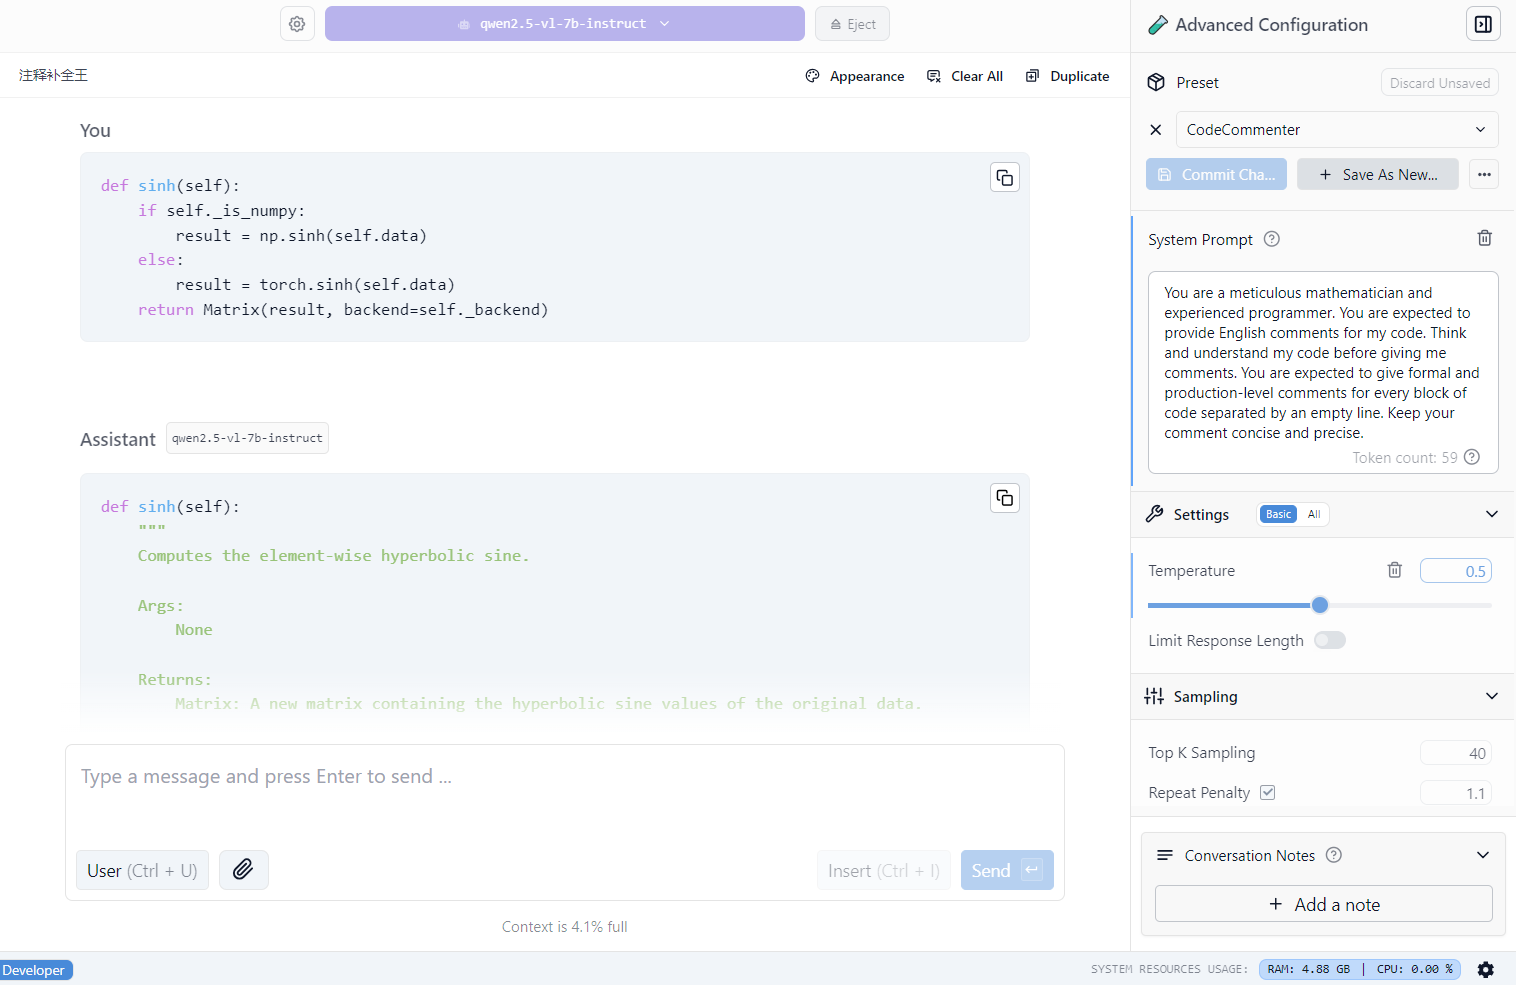

`1. Random Forest Utility Class using Bagging Methods and Bootstrap (self-implemented)`

In [ ]:
# This Random Forest class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Bagging‑style Random Forest Implementation
class RandomForest(Bagging):

    __attr__ = "MML.RandomForest"    

    def __init__(self, task: str = "classification", agg_method: str = "mean",
                       *,
                       tree_type: type = CART,
                       n_estimators: int = 10,
                       max_features: str | int | float | None = None,
                       bootstrap_ratio: float = 1.0,
                       replace: bool = True,
                       shuffle: bool = True,
                       floattype: type = float,
                       random_state: int | None = None,
                       n_workers: int | None = None,
                       feature_names: Matrix | Tensor | None = None,
                       tree_kwargs: dict = {},
                       agg_kwargs: dict = {},
                       **kwargs) -> None:
        """
        Parameters
        ----------
        task : str, one of {"classification", "regression"}, showing the learning task.
        agg_method: str, the name of aggregation method. See aggregation.py.
                    for classification, common ones are: "mean", "hard_vote", "soft_vote", ...
                    for regression, common ones are: "mean", "median", "percentile", "weighted", ...
        Optional:
            tree_type: type, showing the type of tree you are intending to use. Default, CART. You may pass in some other tree-compatible classes.
            n_estimators : int, indicating the maximum number of trees.
            max_features : {None, "sqrt", "log2", "over3"} | int | float, number of columns available to each tree.
            bootstrap_ratio : float, fraction of samples drawn per bootstrap sample, [0, 1].
            replace, shuffle : bool, if to shuffle the bootstrapped samples, passed to `_sample_bootstrapping`.
            floattype : type, numerical precision stored in internal matrices.
            random_state : int | None, global seed for reproducibility.
            n_workers
            feature_names : Matrix | Tensor | None, optional feature labels, in Object type. May be useful in feature importance.
            tree_kwargs : dict, extra hyperparameters forwarded to every tree model.
            agg_kwargs : dict, extra hyperparameters forwarded to the aggregation instance.
            **kwargs: other key word arguments, reserved for compatibility use.
        """
        
        super().__init__(feature_names = feature_names)

        # Record task and aggregation
        self.task  = task.lower()
        if self.task not in ("classification", "regression"):
            raise ValueError("Input `task` must be 'classification' or 'regression'")
        self.agg_method = agg_method
        
        # Random Forest Key arguments
        self.n_estimators = int(n_estimators) # Specified Number of Estimators
        self.n_estimators_used = 0            # Trainned Number of Estimators
        # Note, early stopping may prevent using all of the estimators
        
        # Random Forest Data ROW/COL settings
        self.max_features = max_features
        self.bootstrap_ratio = float(bootstrap_ratio)
        if self.bootstrap_ratio > 1.0 or self.bootstrap_ratio <= 0.0:
            raise ValueError("Extrapulate for bootstrap ratio is NOT allowed. You must set a value in (0, 1]")
            
        # Bootstrap and Feature Selecting arguments
        self.replace = replace
        self.shuffle = shuffle
        
        # Global random_state (Use _random_state_next() to move it forward)
        self.random_state = random_state
        
        # Threadpool Primitive
        self.n_workers = n_workers

        # Type Related Variables.
        self.tree_type = tree_type
        if isinstance(self.tree_type(), BaseTree) == False:
            raise ValueError(f"The given weak leaner type {tree_type} must be a child class of BaseTree.")
        self.floattype = floattype
        self.typeclass = None # Determined in fit()

        # KWargs for Trees and Aggregation
        self.tree_kwargs = tree_kwargs
        self.agg_kwargs = agg_kwargs   
        self.kwargs = kwargs
        
        # Original Dataset.
        self.original_X = None
        self.original_y = None
        
        # Processed Datasets.
        self._feature_sets = {}      # Key: tree id, starting from 0
                                     # Value: feature indices used
        self._bootstrapped = {}      # Key: tree id, starting from 0
                                     # Value: bootstrapped data tuple (see. bagging.py)

        # Runtime Containers (Forest Ensemble).
        self._estimators = {}        # Key: tree id, starting from 0
                                     # Value: tree instance
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor,
            *,
            one_hot: bool = True,
            verbosity: int | None = None,
            sequential_batch: int | None = None,
            evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None,
            evalmetrics: List[str] | str | None = None,
            early_stop: int | None = None,
            early_stop_logic: str = "some",
            continue_to_train: bool | None = None):
        """
        Train n_estimators independent trees.
        You may want to evaluate datasets while training. If so, please do the following things:
            1. set `verbosity` = 1 to print the evaluation
            2. set a proper `sequential_batch`, for 1 or 4 depending on cores of your CPU
            3. set the `evalset` to a dict of tuples of your dataset that is going to be evaluated
            4. set the `evalmetrics` either to a string of metrics or a list of strings
        You may want the algorithm to decide to stop training automatically. If so, please do things above, plus:
            1. set `early_stop` to a number of batches, like 1 or 2, which acts like: 
                if the metrics for all/some/any/most of the evaluation sets do not decrease anymore, 
                the training process will be terminated and return
            2. set `early_stop_logic` to determine the way of processing non-decreasing datasets/metrics
            3. If you hope to continue to train again, call this `fit` again with `continue_to_train` set to True

        Parameters:
            ----------
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y: Matrix | Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            Optional:
                one_hot : bool, if y is one-hot encoded for classification tasks.
                verbosity: int | None, if >= 1 and having `evalset`, then will report metrics each batch.
                sequential_batch: int | None, if int, then train `batch` estimators as a batch before evaluating.
                evalset: Dict[name : Tuple[X, y],
                              ...], | None, if provided, it may be used as evaluation set. XGBoost style.
                evalmetrics: list of str | str | None, metrics used to do the evaluation. Will be printed.
                early_stop: int | None, if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
                early_stop_logic: str, the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
                continue_to_train: bool | None, if non-None and True, the machine will try to restore the place it was and continue
                                   to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
                
        Returns:
            ----------
            self
        """

        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check.
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
                    
        # Stopping Logic Check.
        if early_stop_logic not in ("any", "some", "most", "all"):
            raise ValueError("Stopping logic `early_stop_logic` must be one of ('any', 'some', 'most', 'all')")
            
        # Prepare the subsets and sub-features
        self._fit_prep(X = X, y = y)
        n_samples, n_features = X.shape
        
        # Special evalmetrics type conversion
        if isinstance(evalmetrics, str) == True:
            evalmetrics = [evalmetrics]
        
        # Helper: Print and decide the evaluated results
        def _decide_stop_with_print(batch: int, undecreased_no: int, eval_dict: dict, last_eval_dict: dict):
            """
            Compare the metics and decide if

            Parameters
                ----------
                batch: int, batch no, for printing uses.
                undecreased_no : int, cumulative number that loss did NOT decrease before evaluation.
                eval_dict : dict, the passed evaluation dict.

            Returns
                -------
                Tuple of (int, bool):
                    int, updated undecreased_no
                    bool, whether to stop (True) training or continue (False)

            """
            # Dict is empty, abort
            if len(eval_dict) == 0:
                return undecreased_no, False
            if len(last_eval_dict) == 0:
                return undecreased_no, False
            
            # Difference dict copy
            diff_dict = deepcopy(eval_dict)
            
            # Calculate the difference (this - last)
            # and
            # If verbosity, print the new evaluation dict
            undes_count = 0
            allmetric_count = 0
            if verbosity >= 1:
                for evalset_name in eval_dict.keys():
                    eval_result = eval_dict[evalset_name]
                    print("Evalset: [", evalset_name, " : Metrics {", end = " ", sep = "")
                    for metric_name in eval_result.keys():
                        metric_value = eval_result[metric_name]
                        diff_dict[evalset_name][metric_name] = metric_value - last_eval_dict[evalset_name][metric_name]
                        if diff_dict[evalset_name][metric_name].to_list() > 0:
                            undes_count += 1
                        allmetric_count += 1
                        print(metric_name, ":", round(metric_value.to_list(), 4), ", ", end = " ", sep = "")
                    print("}]", end = "\n")
                    
            # If no early stop, directly return 0, False
            if early_stop is None:
                return 0, False
                    
            # If meets the requirement, stop training
            if early_stop_logic == "any":
                if undes_count > 0:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
            elif early_stop_logic == "some":
                if undes_count * 3 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
            elif early_stop_logic == "most":
                if undes_count * 2 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
            elif early_stop_logic == "all":
                if undes_count * 1 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    
            # If survives here, return 0, False to refresh the undecreased_no
            return 0, False
        
        round_ = 0
        tree_id = 0
        undecreased_no = 0
        last_eval_dict = {} # Please use deepcopy() here to avoid being errorly referred
        
        # Continue to train? Restore the last point
        if continue_to_train is not None:
            if continue_to_train == True:
                tree_id = self.n_estimators_used
        
        # Build up the forest - semi-sequentially or parallelly
        while tree_id < self.n_estimators:
            
            # Verbosity
            if verbosity >= 1:
                print(f"Training on Round: {round_}, starting from tree: {tree_id}, with {sequential_batch if sequential_batch is not None else 1} trainned concurrently.")
            
            # Train
            if sequential_batch is not None:
                # Use batch training
                tree_ids = []
                if tree_id + sequential_batch > self.n_estimators:
                    while tree_id < self.n_estimators:
                        tree_ids.append(tree_id)
                        tree_id += 1
                else:
                    tree_ids = [x for x in range(tree_id, tree_id + sequential_batch)]
                    tree_id += sequential_batch
                # Semi-sequantially train the trees
                self._train_semi_sequential(tree_ids, one_hot = one_hot)
                
            else:
                # Sequentially train the trees
                self._train_one_tree(tree_id, one_hot = one_hot)
                tree_id += 1
                
            # Evaluate and decide
            eval_dict = self._eval_one_batch(sequential_batch, evalset = evalset, evalmetrics = evalmetrics, one_hot = one_hot)
            
            # Try stop maker and receive the advice
            undecreased_no, decision = _decide_stop_with_print(round_, undecreased_no = undecreased_no, eval_dict = eval_dict, last_eval_dict = last_eval_dict)
            
            # Copy last evaluated dict
            last_eval_dict = deepcopy(eval_dict)
            
            # Count self increasing
            round_ += 1
            
            # Make decision to terminate or not
            if decision == True:
                break
            
        return self

    def _fit_prep(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Prepare datasets for n_estimators and selected features.

        Parameters:
            ----------
            X: Matrix | Tensor, the feature matrix (each row is a sample).
            y: Matrix | Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
        
        Returns:
            ----------
            self
        """
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check.
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
        
        # Copy Training data.
        self.original_X = X.to(backend=X._backend, dtype = self.floattype, device=X.device)
        self.original_y = y.to(backend=y._backend, dtype = self.floattype, device=y.device)
        
        # Resolve Number of Features for each weak learner.
        n_samples, n_features = X.shape
        self.max_features = self._resolve_max_features(n_features, q = self.max_features)
        
        # Bootstrap row indices, generate row-sliced subsets.
        # Prepare all n_estimators even somethimes not fully used.
        self._bootstrapped = self._sample_bootstrapping(
            X, y,
            M = self.n_estimators,
            k = self.bootstrap_ratio,
            replace = self.replace,
            shuffle = self.shuffle,
            random_state = self._random_state_next(),
            container = dict)

        # Retrieve the subset of features.
        # Prepare all n_estimators even somethimes not fully used.
        self._feature_sets = self._feature_random_select(
            M = self.n_estimators,
            N = n_features,
            q = self.max_features,
            replace = False,  # Default standarad
            random_state = self._random_state_next(),
            container = dict)
        
        # Restore trained trees and trained numbers
        self._estimators = {}
        self.n_estimators_used = 0
        
        return self

    def _resolve_max_features(self, n_features_all: int, q: int | float | str | None) -> int:
        """
        Translate max_features spec into an integer 1 ≤ q ≤ n_features_all.
        
        Parameters:
            ----------
            n_features_all: int, number of total features you have.
            q: int | float | str | None, feature number/proportion/description or None
        
        Returns:
            ----------
            int, number of features selected (parsed from the input, which may not be an int)
        """
        p = n_features_all
        
        # String: sqrt or log2
        if isinstance(q, str):
            q = q.lower()
            if q == "sqrt":
                return max(1, int(p ** 0.5))
            if q == "log2":
                return max(1, int(math.log2(p)))
            if q == "over3":
                return max(1, int(p // 3))
            raise ValueError("Resolving the max features, max_features `q` may be None, int, 'sqrt', or 'log2'")
        if isinstance(q, int):
            if q <= 0:
                raise ValueError("Resolving the max features, max_features `q` must be positive")
            return min(q, p)
        if isinstance(q, float):
            if q > 1:
                raise ValueError("Resolving the max features, max_features `q` must be less than 1 if float type")
            return max(1, int(p * q))
        raise ValueError("Unsupported max_features `q` type. Coult be int, float, str and None")

    def _train_one_tree(self, tree_id: int, one_hot: bool, *, _mutex : Mutex | None) -> None:
        """
        Train one tree based on the split data.

        Parameters
        ----------
            tree_id : int, the tree_id you expect to train.
                      The tree must NOT be initialied, else error.
            one_hot: bool, if classification and using one-hot coding.

        Returns
            -------
            None.

        """
        # Tree id validity check
        if tree_id > self.n_estimators:
            raise ValueError(f"You are training tree_id {tree_id}, but you only have {self.n_estimators} reserved.")
        
        # If the tree is trained
        if self._estimators.get(tree_id, None) is not None:
            raise ValueError(f"You are training tree_id {tree_id}, but the tree has been already trained.")
            
        # If datasets are not ready
        if self._bootstrapped.get(tree_id, None) is None or self._feature_sets.get(tree_id, None) is None:
            raise ValueError(f"You are training tree_id {tree_id}, but datasets/feature indices are not prepared.")
            
        X_selected, y_selected, _indices = self._bootstrapped[tree_id]
        feature_idx = self._feature_sets[tree_id]
        
        tree = self.tree_type(task = self.task, tree_id = tree_id, 
                              random_state = self._random_state_next(), floattype = self.floattype, feature_names = self.feature_names, **self.tree_kwargs)
        tree.fit(X_selected, y_selected, one_hot = one_hot, use_features_idx = feature_idx)

        # Apply lock to protect the resources
        with _mutex:
            self._estimators[tree_id] = tree
            self.n_estimators_used += 1
        return

    def _train_semi_sequential(self, tree_ids: List[int] | None, one_hot: bool):
        """
        Train one batch of trains using ThreadPool based on the split data.

        Parameters
        ----------
            tree_ids : list of int, the tree_id you expect to train.
                       The tree must NOT be initialied, else error.
            one_hot: bool, if classification and using one-hot coding.

        Returns
            -------
            None.
        """
        # Task IDs
        task_ids = []
        
        # Without Check, just invoke the TheadPool
        mutex = Mutex()
        fittingpool = ThreadPool(self.n_workers)
        for tree_id in tree_ids:
            task_id = fittingpool.execute(self._train_one_tree, tree_id = tree_id, one_hot = one_hot, _mutex = mutex)
            task_ids.append(task_id)
            
        # Wait until all 
        for task_id in task_ids:
            fittingpool.waituntil(task_id)
        return
        
    def _eval_one_batch(self, sequential_batch: int | None = None, evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None, evalmetrics: List[str] | str | None = None, one_hot: bool = True):
        """
        Evaluate the `evalset` after training for one batch.    

        Returns
            -------
            result_dict : dict  # Key: evalset name
                                # Value dict {metric_name: metric_value}
            or 
            {} if failed or did not evaluate
        """
        # If:
        # 1. sequential_batch non-None
        # 2. evalset is at least len = 1
        # 3. evalmetrics is non-None and at least len = 1
        # Do evaluation
        result_dict = {}
        if sequential_batch is not None and evalmetrics is not None and evalset is not None:
            if len(evalset) > 0 and len(evalmetrics) > 0:
                # Record the result for each eval group
                result_dict = {}    # Key: evalset name
                                    # Value dict {metric_name: metric_value}
                for eval_name in evalset.keys():
                    X_sub, y_sub = evalset[eval_name]
                    y_pred = self.predict(X_sub)
                    
                    # Inner metric dict, for values of result dict
                    metrics = {}
                    for metric_name in evalmetrics:
                        
                        # Evaluation: regression
                        if self.task == "regression":
                            eval_metric = RegressionMetrics(y_pred, y_sub, metric_type = metric_name).compute()
                            # Matrix | Tensor
                        
                        # Evaluation: this is classification
                        else:
                            if y_pred.shape[1] == 2 and one_hot == False:
                                # Binary and non-one hot
                                eval_metric = BinaryClassificationMetrics(self._to_binary_prob(y_pred), y_sub, metric_type = metric_name).compute()
                            else:
                                # Since the aggregation output is alway one-hot, use Multiple then
                                eval_metric = MultiClassificationMetrics(y_pred, y_sub, metric_type = metric_name).compute()
                            # Matrix | Tensor
                        metrics[metric_name] = eval_metric
                    # For all metrics, put them into result_dict
                    result_dict[eval_name] = metrics
        
        # If it is empty, then exit since nothing valid
        if len(result_dict) == 0:
            return {}
        
        # Else, return the dict
        else:
            return result_dict

    def predict(self, X: Matrix | Tensor) -> Matrix | Tensor:
        """
        Predict target values for samples in X.
        If classification, the output must be one-hot (even binary cases). Please kindly note.
        To convert one-hot to labels, use ._to_labels()
        
        Returns:
            Matrix | Tensor, output of predictions.
        """
        
        # Check if the model has (at least partially) fitted or not
        if self._is_fitted() == False:
            raise RuntimeError("No weak learner is fitted. Call .fit() before .predict()")
            
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if X.shape[1] != self.original_X.shape[1]:
            raise ValueError(f"Input feature `X` must have the same number of columns as the training data, which is {self.X.shape[1]}, but you have {X.shape[1]}")
        
        # Get the first trained tree model
        first_trained_model = list(self._estimators.keys())
        first_trained_model.sort()
        first_trained_model = self._estimators[first_trained_model[0]]
        
        # Get the first prediction
        first_prediction = first_trained_model.predict(X)
        
        # Collect predictions from estimators -> separate
        # !! Important: make the reuslt stacked over axis = 1
        #    with shape shape (n_estimators, n_samples, n_outputs) -> which IS a 3D array
        predictions_shape = (self.n_estimators_used, first_prediction.shape[0], first_prediction.shape[1])
        # Create an empty Matrix | Tensor Wrapper with 0 padded
        predictions = type(X).zeros(predictions_shape, backend = first_prediction._backend, dtype = first_prediction.dtype)
        predictions = predictions.to(backend = first_prediction._backend, dtype = first_prediction.dtype, device = first_prediction.device)
        
        # Iteratively predict
        estm_id = 0
        for tree_id in self._estimators.keys():
            estimator = self._estimators[tree_id]
            predictions[estm_id] = estimator.predict(X)
            estm_id += 1
        
        # choose an aggregation rule
        if self.task == "classification":
            agg = ClassificationAggregation(predictions, method = self.agg_method, floattype = self.floattype, **self.agg_kwargs)
        else:
            agg = RegressionAggregation(predictions, method = self.agg_method, floattype = self.floattype, **self.agg_kwargs)
        
        # Compute the aggreagated prediction
        return agg.compute()
    
    def _is_fitted(self) -> bool:
        """
        Check if the Random Forest has been fitted or not.

        Returns
            -------
            bool, if the model is fitted or not.

        """
        return True if len(self._estimators) > 0 else False

    def update_tree_kwargs(self, tree_kwargs : dict | None = None) -> None:
        """
        Update the tree-build key word arguments in whole.
        If you hope to replace or remove, please first get and then set by this.

        Returns
            -------
            None

        """
        if tree_kwargs is not None:
            self.tree_kwargs = tree_kwargs
            
    def update_agg_kwargs(self, agg_kwargs: dict | None = None) -> None:
        """
        Update the aggregation related key word arguments in whole.
        If you hope to replace or remove, please first get and then set by this.

        Returns
            -------
            None

        """
        if agg_kwargs is not None:
            self.agg_kwargs = agg_kwargs

    def plot_tree_id(self, tree_id: int, figsize = (14, 8)):
        """
        Plot an image representing the structure of the `tree_id`-th decision tree within the forest.
        For leaf nodes, the label shows the prediction.
        It calls the tree's method to do the plot.
        
        Args:
            tree_id: int, the index of the tree to be plotted
            figsize: tuple, the size of the plot
        """
        # Check if the model has (at least partially) fitted or not
        if self._is_fitted() == False:
            raise RuntimeError("No weak learner is fitted. Call .fit() before plotting the tree structure.")
            
        if self._estimators.get(tree_id, None) is None:
            raise RuntimeError(f"Tree {tree_id} has NOT been trained. Please train or continue to train before plotting the tree structure.")
        self._estimators[tree_id].plot_tree(figsize = figsize)

    def plot_feature_importances_tree_id(self, tree_id: int, max_features: int = None, figsize=(8, 5)) -> None:
        """
        Plot an image of the feature importance of ONE TREE as a bar chart.
        Each bar corresponds to the total loss reduction contributed by a feature.
        Values are extracted from self.feature_importance, converted to scalars using to_list()
        if necessary, and rounded to 4 digits.
        The bars are sorted in descending order by importance, similar to xgboost's plot.
        It calls the tree's method to do the plot.
        
        Args:
            tree_id: int, the index of the tree to be plotted
            max_features: int, the maximum number of features to plot (in importance descending)
            figsize: tuple, the size of the plot

        Returns
            -------
            None.

        """
        # Check if the model has (at least partially) fitted or not
        if self._is_fitted() == False:
            raise RuntimeError("No weak learner is fitted. Call .fit() before plotting the feature importance.")
            
        if self._estimators.get(tree_id, None) is None:
            raise RuntimeError(f"Tree {tree_id} has NOT been trained. Please train or continue to train before plotting the tree structure.")
        self._estimators[tree_id].plot_feature_importance(max_features = max_features, figsize = figsize)

    def plot_feature_importances_average(self, max_features: int = None, figsize=(8, 5)) -> None:
        """
        Plot an image of the feature importance of the averaged tree as a bar chart.
        Each bar corresponds to the total loss reduction contributed by a feature.
        Values are extracted from self.feature_importance, converted to scalars using to_list()
        if necessary, and rounded to 4 digits.
        The bars are sorted in descending order by importance, similar to xgboost's plot.
        
        Args:
            max_features: int, the maximum number of features to plot (in importance descending)
            figsize: tuple, the size of the plot

        Returns
            -------
            None.

        """
        # Check if the model has (at least partially) fitted or not
        if self._is_fitted() == False:
            raise RuntimeError("No weak learner is fitted. Call .fit() before plotting the feature importance.")
            
        # Extract feature_idx-name map from any tree
        tree_ids = list(self._estimators.keys())
        feature_index_map = deepcopy(self._estimators[tree_ids[0]].feature_index_map)

        # Extract the sum of feature importance of every trained tree
        feature_importance_names = feature_index_map.values()
        n_features = len(feature_importance_names)
        feature_importance_values = np.repeat(0.0, n_features)
        for i in range(len(tree_ids)):
            right_feature_importance = self._estimators[tree_ids[i]].feature_importance
            for j in range(n_features):
                right_val = right_feature_importance.get(j, 0.0)
                if isinstance(right_val, Object):
                    right_val = right_val.to_list()
                feature_importance_values[j] = feature_importance_values[j] + right_val / self.n_estimators_used
        
        # Extract feature indexes and corresponding importance values as scalars.
        feat_imp_list = []
        for feature_name, val in zip(feature_importance_names, feature_importance_values):
            feat_imp_list.append((feature_name, round(val, 4)))
        
        # Sort the features by importance descending (largest first).
        feat_imp_list.sort(key=lambda x: x[1], reverse=True)
        
        # Truncate if employed
        if max_features is not None:
            feat_imp_list = feat_imp_list[0:max_features]
        
        # Unzip the sorted feature names and importance values.
        features, importances = zip(*feat_imp_list)
        
        # Create a bar chart with the sorted feature importances.
        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(features, importances)
        ax.set_xlabel("Features")
        ax.set_ylabel("Importance")
        ax.set_title("Average Feature Importance (Gain)")
        
        # Add text labels on top of the bars.
        for idx, v in enumerate(importances):
            ax.text(idx, v, str(v), ha='center', va='bottom')
        plt.show()

    @staticmethod
    def save(instance, filepath:str):
        """
        Save the model object into a file to your disk.
        
        Args:
            instance: RandomForest, an instance
            filepath: str, the destination file path to save.
        """
        save({"__attr__" : "MML.RandomForest", "data": instance}, filepath, kompress=lzma, protocol=5)
        
    @staticmethod
    def load(filepath:str):
        """
        Load the model object from a file from your disk.
        
        Args:
            filepath: str, the destination file path to load.
        """
        rawobj = load(filepath, kompress=lzma)
        if isinstance(rawobj, dict) == False:
            raise ValueError("The file input is NOT a valid RandomForest model.")
        if rawobj.get("__attr__", "") != "MML.RandomForest":
            raise ValueError("The file input is NOT a valid RandomForest model.")
            # By Nathmath Huang (bh2821)
        return rawobj["data"]

    def __repr__(self):
        return f"RandomForest(task = {self.task}, tree_type = {str(self.tree_type)}, n_estimators = {self.n_estimators})."
    
# !!!
# Comments about points in the 1st part of this assignment:
# 
# > Implement bootstrap sampling
# ---> The bootstrap sampling is implemented in the base class `Bagging`.
# ---> Function `_sample_bootstrapping()` handles bootstrap sampling (usually replace = True).
# ---> The RandomForest class inherit the base class and get the method, used in the body of the training process.
# ---> In detail, for each estimator, it gives a full-feature subset having n_samples randomly chosen from the population.
#
# > Random feature selection for each split
# ---> The feature selection is implemented in the base class `Bagging`.
# ---> Function `_feature_random_select()` handles feature selection and return a container of indices of selected features.
# ---> The selected feature indices (yes, not to slice the data) will be passed to the tree model (CART) and the tree
# ---> will decide NOT to use non-selected features. The reason why I did this is primarily hoping to preserve the feature names
# ---> unmodified and dataset unsliced (to avoid some overhead when slicing and copying).
#
# > Train an ensemble of decision trees
# ---> The `fit()` method of RandomForest class fits the model on n_estimators weak learners.
# ---> Thr fit method first processes data, and call another helper method `_train_one_tree()` to
# ---> train one train using one subsample and one slice of features.
# ---> For compatibility to future Python without GIL, I implemented a `_train_semi_sequential()`,
# ---> which invokes a ThreadPool and concurrently train k models at once with proper thread-safe designs.
# ---> After training, the trained models are stored in a dict called `_estimators`, indexed by its model id.
#
# > Aggregate predictions using majority voting
# ---> For generic purposes, I have implemented one class called `Aggregation` and two children
# ---> `RegressionAggregation` and `ClassificationAggregation`. They have similar but different methods.
# ---> For regressions, `mean`, `median`, or `percentiles` are usually used (and are suggested).
# ---> For classifications, `mean` (the raw pobabilities), `hard_vore`, and `soft_vote` are implemented.
# ---> The required `majority voting` is an alias of `hard_vote` (first argmax then mean).
#
# > Include model parameters: number of trees, max depth, number of features per split
# ---> There are a bunch of hyperparameters that can be fine-tuned. (See __init__ and fit())
# ---> First, max depth, minimum split size, pruning parameters are allowed to be passed in by `tree_kwargs`.
# ---> Then, number of estimators, number of features, number of samples (default 1 times n_samples) can
# ---> also be adjusted in __init__ constructor.
# ---> I also tried to mimic xgboost and implemented a `train-time evaluation` functionality in fitting.
# ---> See fit(), you can see two parameters : evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None,
# ---> evalmetrics: List[str] | str | None = None; The first is a dict of data to be evaluated, the second is a list or string
# ---> of metrics used to evaluate. You may see the verbosity = 1 and the output in the following demonstration showing 
# ---> the result of the `train-time evaluation`.


`2.1 Load Data into the Notebook Environment and Process the Categorical Features`

In [162]:
# Load and preprocess the Bank Marketing dataset
#

# Note:
#      The dataset provides TWO sorts of data: `bank-full.csv` and `band-additional-full.csv`.
#      The primariy difference is the `additional` one has 4 more features.
#      So, my choice is to use the `additional` one. You may expect this also works if you change the dataset
#      but you may also need to adjust the data preprocessing process.

# Define the URL.
bank_url = 'https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/bank-additional-full.csv'

# Load the extended bank dataset into a pandas DataFrame.
raw_bank = pd.read_csv(bank_url, sep = ";")
raw_bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [163]:
# For the first step, let's convert the categorical results into numeric representations
#

# Inspect each non-numerical feature and transform them.
processed_bank = raw_bank.copy()

# Feature `job` - there are ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'retired', 'management', 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']
_feature = "job"
_ = processed_bank[_feature].unique()
# We give a mapping based on their average income (to avoid the matrix being too sparse)
# Create a mapping function to convert to numeric values
def _mapping_function(x) -> bool:
    _vmp = {
     'entrepreneur': 11,
     'admin.' : 10,  
     'management' : 9,
     'technician' : 8,
     'retired' : 7,
     'services' : 6,
     'blue-collar': 5,
     'housemaid' : 4,
     'self-employed': 3,
     'student': 2, 
     'unemployed' : 1,
     'unknown' : 0, 
     }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder([_feature], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# Feature marital - ['married', 'single', 'divorced', 'unknown']
_feature = "marital"
_ = processed_bank[_feature].unique()
# We give a mapping based on their financial stability 
# Create a mapping function to convert to numeric values
def _mapping_function(x) -> bool:
    _vmp = {
    'married' : 3, 
    'single' : 2,
    'divorced' : 1, 
    'unknown' : 0,
     }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder([_feature], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# Feature education - ['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree', 'illiterate']
_feature = "education"
_ = processed_bank[_feature].unique()
# We give a mapping based on their length of being educated
# Create a mapping function to convert to numeric values
def _mapping_function(x) -> bool:
    _vmp = {
    'basic.4y' : 4, 
    'basic.6y' : 6, 
    'basic.9y' : 9,
    'high.school' : 12, 
    'professional.course' : 13, 
    'university.degree' : 16, 
    'illiterate' : 1,
    'unknown' : 0,
    }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder([_feature], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# Feature default - ['yes', 'no', 'unknown']
_feature = "default"
_ = processed_bank[_feature].unique()
# We give a mapping regarding the polar-middle rule
# Create a mapping function to convert to numeric values
def _mapping_function(x) -> bool:
    _vmp = {
    'yes' : 2,
    'unknown' : 1,
    'no' : 0,
    }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder([_feature], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# Feature housing - ['yes', 'no', 'unknown']
_feature = "housing"
_ = processed_bank[_feature].unique()
# We give a mapping based on whether they DO have a house
# Create a mapping function to convert to numeric values
def _mapping_function(x) -> bool:
    _vmp = {
    'yes' : 2,
    'unknown' : 1,
    'no' : 0,
    }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder([_feature], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# Feature loan - ['yes', 'no', 'unknown']
_feature = "loan"
_ = processed_bank[_feature].unique()
# We give a mapping based on whether already have a loan or not
# Create a mapping function to convert to numeric values
def _mapping_function(x) -> bool:
    _vmp = {
    'no' : 2,
    'unknown' : 1,
    'yes' : 0,
    }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder([_feature], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# Feature contact - ['yes', 'no', 'unknown']
_feature = "contact"
_ = processed_bank[_feature].unique()
# We give a mapping based on whether already have a loan or not
# Create a mapping function to convert to numeric values
def _mapping_function(x) -> bool:
    _vmp = {
    'telephone' : 1,
    'cellular' : 0,
    }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder([_feature], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# We decide to do a one-hot on month and day_of_week
cate_encoder = CategoricalEncoder(["month", "day_of_week"], mode = "onehot", pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# Feature poutcome - ['nonexistent', 'failure', 'success']
_feature = "poutcome"
_ = processed_bank[_feature].unique()
# We give a mapping based on polar-middle rule
# Create a mapping function to convert to numeric values
def _mapping_function(x) -> bool:
    _vmp = {
    'success' : 2,
    'nonexistent': 1,
    'failure' : 0,
    }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder([_feature], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

# We decide to do a one-hot on the output
def _mapping_function(x) -> bool:
    _vmp = {
    'no' : 0,
    'yes': 1,
    }
    return _vmp[str(x)], str(x)
# Create a Encoder
cate_encoder = CategoricalEncoder(["y"], mode = "multi", sort_func = _mapping_function, pad_value=0)
processed_bank = cate_encoder.fit_transform(processed_bank)

     * `Special Notice` before grading this assignment!!! (See below) *

In [ ]:
# 👀 !!!!! Super Important Notice !!!!! 👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀
# 
# 👀 We should discard the `duration` column for the following reasons:
#
# 👀 > `duration` is NOT a pre-determined factor and has a post-hoc effect, which will affect the predicted causal effect
# 
# 👀 Here is the description in the data source page:
# 👀 https://archive.ics.uci.edu/dataset/222/bank+marketing
# 👀 `duration` last contact duration, in seconds (numeric). 
# 👀 Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). 
# 👀 Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. 
# 👀 Thus, this input should only be included for benchmark purposes and 
# 👀 should be discarded if the intention is to have a realistic predictive model.

# 👀 So, based on the reasons above, we choose to discard the column of duration
processed_bank_2 = processed_bank.copy()
processed_bank_2 = processed_bank_2.drop(["duration"], axis = 1)
# 👀 !!!!!!!!!!!!
# 👀 !!!!!!!!!!!! 👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀

     * `Special Notice` before grading this assignment!!! (See above) *

In [165]:
# We decide to create some meaningful combination of features to add interaction effects

# Marital-job, Marital-education, Job-education, Job-default, Job-loan, Housing-loan, Housing-education
processed_bank_2["marital_job"] = processed_bank_2["marital"] * processed_bank_2["job"]
processed_bank_2["marital_education"] = processed_bank_2["marital"] * processed_bank_2["education"]
processed_bank_2["job_education"] = processed_bank_2["job"] * processed_bank_2["education"]
processed_bank_2["job_default"] = processed_bank_2["job"] * processed_bank_2["default"]
processed_bank_2["job_loan"] = processed_bank_2["job"] * processed_bank_2["loan"]
processed_bank_2["housing_loan"] = processed_bank_2["housing"] * processed_bank_2["loan"]
processed_bank_2["housing_education"] = processed_bank_2["housing"] * processed_bank_2["education"]

# Previous-poutcome
processed_bank_2["previous_poutcome"] = processed_bank_2["previous"] * processed_bank_2["poutcome"]

# Campaign-poutcome
processed_bank_2["campaign_poutcome"] = processed_bank_2["campaign"] * processed_bank_2["poutcome"]

# Job-emp.var.rate, Job-cons.conf.idx, Job-nr.employed, Job-euribor3m, Job-cons.price.idx
processed_bank_2["job_emp_var_rate"] = processed_bank_2["job"] * processed_bank_2["emp.var.rate"]
processed_bank_2["job_cons_conf_idx"] = processed_bank_2["job"] * processed_bank_2["cons.conf.idx"]
processed_bank_2["job_nr_employed"] = processed_bank_2["job"] * processed_bank_2["nr.employed"]
processed_bank_2["job_euribor3m"] = processed_bank_2["job"] * processed_bank_2["euribor3m"]
processed_bank_2["job_euribor3m"] = processed_bank_2["job"] * processed_bank_2["cons.price.idx"]

# Marital-emp.var.rate, Marital-cons.conf.idx, Marital-nr.employed, Marital-euribor3m, Marital-cons.conf.idx
processed_bank_2["marital_emp_var_rate"] = processed_bank_2["marital"] * processed_bank_2["emp.var.rate"]
processed_bank_2["marital_cons_conf_idx"] = processed_bank_2["marital"] * processed_bank_2["cons.conf.idx"]
processed_bank_2["marital_nr_employed"] = processed_bank_2["marital"] * processed_bank_2["nr.employed"]
processed_bank_2["marital_euribor3m"] = processed_bank_2["marital"] * processed_bank_2["euribor3m"]
processed_bank_2["marital_euribor3m"] = processed_bank_2["marital"] * processed_bank_2["cons.price.idx"]

# Preview what is it like
processed_bank_2


,age,job,marital,education,default,housing,loan,contact,campaign,pdays,...,previous_poutcome,campaign_poutcome,job_emp_var_rate,job_cons_conf_idx,job_nr_employed,job_euribor3m,marital_emp_var_rate,marital_cons_conf_idx,marital_nr_employed,marital_euribor3m
0,56,4,3,2,0,0,2,1,1,999,...,0,1,4.4,-145.6,20764.0,375.976,3.3,-109.2,15573.0,281.982
1,57,6,3,5,1,0,2,1,1,999,...,0,1,6.6,-218.4,31146.0,563.964,3.3,-109.2,15573.0,281.982
2,37,6,3,5,0,2,2,1,1,999,...,0,1,6.6,-218.4,31146.0,563.964,3.3,-109.2,15573.0,281.982
3,40,10,3,3,0,0,2,1,1,999,...,0,1,11.0,-364.0,51910.0,939.940,3.3,-109.2,15573.0,281.982
4,56,6,3,5,0,0,0,1,1,999,...,0,1,6.6,-218.4,31146.0,563.964,3.3,-109.2,15573.0,281.982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,7,3,6,0,2,2,0,1,999,...,0,1,-7.7,-355.6,34745.2,663.369,-3.3,-152.4,14890.8,284.301
41184,46,5,3,6,0,0,2,0,1,999,...,0,1,-5.5,-254.0,24818.0,473.835,-3.3,-152.4,14890.8,284.301
41185,56,7,3,7,0,2,2,0,2,999,...,0,2,-7.7,-355.6,34745.2,663.369,-3.3,-152.4,14890.8,284.301
41186,44,8,3,6,0,0,2,0,1,999,...,0,1,-8.8,-406.4,39708.8,758.136,-3.3,-152.4,14890.8,284.301


In [166]:
# Astype into float32.
merged_bank = processed_bank_2.copy().astype("float32")
merged_bank

# Create the Features Matrix
features_bank = Matrix(merged_bank.drop(["y"], axis = 1), backend=backend, device=device)
print(features_bank)

# Create the Targets Matrix
targets_bank = Matrix(merged_bank[["y"]], backend=backend, device=device)
print(targets_bank)

# Create a feature name list
feature_names = list(merged_bank.drop(["y"], axis = 1).columns)

Matrix(backend=numpy, shape=(41188, 49), data=
[[ 5.60000e+01  4.00000e+00  3.00000e+00 ... -1.09200e+02  1.55730e+04
   2.81982e+02]
 [ 5.70000e+01  6.00000e+00  3.00000e+00 ... -1.09200e+02  1.55730e+04
   2.81982e+02]
 [ 3.70000e+01  6.00000e+00  3.00000e+00 ... -1.09200e+02  1.55730e+04
   2.81982e+02]
 ...
 [ 5.60000e+01  7.00000e+00  3.00000e+00 ... -1.52400e+02  1.48908e+04
   2.84301e+02]
 [ 4.40000e+01  8.00000e+00  3.00000e+00 ... -1.52400e+02  1.48908e+04
   2.84301e+02]
 [ 7.40000e+01  7.00000e+00  3.00000e+00 ... -1.52400e+02  1.48908e+04
   2.84301e+02]])
Matrix(backend=numpy, shape=(41188, 1), data=
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]])


`2.2 Split the dataset into 80% training and 20% test`

In [295]:
# Split the data into training (80%) and test (20%) sets
# 

# The balanced train_test_split is implemented in the MLBase class.
train_feature, test_feature, train_target, test_target = MLBase.train_test_split(
    features_bank, targets_bank, test_size=0.2, random_state=202821)
train_feature, test_feature,

(Matrix(backend=numpy, shape=(32950, 49), data=
 [[ 3.50000e+01  3.00000e+00  1.00000e+00 ... -4.27000e+01  5.22810e+03
    9.39180e+01]
  [ 3.20000e+01  3.00000e+00  2.00000e+00 ... -9.24000e+01  1.01982e+04
    1.85786e+02]
  [ 3.00000e+01  1.00000e+00  3.00000e+00 ... -1.26000e+02  1.55874e+04
    2.79600e+02]
  ...
  [ 3.80000e+01  8.00000e+00  3.00000e+00 ... -1.26000e+02  1.55874e+04
    2.79600e+02]
  [ 4.00000e+01  1.00000e+01  3.00000e+00 ... -1.09200e+02  1.55730e+04
    2.81982e+02]
  [ 4.00000e+01  9.00000e+00  3.00000e+00 ... -1.28100e+02  1.56843e+04
    2.81754e+02]]),
 Matrix(backend=numpy, shape=(8238, 49), data=
 [[ 3.10000e+01  1.10000e+01  3.00000e+00 ... -1.25400e+02  1.56843e+04
    2.83395e+02]
  [ 4.00000e+01  1.00000e+01  2.00000e+00 ... -7.28000e+01  1.03820e+04
    1.87988e+02]
  [ 3.60000e+01  1.00000e+01  2.00000e+00 ... -8.40000e+01  1.03916e+04
    1.86400e+02]
  ...
  [ 3.30000e+01  1.10000e+01  3.00000e+00 ... -1.09200e+02  1.55730e+04
    2.81982e+02]


In [296]:
# Let's see if the classes in train-test sets are balanced or not
#

print("Train set: ", train_target.mean(axis=0), "\nTest set:  ", test_target.mean(axis=0))
# Well, Okay. Fairly balanced.
# Since all of those features are categorical, it's hard to generate synthetic samples.
# So, that's it.

Train set:  Matrix(backend=numpy, shape=(1,), data=
[0.11295903]) 
Test set:   Matrix(backend=numpy, shape=(1,), data=
[0.11143482])


`2.3 Train and Evaluate pipeline, 2.3.1 Accuracy, precision, recall, F1-score, ROC/AUC`

In [ ]:
# A batch pipeline on doing this RandomForest classification task
# 

def rf_batch_binary_classification(train_feature, test_feature, train_target, test_target,
                              use=["my", "sklearn"], *, one_hot = False,
                              verbosity = 0, plot_feature_importance = True, plot_roc = True,
                              n_estimators = 10, agg_method = "soft_vote", max_features = 20, bootstrap_ratio = 1.0,
                              early_stop = None, evalset = None, evalmetrics = ["accuracy", ], continue_to_train = None,
                              tree_kwargs = {}, agg_kwargs = {}, 
                              **kwargs):
    
    """
    Trains and evaluates a RandomForest model using either my custom implementation or sklearn.

    Args:
        train_feature (Matrix | Tensor): Training feature data.
        test_feature (Matrix | Tensor): Test feature data.
        train_target (Matrix | Tensor): Training target labels.
        test_target (Matrix | Tensor): Test target labels.
        use: List of strings indicating the classification method to use. 
             Should be one of ["my", "sklearn"].
        one_hot (bool): Whether the y data is one hot or not.
        verbosity (int): Whether to print some progresses if set to non-zero values.
        plot_feature_importance (bool): Whether to plot the averaged feature importance chart or not, only valid when using "my".
        n_estimators (int): The maximum number of estimators to use, early_stop may prevent trainning all of the trees.
        agg_method (str): The aggregation methods you can use, for example, "hard_vote" or "soft_vote".
        max_features : ({None, "sqrt", "log2", "over3"} | int | float) number of columns available to each tree.
        bootstrap_ratio : (float) fraction of samples drawn per bootstrap sample, [0, 1].
        evalset (Dict[name : Tuple[X, y],
                     ...], | None) if provided, it may be used as evaluation set. XGBoost style.
        evalmetrics: (list of str | str | None) metrics used to do the evaluation. Will be printed.
        early_stop: (int | None) if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
        early_stop_logic: (str) the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
        continue_to_train: (bool | None) if non-None and True, the machine will try to restore the place it was and continue
                                to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
        tree_kwargs (dict): keyword arguments for tree estimators.
        agg_kwargs (dict): keyword arguments for aggregation class.
        **kwargs: Any other arguments, will be set to CART() and DecisionTreeClassifier() initialization.

    Returns:
        tuple: A tuple containing model, accuracy, precision, recall, F1-score, AUC, and confusion matrix. ROC curve is only plotted when using "my" mode.

    Raises:
        ValueError: If `use` argument is neither "my" nor "sklearn".

    """

    # Returns a tuple of (Model, Accuracy, precision, recall, F1-score, AUC Score, Confusion Matrix)
    
    if isinstance(use, list):
        use = use[0]
    if use != "my" and use != "sklearn":
        return ValueError("Arg `use` must be either `my` or `sklearn`!")
    
    # If using sklearn, forcefully convert data into numpy backend and scale it
    if use == "sklearn":
        from sklearn.ensemble import RandomForestClassifier
        train_feature = train_feature.to("numpy")
        train_target = train_target.to("numpy")
        test_feature = test_feature.to("numpy")
        test_target = test_target.to("numpy")
    else:
        pass

    # Create a classifier instance before doing everything.
    if use == "my":
        if verbosity >= 1:
            print("Using RandomForest as the classifier ...")
        model = RandomForest(task = "classification", agg_method = agg_method, tree_type = CART, 
                             n_estimators = n_estimators, bootstrap_ratio = bootstrap_ratio, max_features = max_features,
                             replace = True, shuffle = True, floattype = _backend.float32, random_state = None, 
                             feature_names = feature_names, tree_kwargs = tree_kwargs, agg_kwargs = agg_kwargs, **kwargs)
    else:
        if verbosity >= 1:
            print("Using sklearn's RandomForestClassifier as the classifier ...")
        model = RandomForestClassifier(n_estimators = n_estimators, criterion = "log_loss",
                                       max_features = max_features, **kwargs)

    # Fit the model with the training dataset
    if use == "my":
        if verbosity >= 2:
            print("Fitting ...")
        model.fit(train_feature, train_target, one_hot = one_hot, 
            verbosity = verbosity, sequential_batch = 1, evalset = evalset, evalmetrics = evalmetrics,
            early_stop = early_stop, early_stop_logic = "some", continue_to_train = continue_to_train)
    else:
        if verbosity >= 2:
            print("Fitting ...")
        model.fit(train_feature.data, train_target.flatten().data)

    # Predict the tags of the test set.
    if use == "my":
        if verbosity >= 2:
            print("Predicting ...")
        pred_onehot = model.predict(test_feature)
        pred_labels = model._to_binary_prob(pred_onehot)
    else:
        if verbosity >= 2:
            print("Predicting ...")
        pred_classes = model.predict_proba(test_feature.data)
        pred_classes = type(test_feature)(pred_classes, backend=test_feature._backend, device=test_feature.device)
        pred_labels = RandomForest._to_binary_prob(pred_classes)

    # Calculate Metrics
    acc = BinaryClassificationMetrics(pred_labels, test_target, "accuracy").compute()
    prec = BinaryClassificationMetrics(pred_labels, test_target, "precision").compute()
    recall = BinaryClassificationMetrics(pred_labels, test_target, "recall").compute()
    f1score = BinaryClassificationMetrics(pred_labels, test_target, "f1").compute()
    auc_ = BinaryClassificationMetrics(pred_labels, test_target, "auc_roc").compute()
    cfm = BinaryClassificationMetrics(pred_labels, test_target, "confusion_matrix").compute()

    # NOTE! Only plotting graphs when using `my` mode!
    if use == "my" and plot_feature_importance == True:
        model.plot_feature_importances_average(8, figsize=(14, 5))
    if plot_roc == True:
        from sklearn.metrics import roc_curve, auc
        false_positive_rate, true_positive_rate, _ = roc_curve(test_target.flatten().to("numpy").data, pred_labels.to("numpy").data)
        auc_score = auc(false_positive_rate, true_positive_rate)
        plt.figure()
        lw = 2
        plt.title(f'ROC curve (area = {round(auc_score, 4)})')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=lw)

    return model, acc, prec, recall, f1score, auc_, cfm   

# Note. All of those metrics are computed by `BinaryClassificationMetrics`.
#       ROC/AUC graph is plotted by matplotlib.

Using sklearn's RandomForestClassifier as the classifier ...
*******************This is sklearn Model*********************
Model Config: {SKLEARN, cross-entropy Loss, n_estimators = 20}
Accuracy: 0.89973295
Precision: 0.61675125
Recall: 0.2647059
F1-Score: 0.3704268292682927
Confusion Matrix:
 [[ 243  151]
 [ 675 7169]]


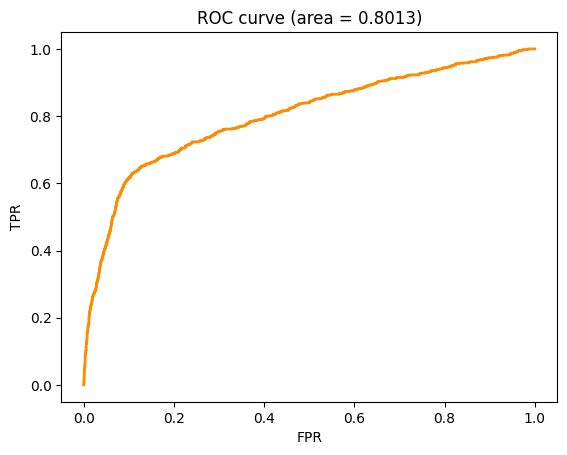

In [352]:
# Train and test your random forest (80/20 split) with varying number of trees - Benchmark SKLEARN
# 

# Train a relatively good model using sklearn
model0, acc, prec, recall, f1score, auc, cfm = rf_batch_binary_classification(
    train_feature, test_feature, train_target, test_target, use = "sklearn", 
    verbosity = 1, plot_feature_importance = False, plot_roc = True,
    max_depth = 20, n_estimators = 20, ccp_alpha = 0.0002,
)

# Evaluate performance on TEST SET.
print("*******************This is sklearn Model*********************")
print("Model Config: {SKLEARN, cross-entropy Loss, n_estimators = 20}")
print("Accuracy:", acc.data)
print("Precision:", prec.data)
print("Recall:", recall.data)
print("F1-Score:", f1score.data)
print("Confusion Matrix:\n", cfm.astype(int).data)

Using RandomForest as the classifier ...
Training on Round: 0, starting from tree: 0, with 1 trainned concurrently.
Training on Round: 1, starting from tree: 1, with 1 trainned concurrently.
Evalset: [train : Metrics { accuracy:0.9019,  precision:0.7206,  logloss:0.2694,  }]
Evalset: [test : Metrics { accuracy:0.8991,  precision:0.6593,  logloss:0.2737,  }]
Training on Round: 2, starting from tree: 2, with 1 trainned concurrently.
Evalset: [train : Metrics { accuracy:0.9024,  precision:0.7325,  logloss:0.2689,  }]
Evalset: [test : Metrics { accuracy:0.9002,  precision:0.6818,  logloss:0.2709,  }]
Training on Round: 3, starting from tree: 3, with 1 trainned concurrently.
Evalset: [train : Metrics { accuracy:0.9025,  precision:0.7161,  logloss:0.2692,  }]
Evalset: [test : Metrics { accuracy:0.8996,  precision:0.6585,  logloss:0.27,  }]
Training on Round: 4, starting from tree: 4, with 1 trainned concurrently.
Evalset: [train : Metrics { accuracy:0.9017,  precision:0.722,  logloss:0.2694,

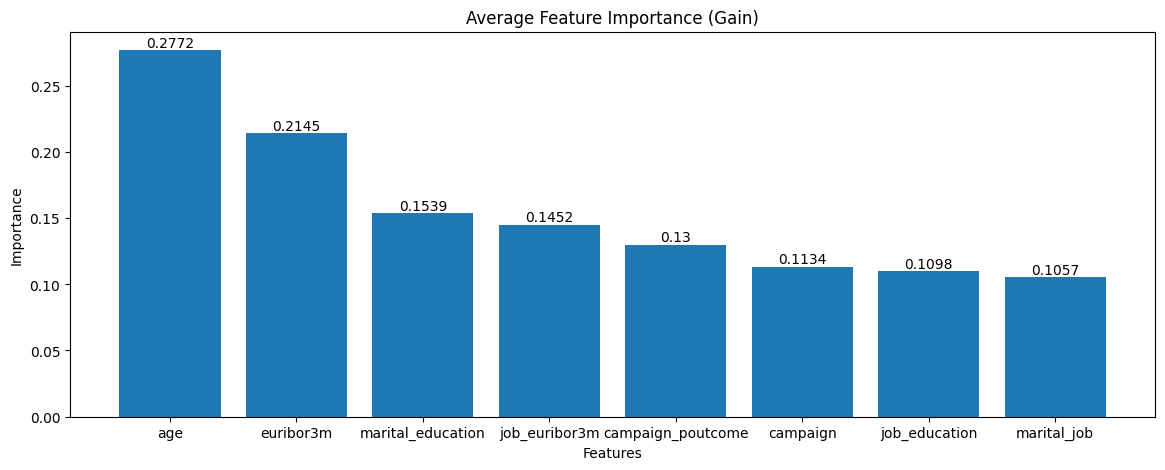

Model Config: {RandomForest, cross-entropy Loss, n_estimator = 25}
Accuracy: 0.9002185
Precision: 0.6791045
Recall: 0.19825707
F1-Score: 0.3069139966273187
Confusion Matrix:
 [[ 182   86]
 [ 736 7234]]


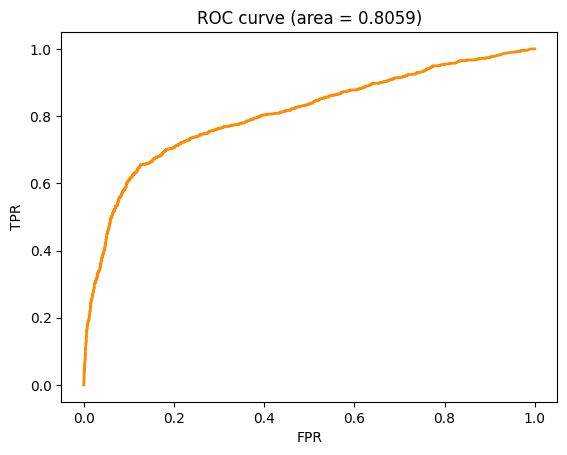

In [ ]:
# Train and test your random forest (80/20 split) with varying number of trees - Simple Demonstration on 20 trees
# 

# Train a RandomForest with CARTs using 20 trees
model1, acc, prec, recall, f1score, auc, cfm = rf_batch_binary_classification(
    train_feature, test_feature, train_target, test_target, use = "my", 
    verbosity = 1, plot_feature_importance = True, plot_roc = True, n_estimators = 20, 
    agg_method = "soft_vote",
    tree_kwargs = {"max_depth":24, "loss":"logloss",
                   "min_samples_split":0.0001, 
                   "prune":True, "prune_alpha":0.0002, 
                   "grid_accelerator":10, "grid_use_percentile": False, "grid_point_variant": 0.05},
    evalset = {"train": (train_feature, train_target), "test": (test_feature, test_target)},
    evalmetrics = ["accuracy", "precision", "logloss"],
    continue_to_train = False,    
)

# Evaluate performance on TEST SET.
print("Model Config: {RandomForest, cross-entropy Loss, n_estimator = 20}")
print("Accuracy:", acc.data)
print("Precision:", prec.data)
print("Recall:", recall.data)
print("F1-Score:", f1score.data)
print("Confusion Matrix:\n", cfm.astype(int).data)

In [ ]:
# A short review on the feature importance
#
# > From the plots above, we examined features appearred to be both important in predicting the subscription:
#   1. age (numeric): usually, a client may save more if they are in a middle age or elder age
#   2. euirbor3m (numeric): usually, a client may choose to save a term saving if the interest rate is high
#   3. marital * education (cross-term): usually, a married client with good educational background are more likely to have spare money to save
#   4. job * euirbor3m (cross-term): usually, a higher-class client (wealthy) expect to save more when the interest rate is high
#   5. campaign * poutcome (cross-term): usually, a client who was contacted frequently and always persuaded in the past is more likely to be a successful case this time
#   ...
#   Looks like they make sense.

`2.3.2 Compare the performance with 1 single tree`

Model Config: {RandomForest, cross-entropy Loss, n_estimator = 1, single tree}
Accuracy: 0.89645547
Precision: 0.58575195
Recall: 0.24183007
F1-Score: 0.34232845026985353
Confusion Matrix:
 [[ 222  157]
 [ 696 7163]]


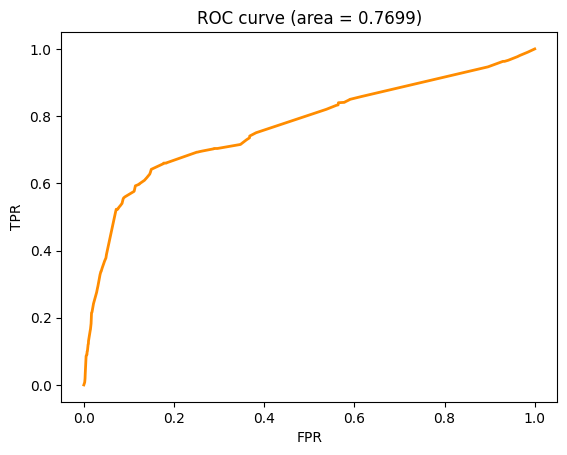

In [ ]:
# Comparison with a single decision tree - Naive case with only 1 Tree
# 

# Train a RandomForest with CARTs using 1 tree
model2, acc, prec, recall, f1score, auc, cfm = rf_batch_binary_classification(
    train_feature, test_feature, train_target, test_target, use = "my", 
    verbosity = 0, plot_feature_importance = False, plot_roc = True, n_estimators = 1, 
    agg_method = "soft_vote",
    max_features = 1.0,      # We here use all of the feature columns
    tree_kwargs = {"max_depth":24, "loss":"logloss",
                   "min_samples_split":0.0001, 
                   "prune":True, "prune_alpha":0.0002, 
                   "grid_accelerator":10, "grid_use_percentile": False, "grid_point_variant": 0.05},
    evalset = {"train": (train_feature, train_target), "test": (test_feature, test_target)},
    evalmetrics = ["accuracy", "precision", "logloss"],
    continue_to_train = False,    
)

# Evaluate performance on TEST SET.
print("Model Config: {RandomForest, cross-entropy Loss, n_estimator = 1, single tree}")
print("Accuracy:", acc.data)
print("Precision:", prec.data)
print("Recall:", recall.data)
print("F1-Score:", f1score.data)
print("Confusion Matrix:\n", cfm.astype(int).data)

In [ ]:
# A short comment on the performance with only 1 Tree
#

# Sklearn Best -   0.8992     0.6062    0.2734   (20 estimators, AUC 0.8022)
# RandomForest -   0.9002     0.6791    0.1983   (20 estimators, AUC 0.8059)
# Single CART  -   0.8964     0.5856    0.2418   (complete set of features, AUC 0.7699)
#
# For the first two models, we trainned them with 20 estimators. Compare them with a single CART tree using all features, we find 
# > 1. Even though in this unbalanced and less-predictible case, ensemble models perform better in terms of accuracy.
#      However, the improvement is really marginal (while in other cases that are more i.i.d, improvement may be more significant)
# > 2. Comparing with sklearn model, ensemble models outperforms significantly, all of those metrics have better results even
#      in the precision-recall tradeoff (0.6062 > 0.5856 and 0.2734 > 0.2418).
# > 3. But for our RandomForest, things are more different. RandomForest have slightly better accuracy, with higher precision
#      but lower recall. This also says the predicted values are concentrated in the low-value space. 
#      By training on different subsamples, a higher precision comes up with a lower recall (need to adjust the threshold).
#      But anyway, in terms of ROC/AUC, both ensemble models outperformed the single CART tree.
#
# ! The primary reason why ensemble models did NOT significantly outperform the single CART is:
#   1. too unbalanced dataset, it is really easy to predict them all as `0`
#   2. not perfectly i.i.d. samples, people may be correlated or follows to different kinds (distributions)
#   3. it is hard to improvement the prediction on a stochatic-like (noisy) system (to subscribe or not, is noisy and stochastic)

In [ ]:
# Example of saving the RandomForest model to disk.
#

# |
# V De-comment this line to save the model.
# model1.save(model1, "./models/RandomForest.ID01.bin")

`2.3.3 Compare the performance when n_estimators vary`

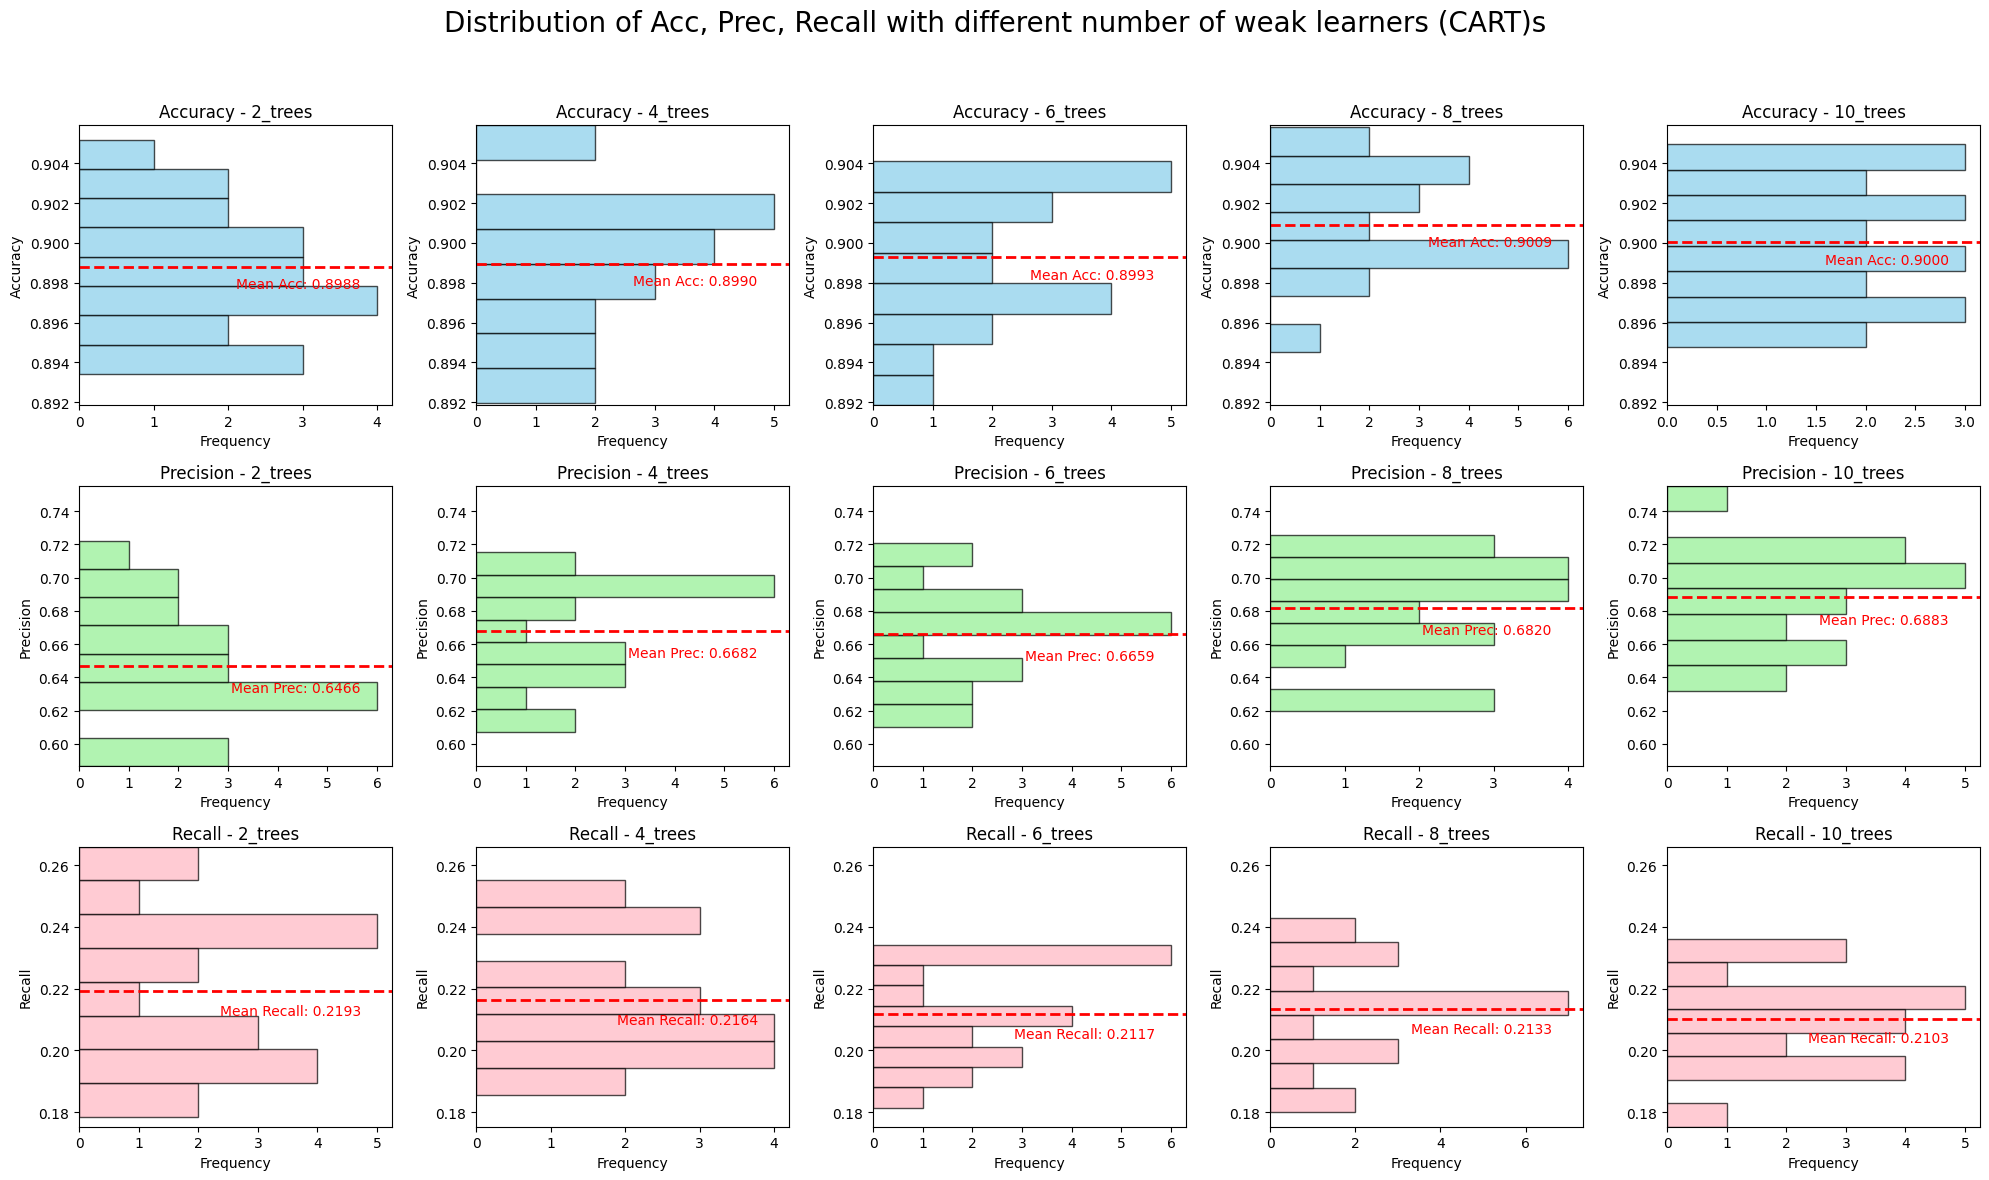

In [346]:
# Train and test your random forest (80/20 split) with varying number of trees - Varying the tree number and see the results
# 

# We train n_estimators ranging from 2 to 10 (sep = 2), while each type for 20 forests.
# Let's collect the results and report in a chart.
acc_scores = [[],[],[],[],[]]
prec_scores = [[],[],[],[],[]]
recall_scores = [[],[],[],[],[]]
# Note. By adjusting the threshold, we may seek for a tradeoff between precision and recall.
# > A higher precision means `In customers contacted, a higher proportion will subscribe`
# > A higher recall mean `For all customers available, more latent customers are transferred into subscribers`
# We here first focus on a higher precision value to measure the `conversion rate`.

# Create a task function.
def random_forest_nestimators_test(No = 0, n_round = 20, n_estimators = 2):

    accs = []
    precs = []
    recalls = []
    for _ in range(n_round):

        # Randomly choose a balanced train-test set.
        train_feature_, test_feature_, train_target_, test_target_ = MLBase.train_test_split(
            features_bank, targets_bank, test_size=0.2, random_state=None)
        
        # Collect the metrics using polynomial methods.
        model_, acc, prec, recall, f1score, auc, cfm = rf_batch_binary_classification(
        train_feature_, test_feature_, train_target_, test_target_, use = "my", 
        verbosity = 0, plot_feature_importance = False, plot_roc = False, n_estimators = n_estimators, 
        agg_method = "soft_vote",
        tree_kwargs = {"max_depth":24, "loss":"logloss",
                       "min_samples_split":0.0001, 
                       "prune":True, "prune_alpha":0.0002, 
                       "grid_accelerator":10, "grid_use_percentile": False, "grid_point_variant": 0.05})

        accs.append(float(acc.data))
        precs.append(float(prec.data))
        recalls.append(float(recall.data))

    acc_scores[No] = accs
    prec_scores[No] = precs
    recall_scores[No] = recalls

    return None

random_forest_nestimators_test(0, 20, 2)
random_forest_nestimators_test(1, 20, 4)
random_forest_nestimators_test(2, 20, 6)
random_forest_nestimators_test(3, 20, 8)
random_forest_nestimators_test(4, 20, 10)

# Names for the n_estimators
nsnames = ["2_trees", "4_trees", "6_trees", "8_trees", "10_trees"]

# Compute global y-axis limits for each metric.
# Note. I want to make the y-axis have the same limits for sub-plots.
acc_min = min([np.min(arr) for arr in acc_scores])
acc_max = max([np.max(arr) for arr in acc_scores])
prec_min = min([np.min(arr) for arr in prec_scores])
prec_max = max([np.max(arr) for arr in prec_scores])
recl_min = min([np.min(arr) for arr in recall_scores])
recl_max = max([np.max(arr) for arr in recall_scores])

# Create a figure with 3 rows and 5 columns.
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
fig.suptitle('Distribution of Acc, Prec, Recall with different number of weak learners (CART)s', fontsize=20)

# Plot horizontal histograms for each method.
for i, method in enumerate(nsnames):
    # Top row: Accuracy histograms, blue.
    data_acc = acc_scores[i]
    ax_acc = axes[0, i]
    # Plot histogram horizontally
    counts, bins, patches = ax_acc.hist(data_acc, bins=8, orientation='horizontal',
                                        alpha=0.7, color='skyblue', edgecolor='black')
    mean_acc = np.mean(data_acc)
    ax_acc.axhline(mean_acc, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_acc.get_xlim()[1]
    ax_acc.text(xmax * 0.9, mean_acc * 0.999, f'Mean Acc: {mean_acc:.4f}', color='red', va='center', ha='right')
    ax_acc.set_title(f'Accuracy - {method}')
    ax_acc.set_xlabel('Frequency')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_ylim(acc_min, acc_max)

    # Middle row: Precision score histograms, green.
    data_prec = prec_scores[i]
    ax_prec = axes[1, i]
    counts, bins, patches = ax_prec.hist(data_prec, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightgreen', edgecolor='black')
    mean_prec = np.mean(data_prec)
    ax_prec.axhline(mean_prec, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_prec.get_xlim()[1]
    ax_prec.text(xmax * 0.9, mean_prec * 0.98, f'Mean Prec: {mean_prec:.4f}', color='red', va='center', ha='right')
    ax_prec.set_title(f'Precision - {method}')
    ax_prec.set_xlabel('Frequency')
    ax_prec.set_ylabel('Precision')
    ax_prec.set_ylim(prec_min, prec_max)

    # Bottom row: Recall score histograms, pink.
    data_recl = recall_scores[i]
    ax_recl = axes[2, i]
    counts, bins, patches = ax_recl.hist(data_recl, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightpink', edgecolor='black')
    mean_recl = np.mean(data_recl)
    ax_recl.axhline(mean_recl, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_recl.get_xlim()[1]
    ax_recl.text(xmax * 0.9, mean_recl * 0.97, f'Mean Recall: {mean_recl:.4f}', color='red', va='center', ha='right')
    ax_recl.set_title(f'Recall - {method}')
    ax_recl.set_xlabel('Frequency')
    ax_recl.set_ylabel('Recall')
    ax_recl.set_ylim(recl_min, recl_max)

# Show the plot (3 * 5 sub-plot matrix).
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Short Comparision when tree number varies
# 
# Sklearn Best -   0.8997     0.6167    0.2647   (20 estimators, AUC 0.8022)
# RandomForest -   0.9002     0.6791    0.1983   (20 estimators, AUC 0.8059)
# Single CART  -   0.8964     0.5856    0.2418   (complete set of features, AUC 0.7699)
#
#  Average     - Accuracy  Precision    Recall
# 
# RF-n = 2     -   0.8988     0.6466    0.2193
# RF-n = 4     -   0.8990     0.6682    0.2164
# RF-n = 6     -   0.8993     0.6659    0.2117
# RF-n = 8     -   0.9009     0.6820    0.2133
# RF-n =10     -   0.9000     0.6883    0.2103
#
# > For the best (better) model using sklearn and my RandomForest, they achieved a comparable level of accuracy,
# which, although deemed high, may be biased since the dataset is extremely unbalanced.
# > Meanings of prevision and recall in this case can be interpreted:
#   as: A higher precision means `In customers contacted, a higher proportion will subscribe`
#   as: A higher recall mean `For all customers available, more latent customers are transferred into subscribers`
# > So, we use two additional metrics to evaluate the trade-off.
# > It is somehow obvious that sklearn model pulls up the precision and my CART ensembled model pulls up the precision,
#   which means the internal `threshold` in my RandomForest is slightly higher than that in sklearn's model.
#   Eqivalently, it means the average predicted values in my RandomForest is systematically lower.
#   However, by adjusting the threshold, we can easily solve this problem, as shown in 
#
#
# For performance when the number of estimators vary, we have the following conclusion:
#
# > 1. The accuracy (when threshold = 0.5) continues to increase marginally as the number of trees increases. It
#      is because tree models are born with high variance, when ensembled, the variance is reduced and hence more stable.
#      The reason why the improvement is marginal may be explained by lack of diversity in our samples.
#      It shows that even one single tree can achieve a good precision hence the aggregation and bagging is less beneficial,
#      as indicated by the performance of the single-tree case (accuracy = 0.8964).
# > 2. The precision continues to rise while the recall continues to fall as the number of trees increases. It 
#      shows that the ensemble model has better ability to reduce TNR (the chance to kill a negative buddy), while slightly 
#      decrease the ability to identify the positive buddy.
#      It may be useful in this case. Assume we are dealing with a real dataset with millions of customers, a higher TPR (precision)
#      increases the chance of subscription in all cases where employees did make a phone call. 
#      This can increase the subscription conversion rate among customers who have already been promoted, 
#      improving the efficiency of the bank.
# > 3. We also found that the sample reached a bottleneck when there were 10 classifiers, because as the number of 
#      classifiers increased (increased to 20), the improvement of its various indicators was very limited. 
#      The remaining part is the inherent noise of the sample set.


`2.3.4 Analysis and Comparision to scikit-learn`

In [412]:
# Compare my implementation with scikit-learn's DecisionTree
#
# We first leverage out model1 and model0 to find a proper threshold for our RandomForest to
# generate a similar precision-recall tradeoff to sklearn.

# This function returns a relative threshold of my model to achieve the same precision 
# as the sklearn model when it is using threshold 0.5
def relative_thres_my(train_feature, test_feature, train_target, test_target, mymodel: Any, skmodel: Any):

    """
    Returns: Tuple of [best_thres, MetricObject for my, MetricsObject for sk]
    """

    # Predict the tags of the test set.
    def predict_label(features, model, use = "my"):
        if use == "my":
            pred_onehot = model.predict(test_feature)
            pred_labels = model._to_binary_prob(pred_onehot)
        else:
            pred_classes = model.predict_proba(test_feature.to("numpy").data)
            pred_classes = type(test_feature)(pred_classes, backend=test_feature._backend, device=test_feature.device)
            pred_labels = RandomForest._to_binary_prob(pred_classes)
        return pred_labels
    
    pred_my = predict_label(test_target, mymodel, use = "my")
    pred_sk = predict_label(test_target, skmodel, use = "sklearn")

    # Calculate the precision of the sklearn model
    prec_sklearn = BinaryClassificationMetrics(pred_sk, test_target, "precision", threshold=0.5).compute()

    # Iteratively adjust the threshold by 0.001 to find the best threshold for my model
    thres = 0.30
    prec_my_last = BinaryClassificationMetrics(pred_my, test_target, "precision", threshold=thres).compute()
    while True:
        prec_my = BinaryClassificationMetrics(pred_my, test_target, "precision", threshold=thres).compute()
        if abs(prec_my.to_list() - prec_sklearn.to_list()) <= abs(prec_my_last.to_list() - prec_sklearn.to_list()):
            thres += 0.01
            prec_my_last = prec_my
        else:
            break

    thres -= 0.01
    prec_my_last = BinaryClassificationMetrics(pred_my, test_target, "precision", threshold=thres).compute()
    while True:
        prec_my = BinaryClassificationMetrics(pred_my, test_target, "precision", threshold=thres).compute()
        if abs(prec_my.to_list() - prec_sklearn.to_list()) <= abs(prec_my_last.to_list() - prec_sklearn.to_list()):
            thres += 0.002
            prec_my_last = prec_my
        else:
            break

    thres -= 0.001
    prec_my_last = BinaryClassificationMetrics(pred_my, test_target, "precision", threshold=thres).compute()
    while True:
        prec_my = BinaryClassificationMetrics(pred_my, test_target, "precision", threshold=thres).compute()
        if abs(prec_my.to_list() - prec_sklearn.to_list()) <= abs(prec_my_last.to_list() - prec_sklearn.to_list()):
            thres += 0.0005
            prec_my_last = prec_my
        else:
            break
        
    return thres, BinaryClassificationMetrics(pred_my, test_target, "precision", threshold=thres), BinaryClassificationMetrics(pred_sk, test_target, "precision", threshold=0.5), 


# Randomly choose train-test set.
train_feature_, test_feature_, train_target_, test_target_ = MLBase.train_test_split(
    features_bank, targets_bank, test_size=0.2, random_state=None)

# Using my RandomForest
model_my, acc, prec, recall, f1score, auc, cfm = rf_batch_binary_classification(
    train_feature_, test_feature_, train_target_, test_target_, use = "my", 
    verbosity = 0, plot_feature_importance = False, plot_roc = False, n_estimators = 20, 
    agg_method = "soft_vote",
    tree_kwargs = {"max_depth":24, "loss":"logloss",
                   "min_samples_split":0.0001, 
                   "prune":True, "prune_alpha":0.0002, 
                   "grid_accelerator":10, "grid_use_percentile": False, "grid_point_variant": 0.05})

# Using sklearn RandomForestClassifier
model_sk, acc, prec, recall, f1score, auc, cfm = rf_batch_binary_classification(
        train_feature_, test_feature_, train_target_, test_target_, use = "sklearn", 
        verbosity = 0, plot_feature_importance = False, plot_roc = False,
        max_depth = 20, n_estimators = 20, ccp_alpha = 0.0002)

# Obtain the fair threshold for my model
best_thres, metrics_my, metrics_sk = relative_thres_my(train_feature_, test_feature_, train_target_, test_target_, model_my, model_sk)

# Evaluate more metrics
def eval_more_diff(metrics_my, metrics_sk):
    """
    Returns a tuple of (my_acc - sk_acc, my_recall - sk_recall, my_f1 - sk_f1). All in float type.
    """

    metrics_my.metric_type = "accuracy"
    my_acc = metrics_my.compute()
    metrics_sk.metric_type =  "accuracy"
    sk_acc = metrics_sk.compute()

    metrics_my.metric_type = "recall"
    my_rec = metrics_my.compute()
    metrics_sk.metric_type =  "recall"
    sk_rec = metrics_sk.compute()

    metrics_my.metric_type = "f1"
    my_f1  = metrics_my.compute()
    metrics_sk.metric_type =  "f1"
    sk_f1  = metrics_sk.compute()

    return (my_acc - sk_acc).to_list(), (my_rec - sk_rec).to_list(), (my_f1 - sk_f1).to_list()

def eval_more_diff_ex(metrics_my, metrics_sk):
    """
    Returns a tuple of (my_acc - sk_acc, my_prec - sk_prec, my_recall - sk_recall, my_f1 - sk_f1). All in float type.
    """

    metrics_my.metric_type = "accuracy"
    my_acc = metrics_my.compute()
    metrics_sk.metric_type =  "accuracy"
    sk_acc = metrics_sk.compute()

    metrics_my.metric_type = "precision"
    my_prec = metrics_my.compute()
    metrics_sk.metric_type =  "precision"
    sk_prec = metrics_sk.compute()

    metrics_my.metric_type = "recall"
    my_rec = metrics_my.compute()
    metrics_sk.metric_type =  "recall"
    sk_rec = metrics_sk.compute()

    metrics_my.metric_type = "f1"
    my_f1  = metrics_my.compute()
    metrics_sk.metric_type =  "f1"
    sk_f1  = metrics_sk.compute()

    return (my_acc - sk_acc).to_list(), (my_prec - sk_prec).to_list(), (my_rec - sk_rec).to_list(), (my_f1 - sk_f1).to_list()

# Here, you can see when precision is matched (we have fixed the preision-recall tradeoff), 
# what about the performance under other different metrics
diff_acc, diff_prec, diff_recall, diff_f1s = eval_more_diff_ex(metrics_my=metrics_my, metrics_sk=metrics_sk)
print("Relative threshold     : ", best_thres)
print("Difference in Accuracy : ", diff_acc)
print("Difference in Precision: ", diff_prec)
print("Difference in Recall   : ", diff_recall)
print("Difference in F1-Score:  ", diff_f1s)


Relative threshold     :  0.4415000000000001
Difference in Accuracy :  0.00024276971817016602
Difference in Precision:  -0.007993102073669434
Difference in Recall   :  0.026766598224639893
Difference in F1-Score:   0.024641441876370407


In [ ]:
# A Kind Summarization
#
# In order to make models comparable, we decided to use the same precision-recall tradeoff, as measured 
# by precision metrics. We try to adjust the threshold in deciding the results generated by my RandomForest model.
#
# 
# The threshold 0.4415 is the threshold that minimize the difference in precision at least to 0.001 level.
# It means when setting threshold to 0.4415 for my model, it yields the same precision result as the sklearn model does.
# 
# The difference in Accuracy, Recall, and F1-Score are measured under 0.4415 for my model, and 0.5 for sklearn model.
# We can see my model excels in recall and f1-score while having a comparable accuracy level.

In [ ]:
# Compare my implementation with scikit-learn's RandomForestClassifier
#
# We then still plot a difference histogram using our implementation and sklearn's controlling the precision-recall tradeoff each round.
# It means, two implementations are measured under the same `precision-recall` tradeoff.

thresholds = []
acc_score_diff = []
recall_score_diff = []
f1score_score_diff = []

def bank_comparable_test_thread():

    # Randomly choose train-test set.
    train_feature_, test_feature_, train_target_, test_target_ = MLBase.train_test_split(
        features_bank, targets_bank, test_size=0.2, random_state=None)

    # Using my RandomForest
    model_my, acc, prec, recall, f1score, auc, cfm = rf_batch_binary_classification(
    train_feature_, test_feature_, train_target_, test_target_, use = "my", 
    verbosity = 0, plot_feature_importance = False, plot_roc = False, n_estimators = 20, 
    agg_method = "soft_vote",
    tree_kwargs = {"max_depth":24, "loss":"logloss",
                   "min_samples_split":0.0001, 
                   "prune":True, "prune_alpha":0.0002, 
                   "grid_accelerator":10, "grid_use_percentile": False, "grid_point_variant": 0.05})

    # Using sklearn RandomForestClassifier
    model_sk, acc, prec, recall, f1score, auc, cfm = rf_batch_binary_classification(
        train_feature_, test_feature_, train_target_, test_target_, use = "sklearn", 
        verbosity = 0, plot_feature_importance = False, plot_roc = False,
        max_depth = 20, n_estimators = 20, ccp_alpha = 0.0002)

    # Obtain the fair threshold for my model
    best_thres, metrics_my, metrics_sk = relative_thres_my(train_feature_, test_feature_, train_target_, test_target_, model_my, model_sk)

    # Calculate controlled metrics
    diff_acc, diff_recall, diff_f1s = eval_more_diff(metrics_my=metrics_my, metrics_sk=metrics_sk)

    thresholds.append(best_thres)
    acc_score_diff.append(diff_acc)
    recall_score_diff.append(diff_recall)
    f1score_score_diff.append(diff_f1s)

# Collect the difference in three metrics
for i in range(125):
    bank_comparable_test_thread()


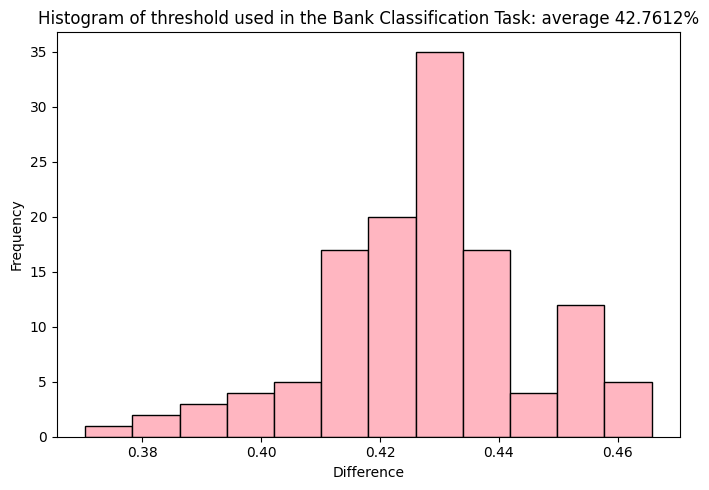

In [451]:
# Compare my implementation with scikit-learn's RandomForestClassifier
#

# Plot the thresholds chosen in my RandomForest case to achieve the same level of precision when sklearn's model uses 0.5 as the result.
my_thresholds = pd.DataFrame({"my_thresholds": thresholds})
my_thresholds_mean = round(my_thresholds.mean()["my_thresholds"] * 100, 4)
plt.figure(figsize=(7, 5))
plt.hist(my_thresholds["my_thresholds"], bins=12, color="lightpink", edgecolor="black")
plt.title(f"Histogram of threshold used in the Bank Classification Task: average {my_thresholds_mean}%", fontsize=12)
plt.xlabel("Difference", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.tight_layout()
plt.show()

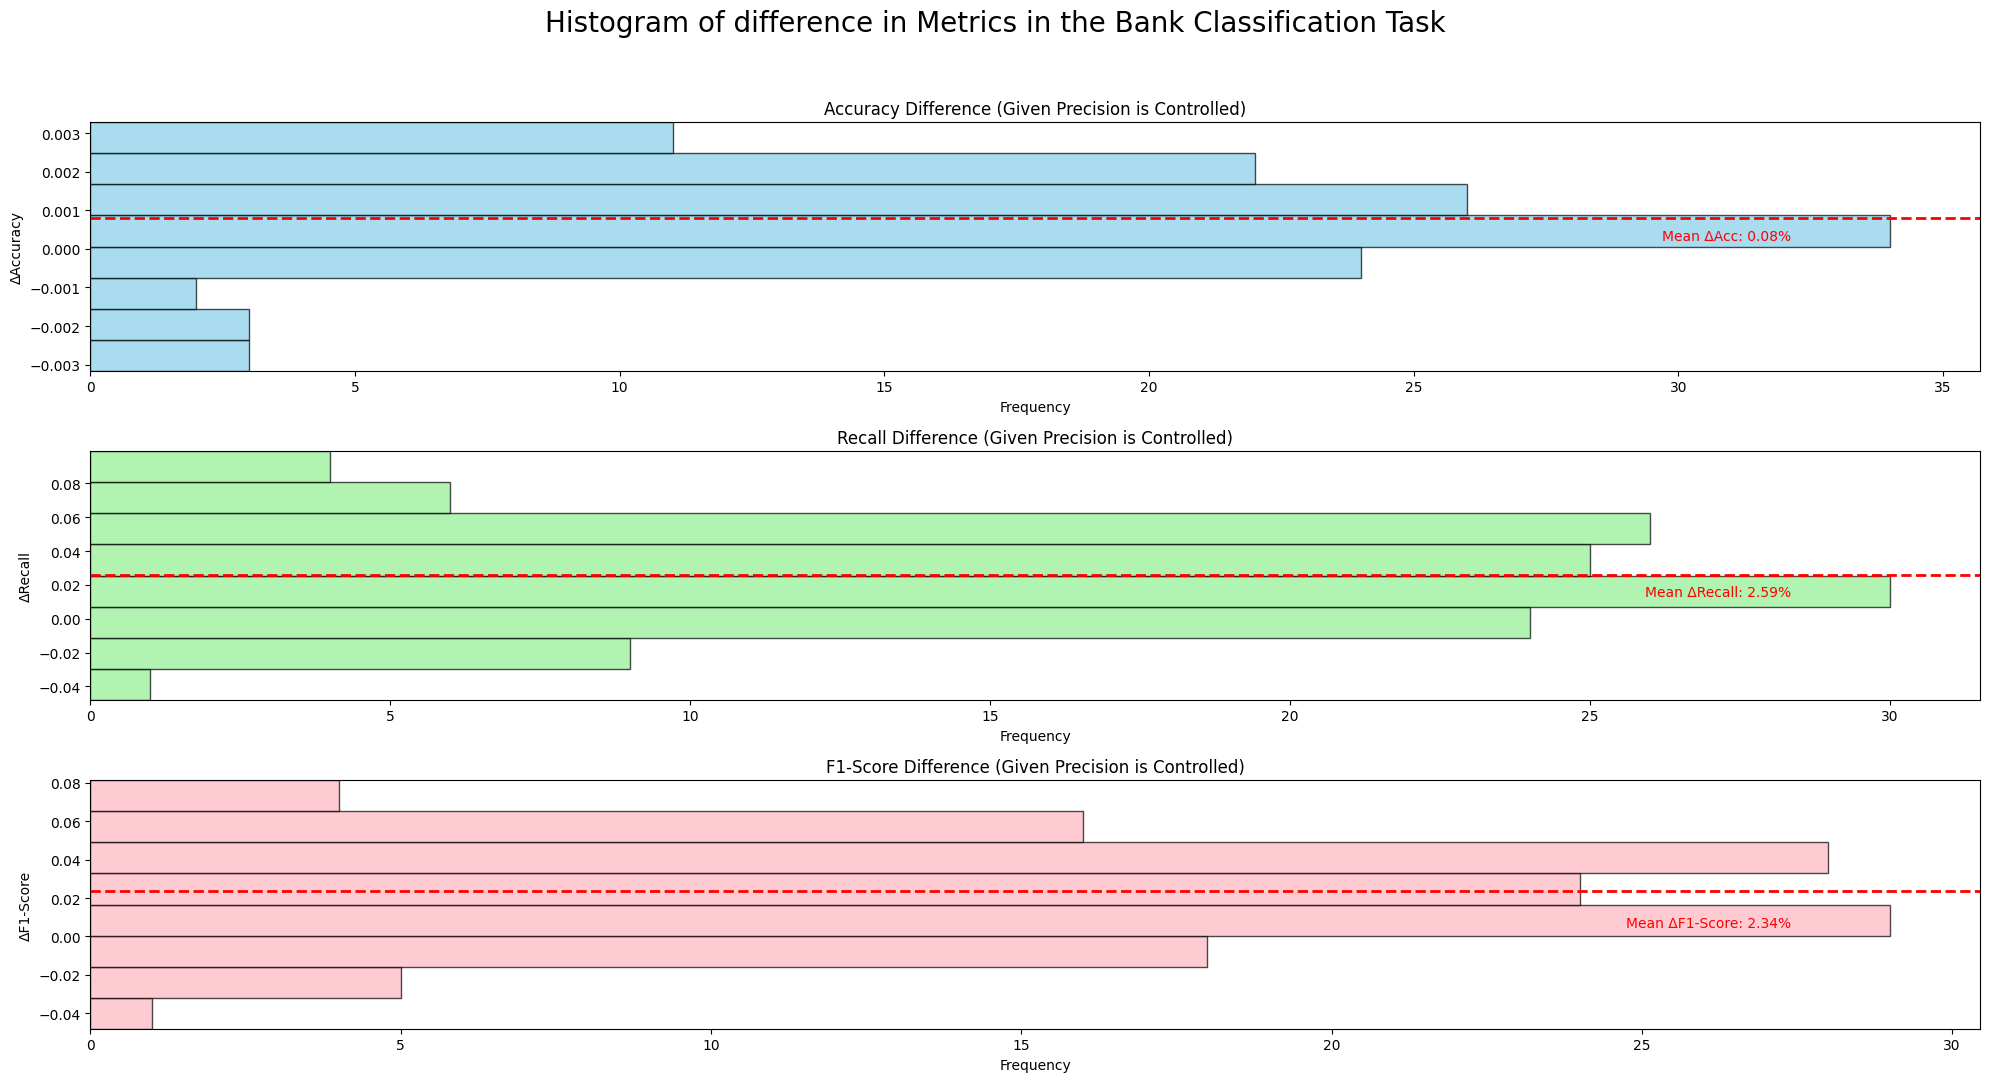

In [ ]:
# Compare my implementation with scikit-learn's RandomForestClassifier
#

# Plot the difference in metrics given precision is controlled
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 11))
fig.suptitle('Histogram of difference in Metrics in the Bank Classification Task', fontsize=20)

# Names for the n_metrics
nmnames = ["Accuracy", "Recall", "F1-Score"]

# Top row: Accuracy histograms, blue.
data_acc = acc_score_diff
ax_acc = axes[0]
counts, bins, patches = ax_acc.hist(data_acc, bins=8, orientation='horizontal',
                                    alpha=0.7, color='skyblue', edgecolor='black')
mean_acc = np.mean(data_acc)
ax_acc.axhline(mean_acc, color='red', linestyle='dashed', linewidth=2)
xmax = ax_acc.get_xlim()[1]
ax_acc.text(xmax * 0.9, mean_acc * 0.4, f'Mean ΔAcc: {mean_acc * 100:.2f}%', color='red', va='center', ha='right')
ax_acc.set_title('Accuracy Difference (Given Precision is Controlled)')
ax_acc.set_xlabel('Frequency')
ax_acc.set_ylabel('ΔAccuracy')
ax_acc.set_ylim(min(data_acc), max(data_acc))

# Middle row: Recal score histograms, green.
data_recall = recall_score_diff
ax_recall = axes[1]
counts, bins, patches = ax_recall.hist(data_recall, bins=8, orientation='horizontal',
                                       alpha=0.7, color='lightgreen', edgecolor='black')
mean_recall = np.mean(data_recall)
ax_recall.axhline(mean_recall, color='red', linestyle='dashed', linewidth=2)
xmax = ax_recall.get_xlim()[1]
ax_recall.text(xmax * 0.9, mean_recall * 0.6, f'Mean ΔRecall: {mean_recall * 100:.2f}%', color='red', va='center', ha='right')
ax_recall.set_title('Recall Difference (Given Precision is Controlled)')
ax_recall.set_xlabel('Frequency')
ax_recall.set_ylabel('ΔRecall')
ax_recall.set_ylim(min(data_recall), max(data_recall))

# Bottom row: F1 score histograms, pink.
data_f1s = f1score_score_diff
ax_f1s = axes[2]
counts, bins, patches = ax_f1s.hist(data_f1s, bins=8, orientation='horizontal',
                                    alpha=0.7, color='lightpink', edgecolor='black')
mean_f1s = np.mean(data_f1s)
ax_f1s.axhline(mean_f1s, color='red', linestyle='dashed', linewidth=2)
xmax = ax_f1s.get_xlim()[1]
ax_f1s.text(xmax * 0.9, mean_f1s * 0.3, f'Mean ΔF1-Score: {mean_f1s * 100:.2f}%', color='red', va='center', ha='right')
ax_f1s.set_title('F1-Score Difference (Given Precision is Controlled)')
ax_f1s.set_xlabel('Frequency')
ax_f1s.set_ylabel('ΔF1-Score')
ax_f1s.set_ylim(min(data_f1s), max(data_f1s))

# Show the plot (1 * 3 sub-plot matrix).
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Compare my implementation with scikit-learn's RandomForestClassifier
#

# Sklearn Best -   0.8997     0.6167    0.2647   (20 estimators, AUC 0.8022)
# RandomForest -   0.9002     0.6791    0.1983   (20 estimators, AUC 0.8059)
# Single CART  -   0.8964     0.5856    0.2418   (complete set of features, AUC 0.7699)
#
#  Average     - Accuracy  Precision    Recall
# 
# RF-n = 2     -   0.8988     0.6466    0.2193
# RF-n = 4     -   0.8990     0.6682    0.2164
# RF-n = 6     -   0.8993     0.6659    0.2117
# RF-n = 8     -   0.9009     0.6820    0.2133
# RF-n =10     -   0.9000     0.6883    0.2103
# 
# Comparable Test:
# The metrics below are evaluated given precisions are controlled the same.
# > ΔAccuracy :    0.08%
# > ΔPrecision:    0.00%
# > ΔRecall   :    2.59%
# > ΔF1-Score :    2.34%

# Conclusion:
# > Performance: On average, my RandomForest using CART instances as weak learners performs at a comparable level with
#   sklearn's RandomForestClassifier. While some difference may exist, like my CARTs pulls values too low (causing a lower
#   comprable threshold to match the same precision), it may be caused by different tree types (as far as I know, sklearn
#   implemented ID3 or C4.5 trees, not CART. Both of them are NOT binary, but multi-branched trees) and that's not a fault for this 
#   RandomForest implementation.
#   Moreover, when adjusting the threshold to make two predictions comparable, we surprusingly found that my CARTs and 
# 
# > Speed: I admit there are too many logic processes in building up the CART tree and RandomForest bagging model. Recursion
#   and for loops largely reduce the speed and makes it `observably slow`. However, it is not non-usable, since it only 
#   takes 3 to 5 minutes to perform a 20-estimator ensemble model using CARTs tree with hunderds of nodes.
#   Let me blame this on Python's type checking :)
# 
# ⭐ > In a nutshell, although my implementation usually `costs significantly more time` to split and train the trees, my RandomForest
# ⭐ implementation performs at least comparable to sklearn's classification trees in most of classfication tasks.
# ⭐ > While my CARTs may pull values lower, when controlled the precision by adjusting to a new threshold, the performance then excels
# ⭐ the scikit-learn marginally in accuracy and significantly in recall, giving the bank more chances to contact the right clients.

`End of Homework 2 Q2 by Nathmath Huang (bh2821)`